In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp
from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches
import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
sys.path.append('../')
from RF_functions import *
from training_functions import *
from dataset import * 
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem
from rdkit.Chem import AllChem



import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV

import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import getpass, os

from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import matplotlib.pyplot as plt


In [13]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [14]:
def plot_tani_dist_distr(df, smiles_col, df_name, radius=2, featurized=False, subset_col='subset', subsets=False, ref_subset='train', plot_width=6, ndist_max=None, **metric_kwargs):
    """Generate a density plot showing the distribution of nearest neighbor distances between
    ecfp feature vectors, using the Tanimoto metric. Optionally split by subset.
    Args:
        df (DataFrame): A data frame containing, at minimum, a column of SMILES strings.
        smiles_col (str): Name of the column containing SMILES strings.
        df_name (str): Name for the dataset, to be used in the plot title.
        radius (int): Radius parameter used to calculate ECFP fingerprints. The default is 2, meaning that ECFP4 fingerprints are calculated.
        featurized (bool): If True, the input data frame contains precomputed features. If False, features are calculated on the fly.
        subset_col (str): Name of the column containing subset names.
        subsets (bool): If True, distances are only calculated for compounds not in the reference subset, and the distances computed are to the nearest neighbors in the reference subset.
        ref_subset (str): Reference subset for nearest-neighbor distances, if `subsets` is True.
        plot_width (float): Plot width in inches.
        ndist_max (int): Not used, included only for backward compatibility.
        metric_kwargs: Additional arguments to pass to metric. Not used, included only for backward compatibility.
    Returns:
        dist (DataFrame): Table of individual nearest-neighbor Tanimoto distance values. If subsets is True,
        the table will include a column indicating the subset each compound belongs to.
    """
    log = logging.getLogger('ATOM')
    
    num_cmpds = len(df)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        if not featurized:
            dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
        else:
            fprints1_df = df[[col for col in df.columns if 'ecfp' in col]]
            fprints1=df_to_bitvect(fprints1_df)
            fprints2 = None
            within_dset = True
            dists=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
            
        # flatten dists
        dists = dists.flatten()
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset:
                continue
            if not featurized:
                smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
                smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
                diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
            else:
                fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
                fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
                print(subs)
                
                fprints1=df_to_bitvect(fprints1_df)
                fprints2=df_to_bitvect(fprints2_df)
                

                within_dset=False
                diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
    
            # flatten dists
            diststmp = diststmp.flatten()
    
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist',subset_col])
            dists=pd.concat([dists,diststmp])

    
    dists=dists.reset_index(drop=True)
    fig, ax = plt.subplots(1, figsize=(plot_width, plot_width), dpi=300)
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue=subset_col, legend=True, common_norm=False, common_grid=False, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')

    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name}: Distribution of {dist_metric} distances\nbetween MFP feature vectors from non-{ref_subset.upper()} subsets\nto their nearest neighbors in the {ref_subset.upper()} subset")
    plt.show(); 
    return dists, fig, ax

In [11]:
og_datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
holdout_datapath = '/Users/jayceepang/msse/ATOM_CODE/datasets/holdout_data/featurized/'
drop_cols=['NEK', 'compound_id', 'base_rdkit_smiles']
mfp_dict = {}
for i in range (2048): 
    mfp_dict[str(i)] = f'ecfp_2048_{i}'
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
new_neks=['NEK1', 'NEK11', 'NEK2', 'NEK3', 'NEK4', 'NEK5','NEK6', 'NEK9']

NEK2_binding
subset
train              1125
synthetic SMOTE    1035
nanobret            400
20% test            283
UNDER                90
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


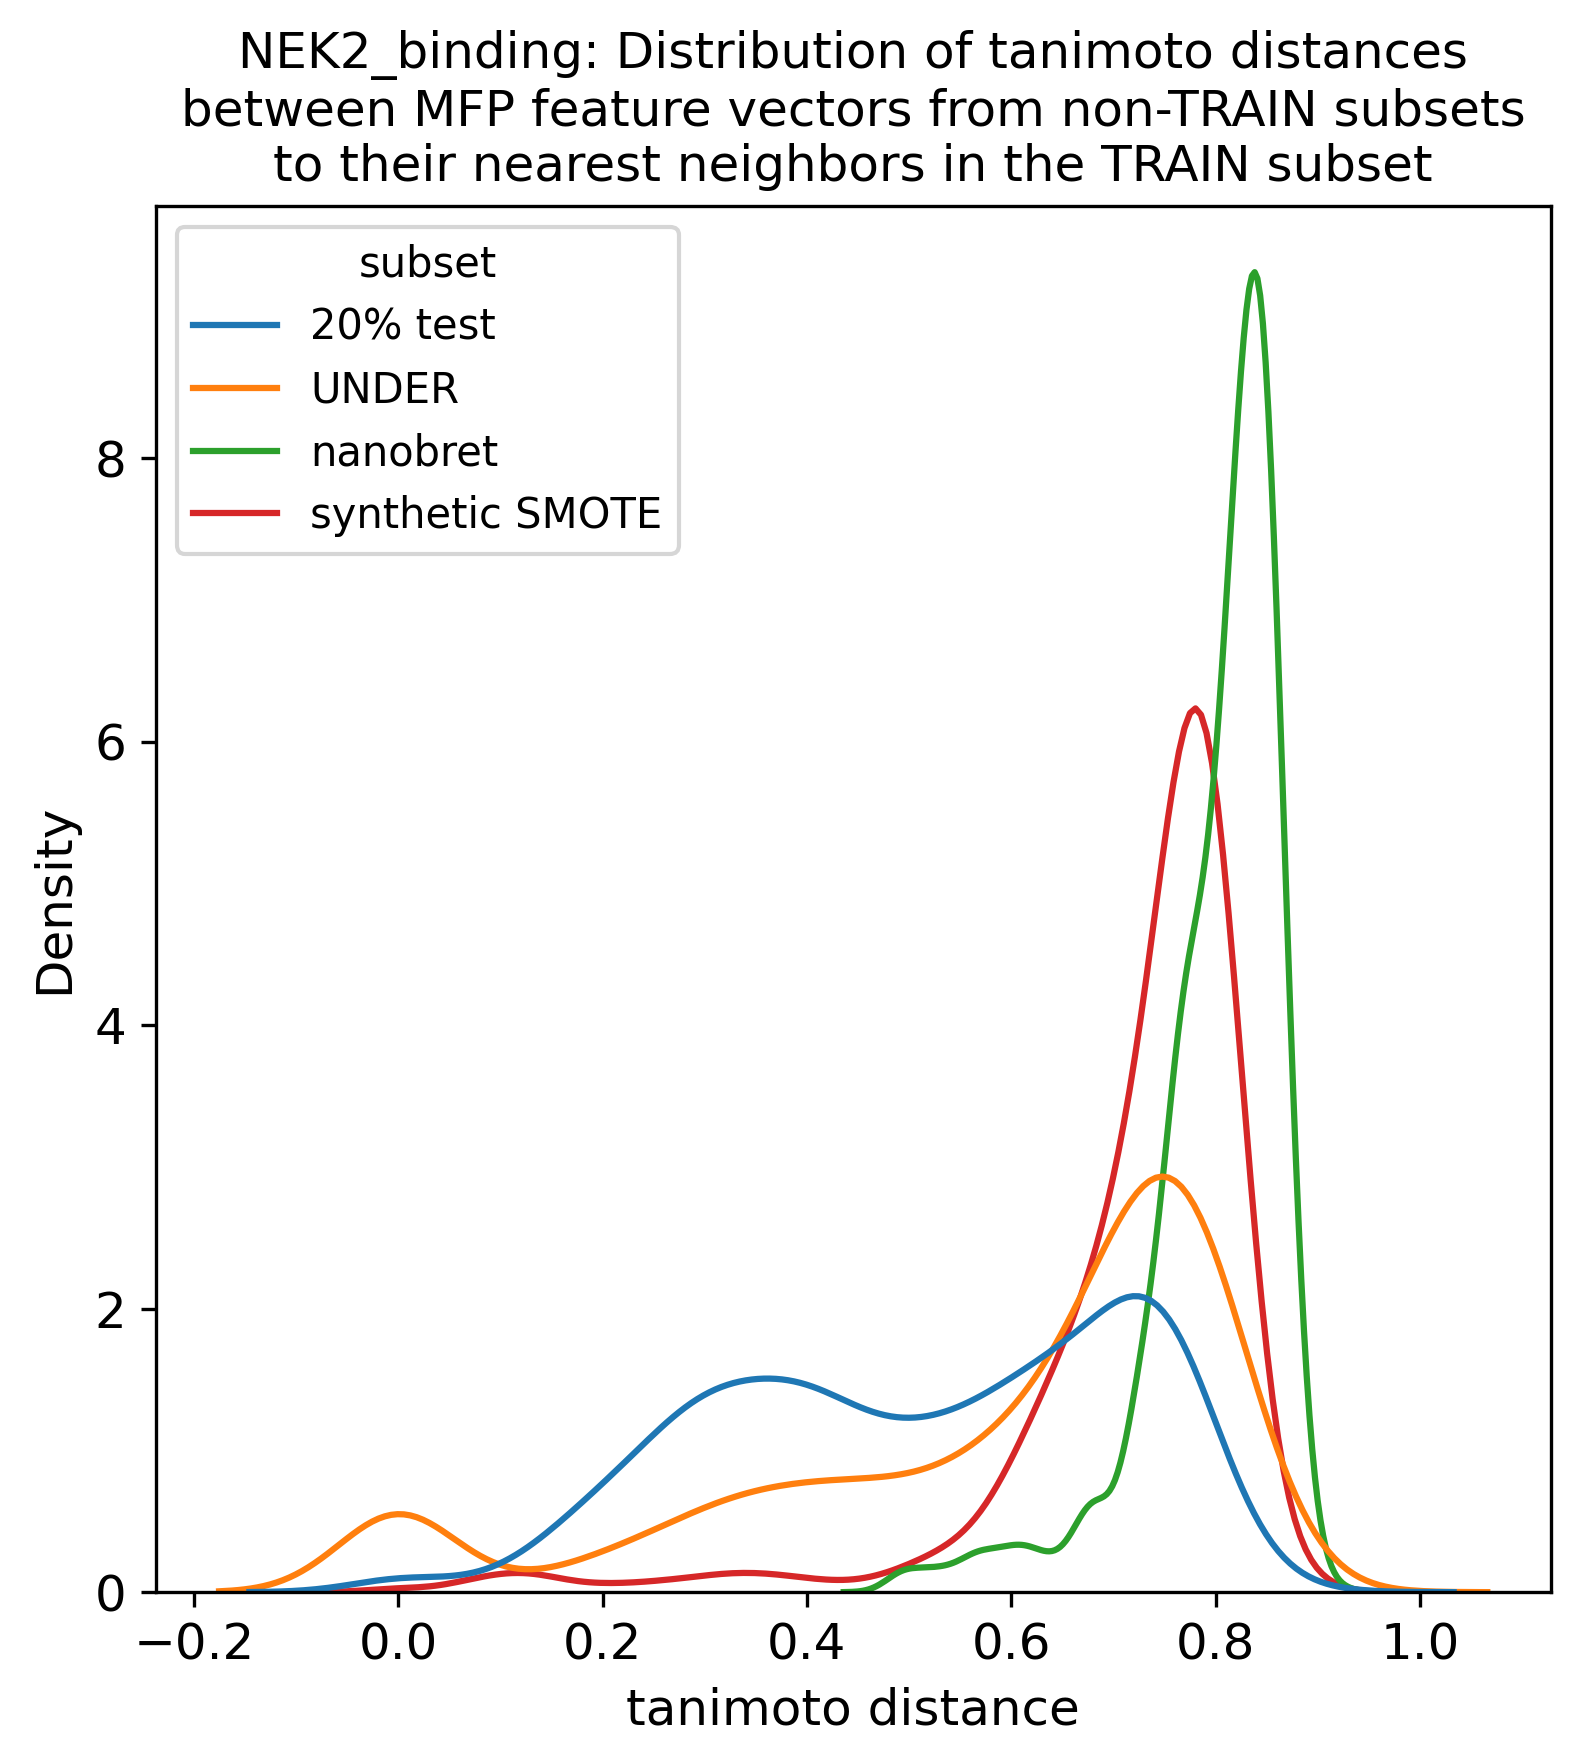

NEK2_inhibition
subset
train              1625
synthetic SMOTE    1401
20% test            407
nanobret            400
UNDER               224
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


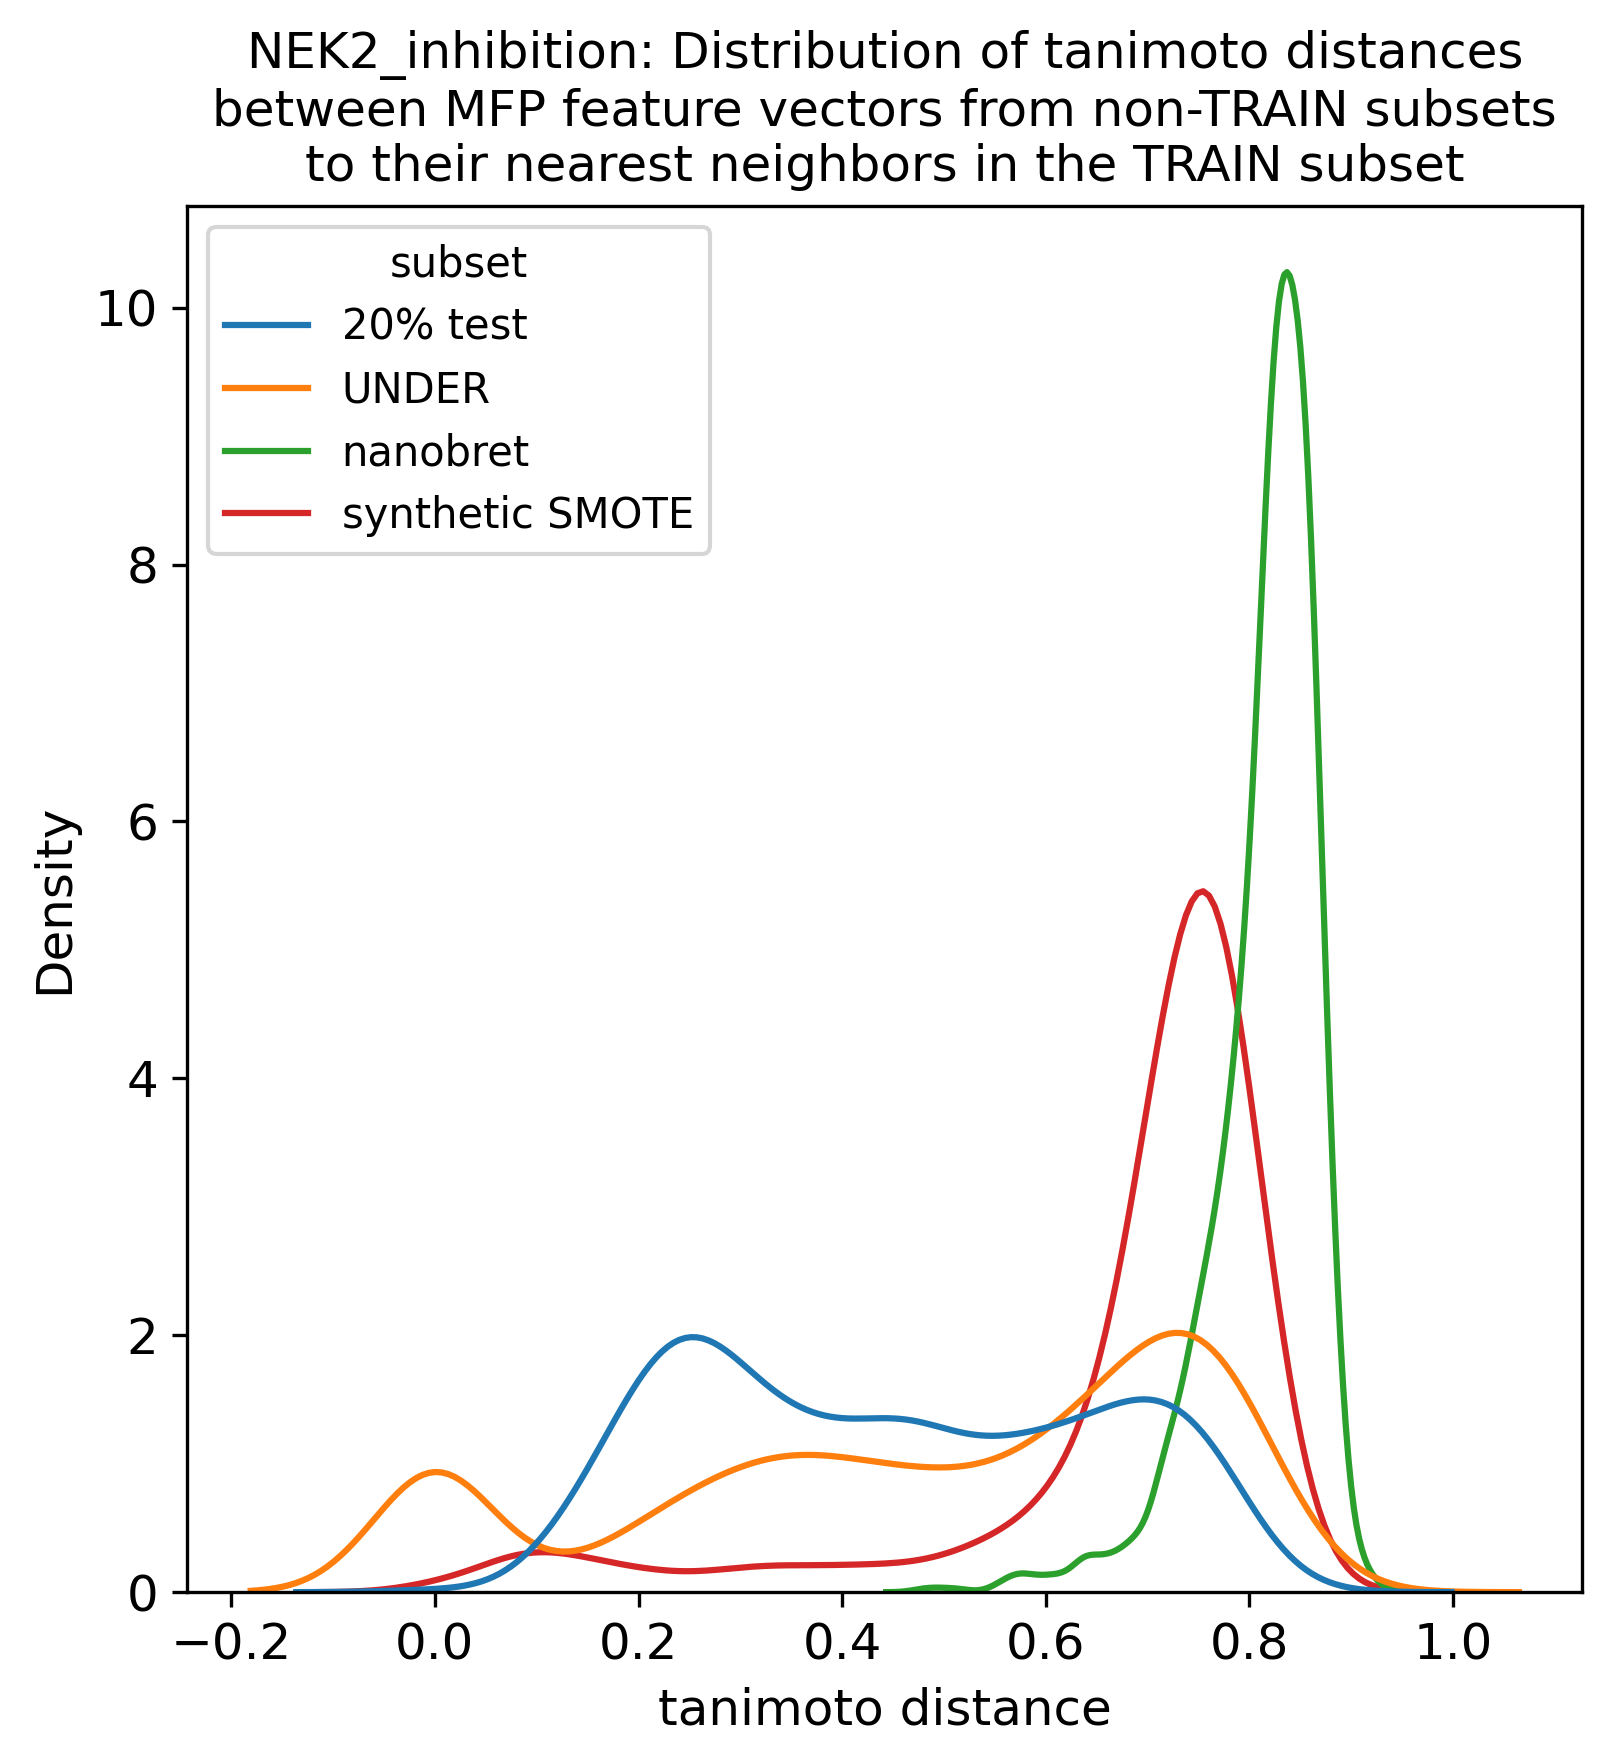

NEK3_binding
subset
train              1122
synthetic SMOTE     994
nanobret            400
20% test            282
UNDER               128
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


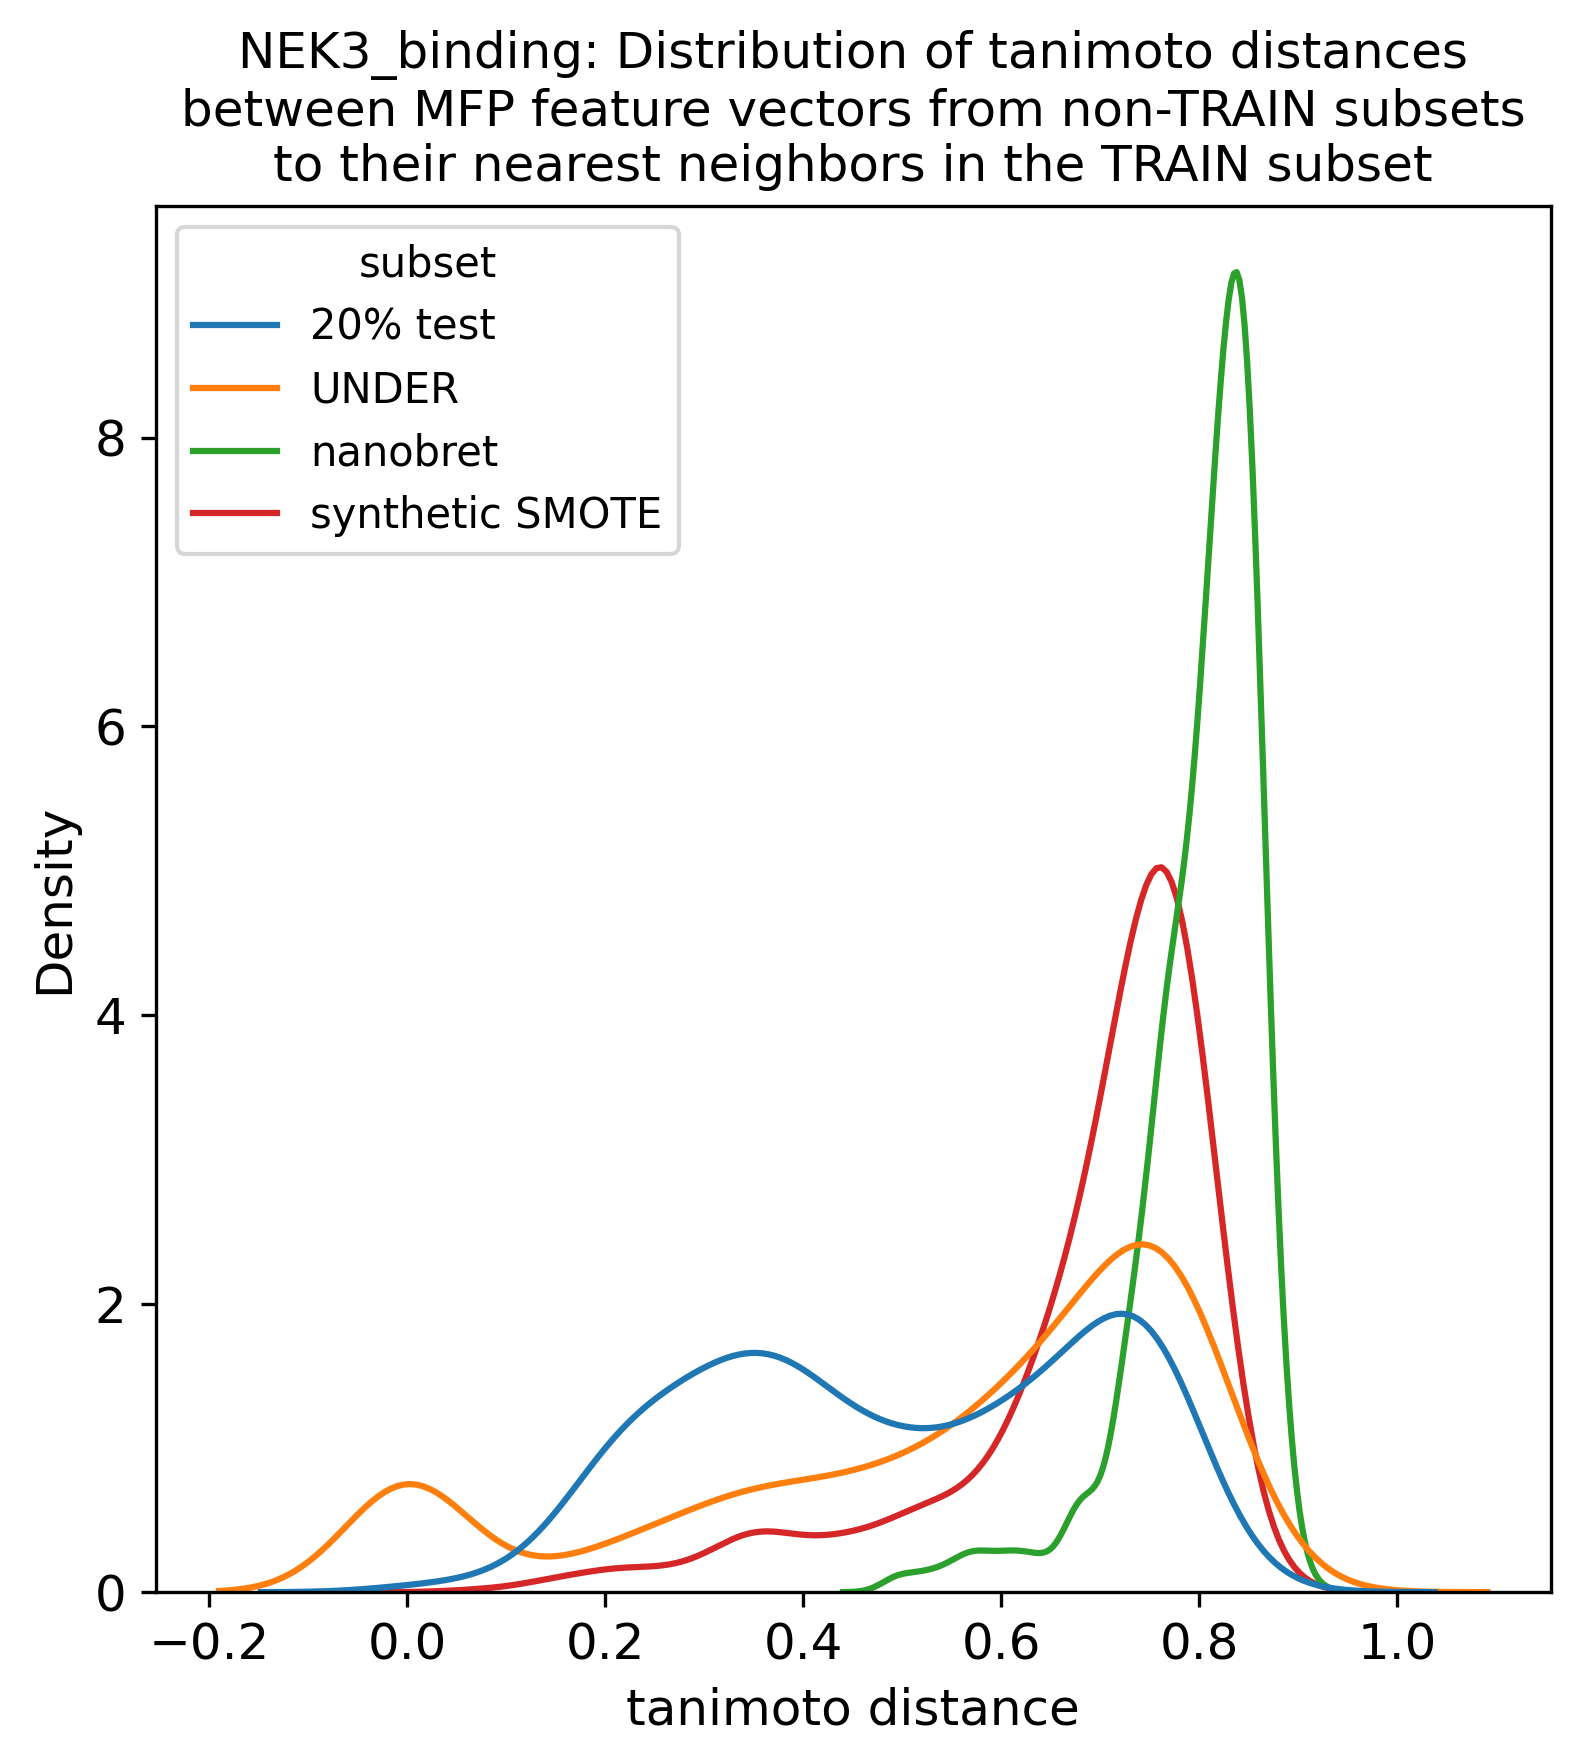

NEK5_binding
subset
train              989
synthetic SMOTE    835
nanobret           400
20% test           248
UNDER              154
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


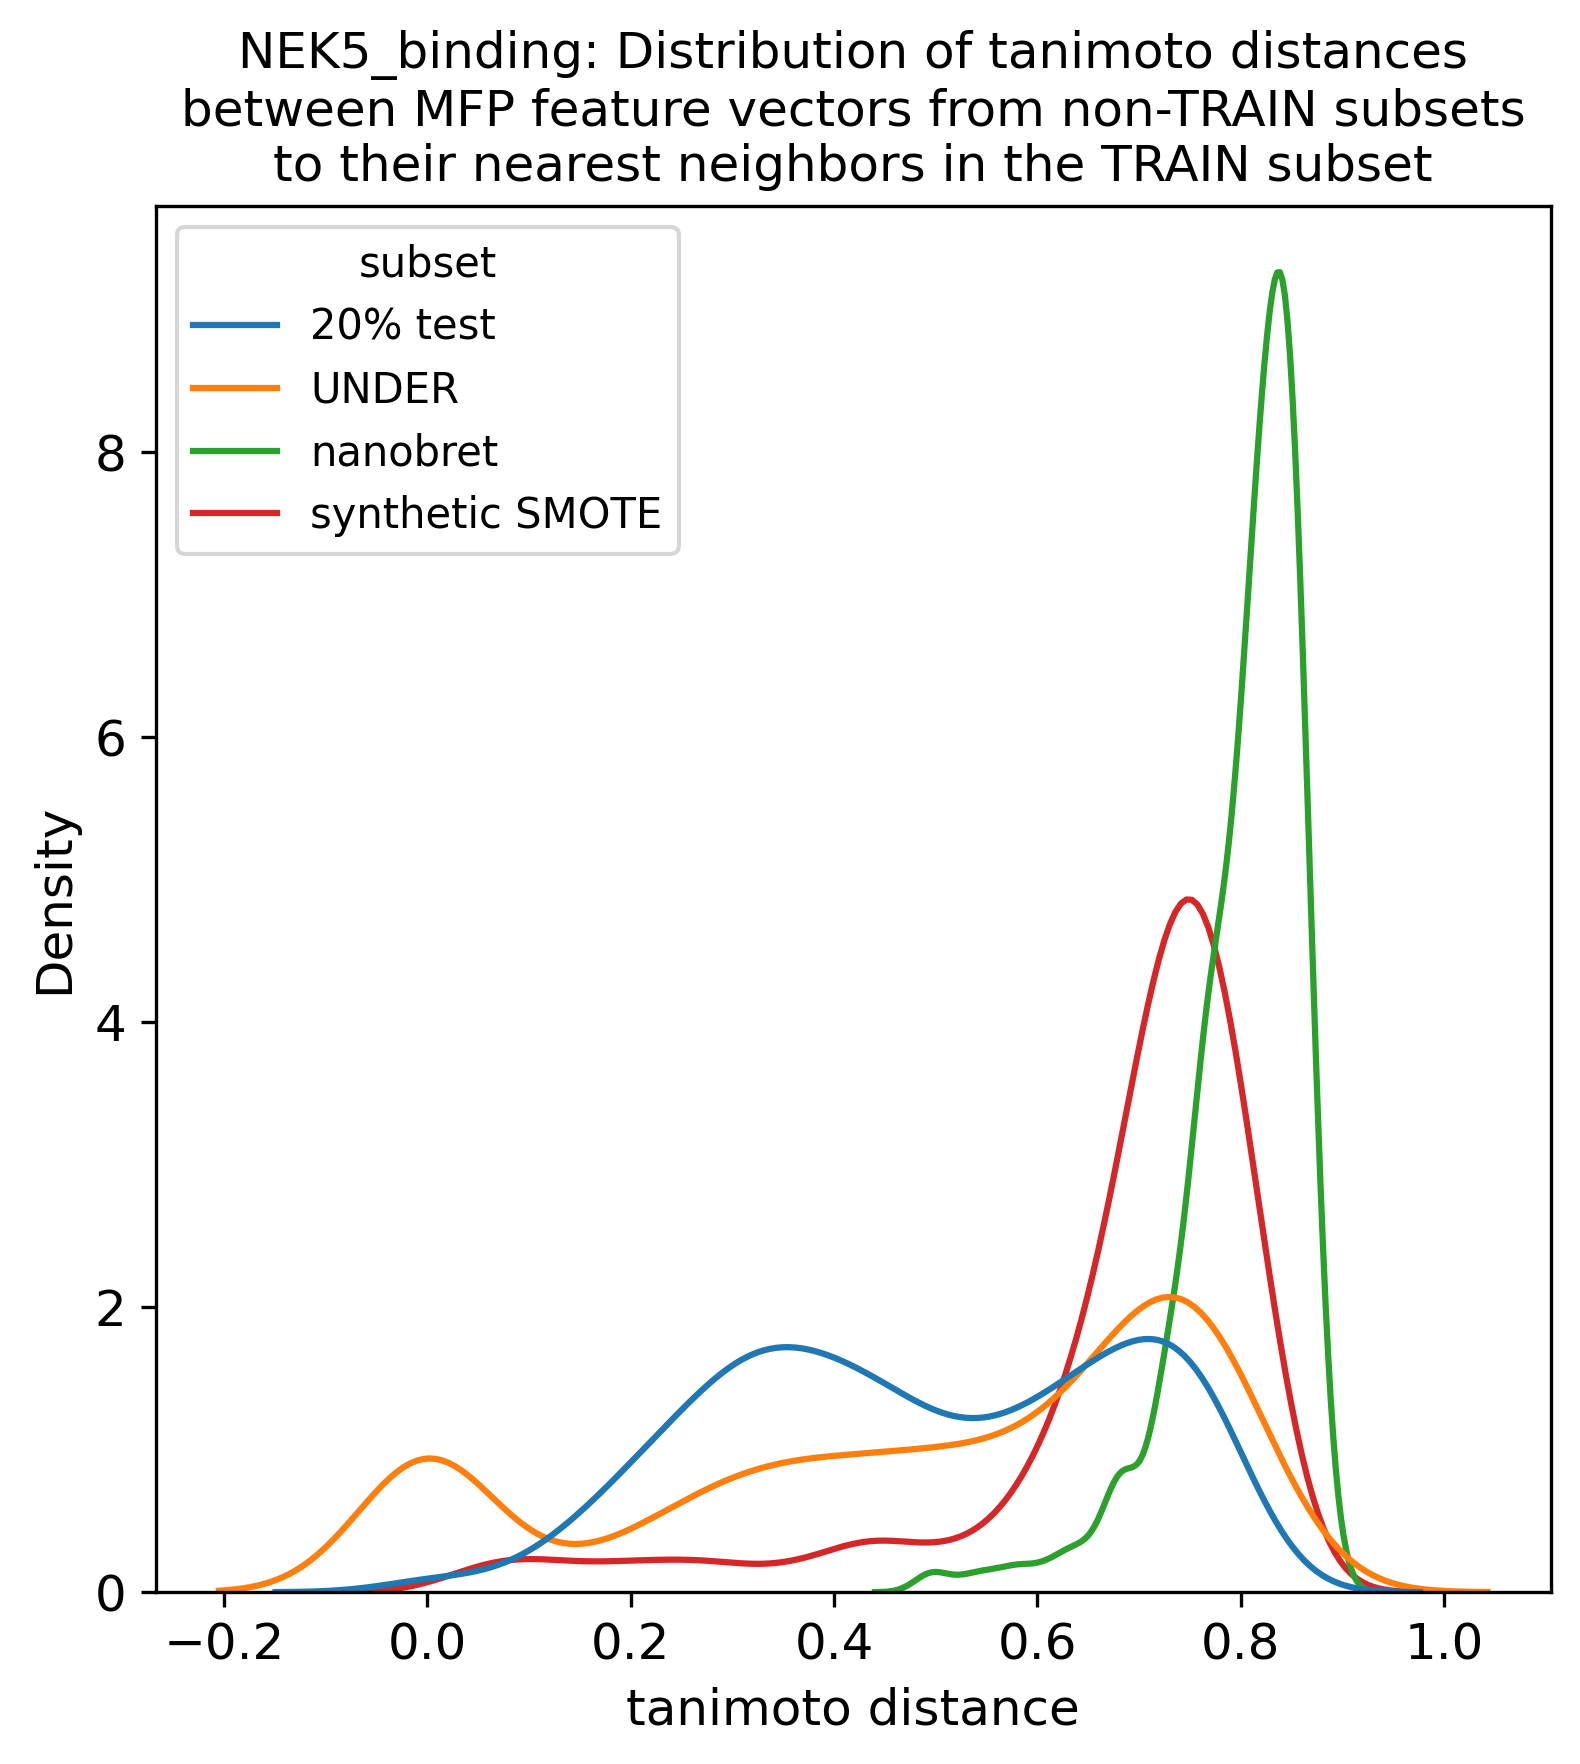

NEK9_binding
subset
train              1126
synthetic SMOTE    1030
nanobret            400
20% test            283
UNDER                96
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


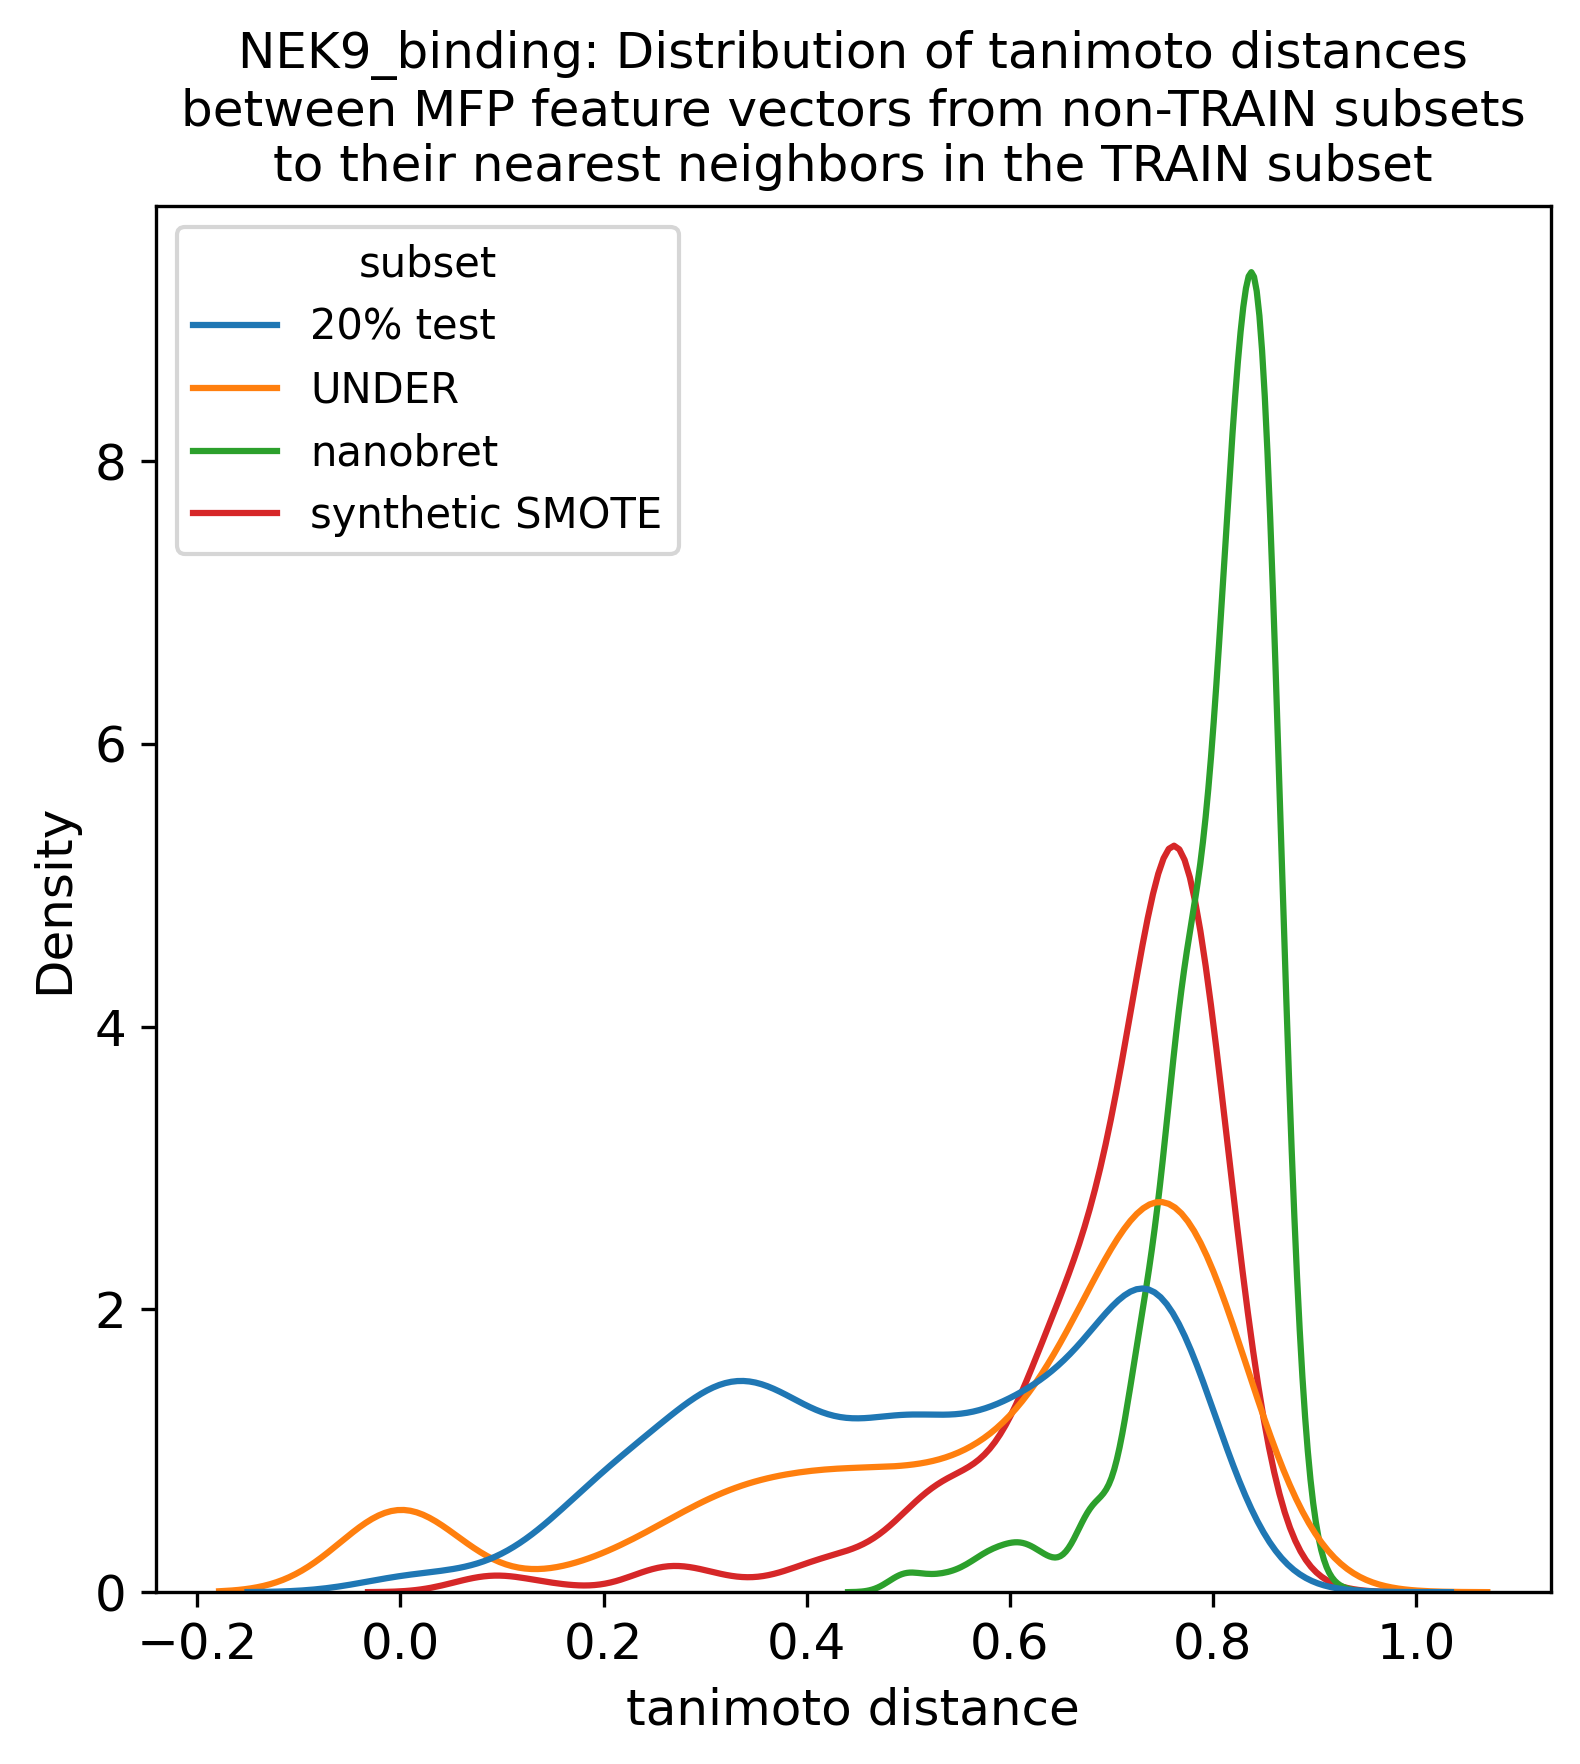

NEK9_inhibition
subset
nanobret           400
train              313
synthetic SMOTE    247
20% test            80
UNDER               66
Name: count, dtype: int64
20% test
UNDER
nanobret
synthetic SMOTE


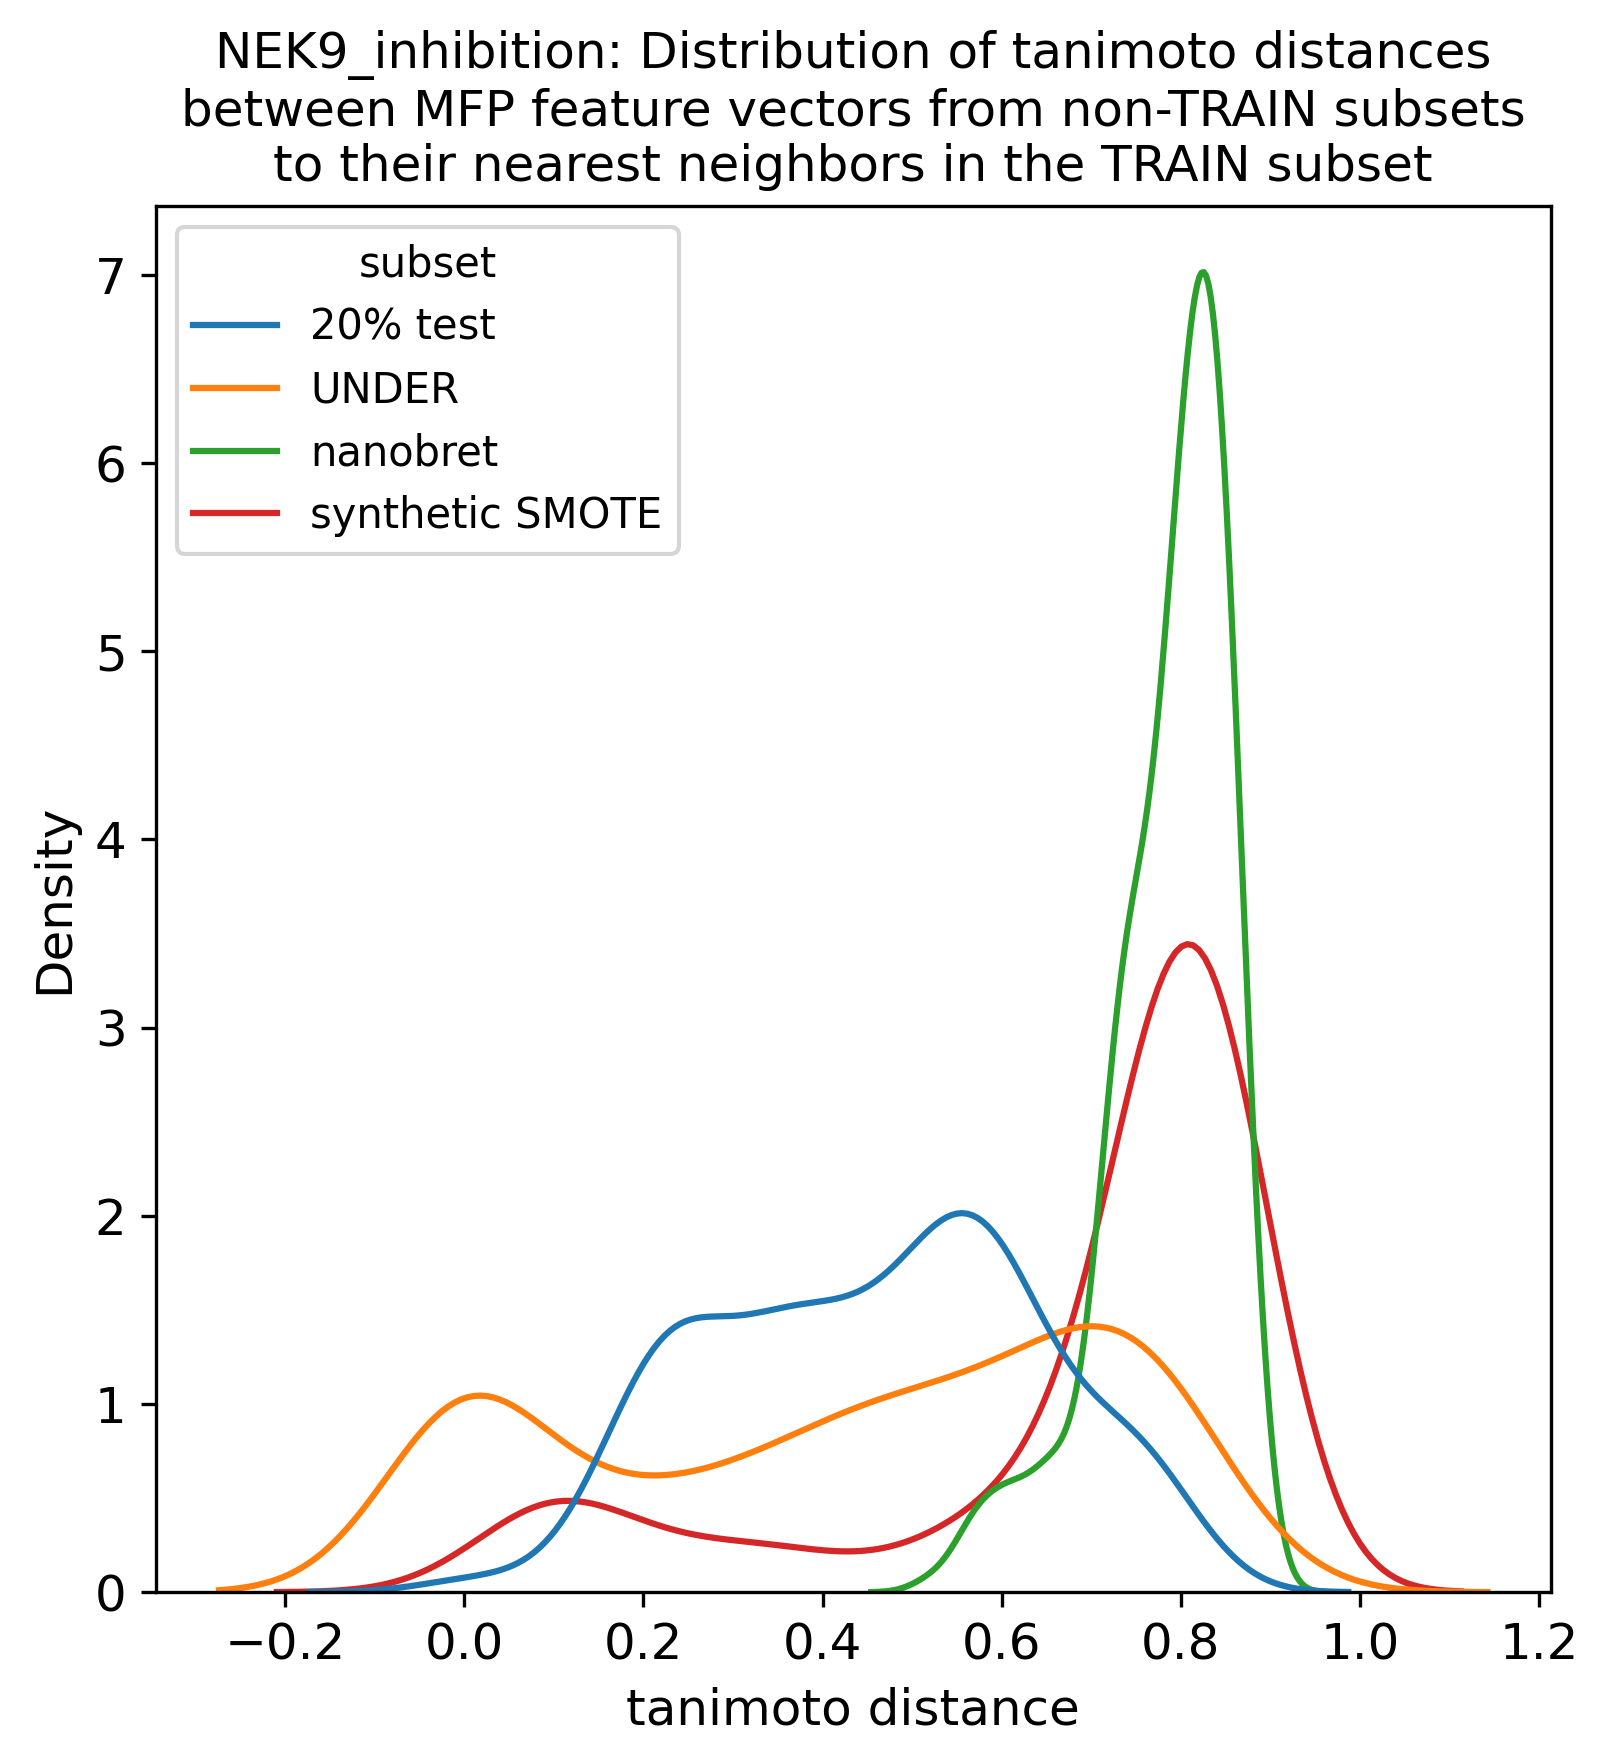

In [25]:
# common_cols = ['base_rdkit_smiles', 'compound_id', 'fold', 'active', 'subset']
common_cols = ['base_rdkit_smiles', 'active', 'subset']
figpath=''
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{og_datapath}{nek}_MFP_none_scaled.csv') # entire train set
    og_test= mfp_desc[mfp_desc['subset']=='test'] # holdout set 1
    og_test['subset'] ='20% test'
    og_train = mfp_desc[mfp_desc['subset']=='train'] # train set
    num_train = og_train.shape[0]
    # display(og_train)
    for new_nek in new_neks: 
        if nek[:4] == new_nek:
            new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
            holdout_df = new_nek_df[new_nek_df['subset'] == 'test'] # holdout set 2
            holdout_df['subset'] = 'nanobret'
            mfp_under = pd.read_csv(f'{og_datapath}{nek}_MFP_UNDER.csv')
            under = mfp_under[mfp_under['subset'] == 'train']
            under['subset'] = 'UNDER' 
        
            original_compounds = pd.concat([og_test,og_train, under, holdout_df])
            original_compounds= original_compounds.rename(columns=mfp_dict)
            
        
            mfp_smote = pd.read_csv(f'{og_datapath}{nek}_MFP_SMOTE.csv') 
            mfp_smote= mfp_smote.rename(columns=mfp_dict)
            smote_train =mfp_smote[mfp_smote['subset'] == 'train'].copy()
            new_smote=smote_train.iloc[num_train:].copy()
            new_smote['subset'] = 'synthetic SMOTE'
        
        
            df_all = pd.concat([original_compounds, new_smote])
            print(df_all['subset'].value_counts())
            
            dists,fig,ax=plot_tani_dist_distr(df_all, 'base_rdkit_smiles', this_nek, ref_subset='train',radius=2, subsets=True, featurized=True)
            fig.savefig(f'{nek}_tanimoto_dists_from_train.png', bbox_inches='tight',dpi=300)



In [37]:
color_palette = {'20% test': 'tab:blue', 'UNDER': 'tab:orange', 'nanobret': 'tab:green', 'synthetic SMOTE':'tab:red'}
def plot_tani_dist_distr2(df, smiles_col, df_name, radius=2, featurized=False, subset_col='subset', subsets=False, ref_subset='train', plot_width=6, ndist_max=None, **metric_kwargs):
    log = logging.getLogger('ATOM')
    
    num_cmpds = len(df)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        if not featurized:
            dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
        else:
            fprints1_df = df[[col for col in df.columns if 'ecfp' in col]]
            fprints1=df_to_bitvect(fprints1_df)
            fprints2 = None
            within_dset = True
            dists=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
            
        # flatten dists
        dists = dists.flatten()
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset:
                continue
            if not featurized:
                smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
                smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
                diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
            else:
                fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
                fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
                print(subs)
                
                fprints1=df_to_bitvect(fprints1_df)
                fprints2=df_to_bitvect(fprints2_df)
                

                within_dset=False
                diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
    
            # flatten dists
            diststmp = diststmp.flatten()
    
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist',subset_col])
            dists=pd.concat([dists,diststmp])

    
    dists=dists.reset_index(drop=True)
    fig, ax = plt.subplots(1, figsize=(plot_width, plot_width), dpi=300)
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue=subset_col, legend=True, 
                palette= color_palette,common_norm=False, common_grid=False, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')

    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name}: Distribution of {dist_metric} distances\nbetween MFP feature vectors from non-{ref_subset.upper()} subsets\nto their nearest neighbors in the {ref_subset.upper()} subset\n (Active Samples Only)")
    plt.show(); 
    return dists, fig, ax

NEK2_binding
subset
synthetic SMOTE    1035
train                45
nanobret             31
20% test             12
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


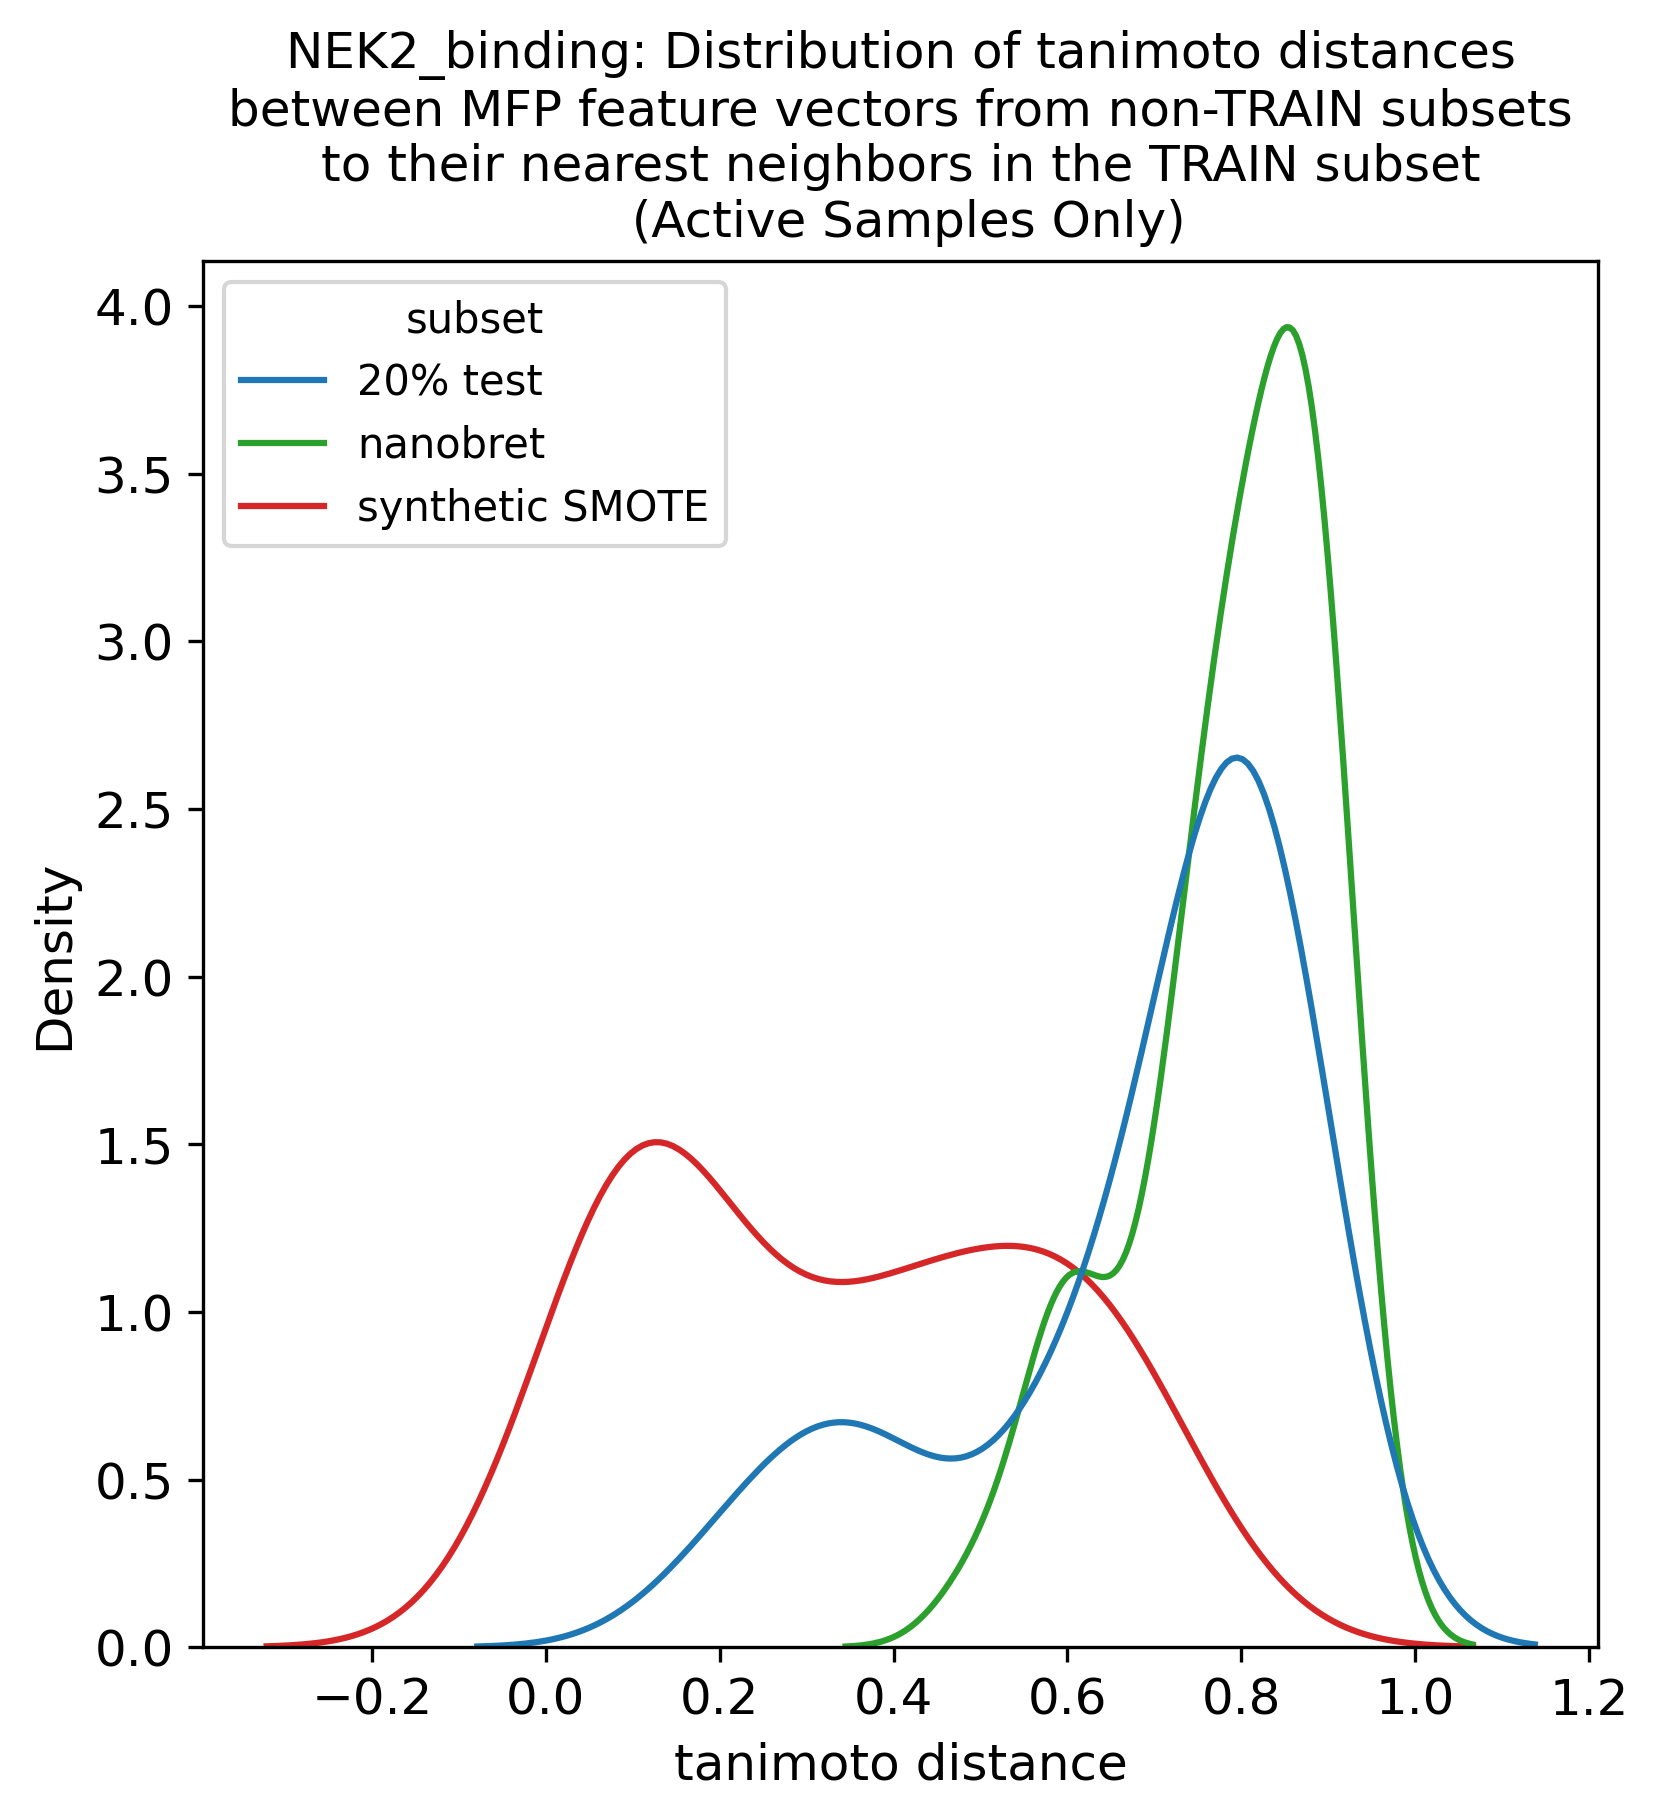

NEK2_inhibition
subset
synthetic SMOTE    1401
train               112
nanobret             31
20% test             28
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


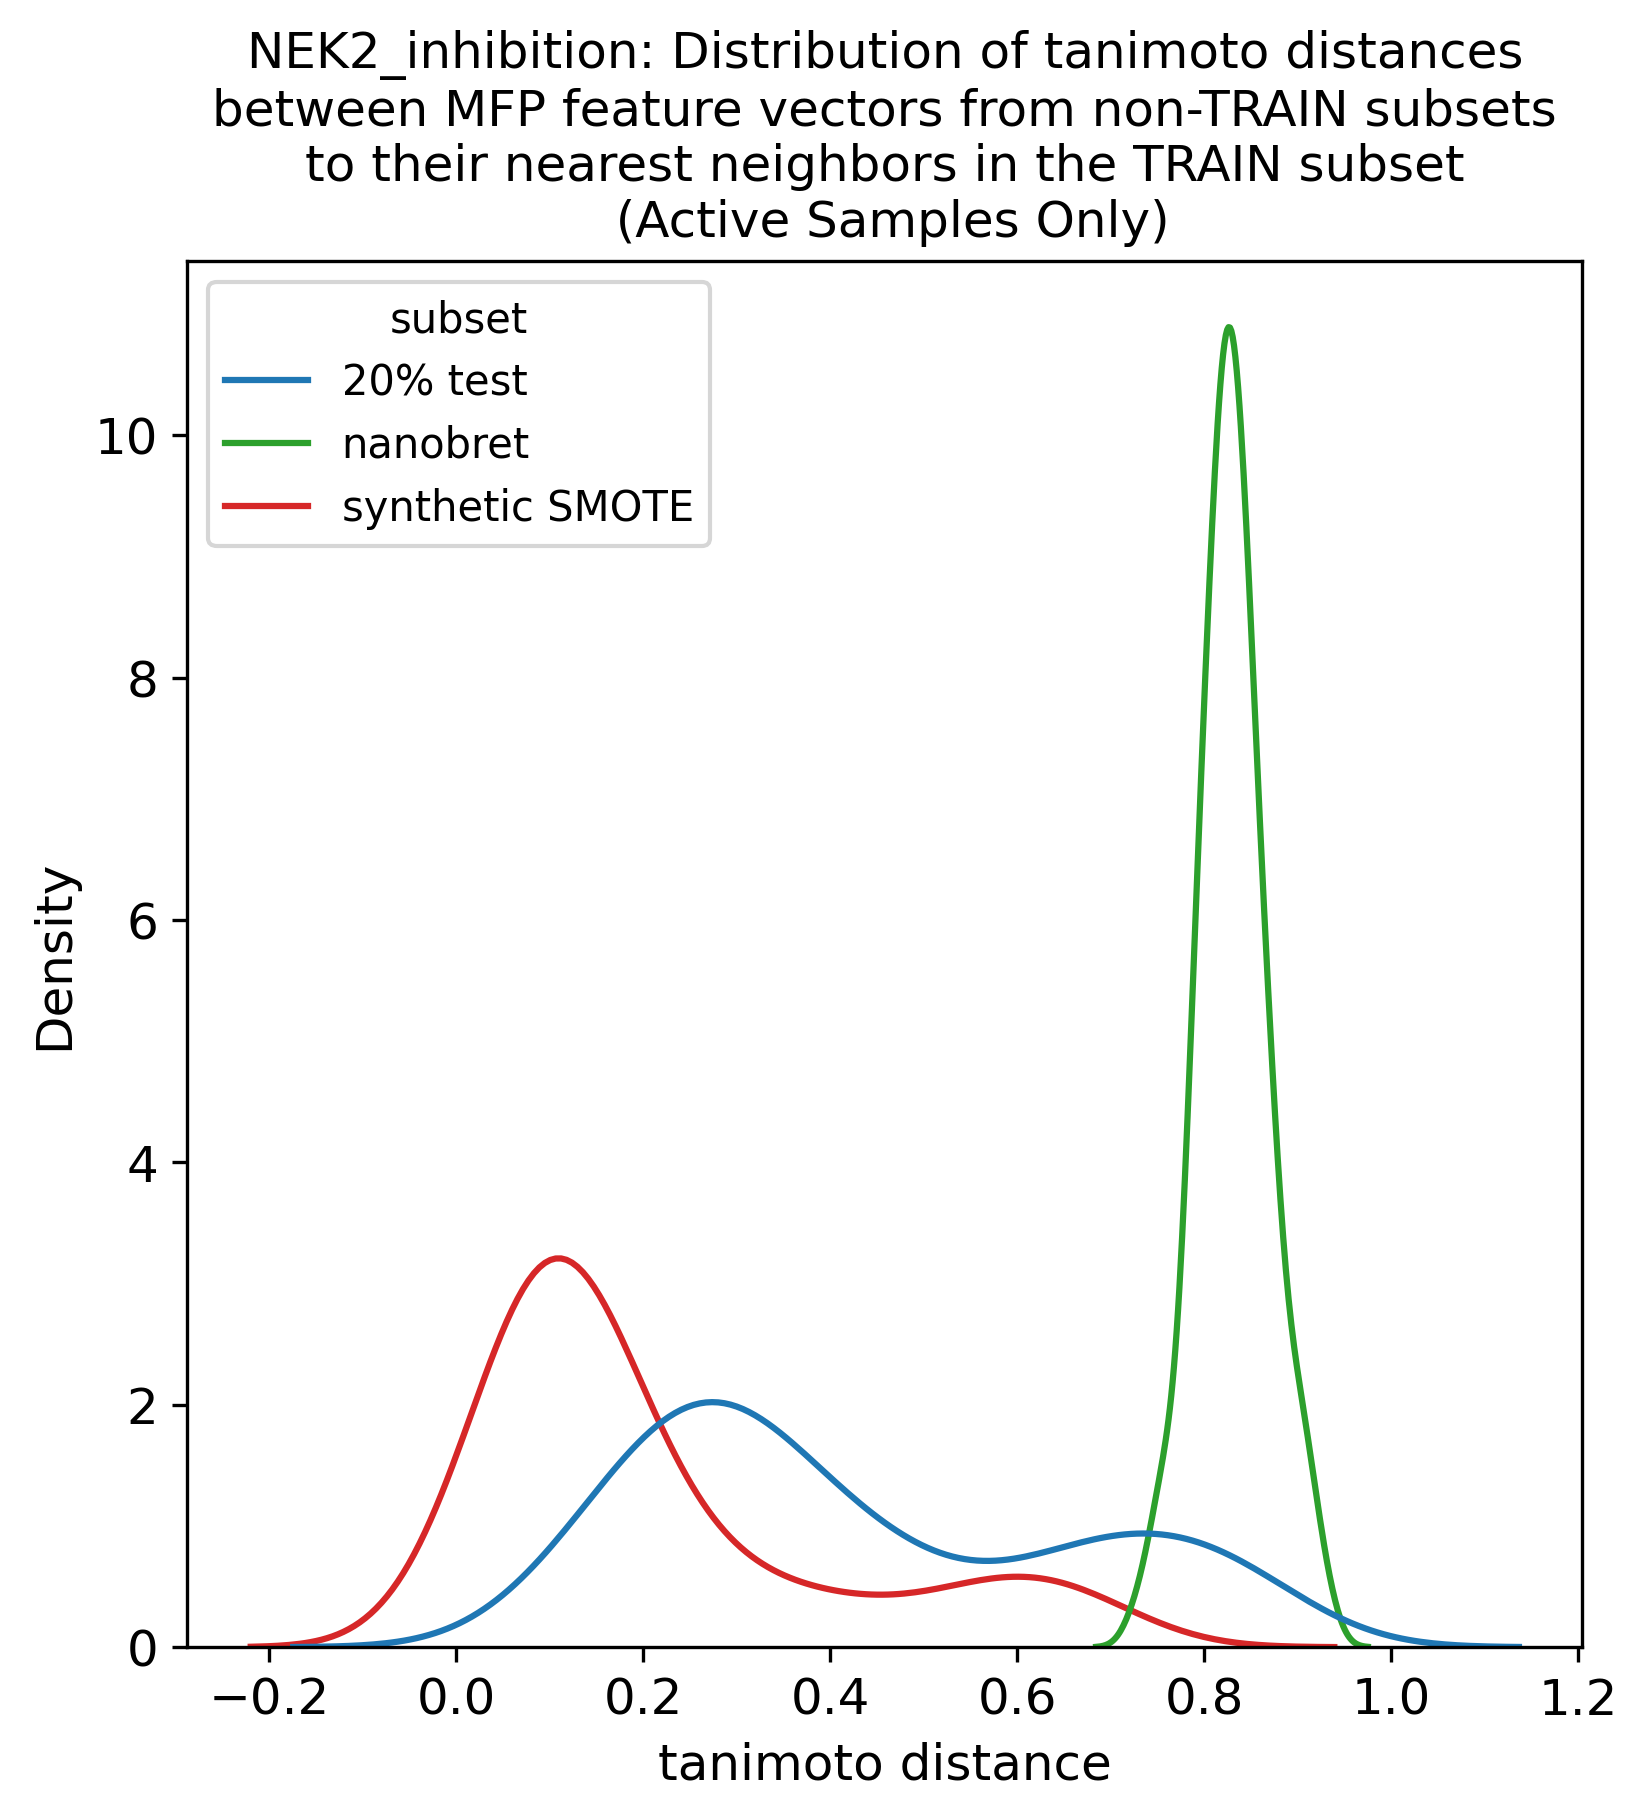

NEK3_binding
subset
synthetic SMOTE    994
train               64
nanobret            28
20% test            17
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


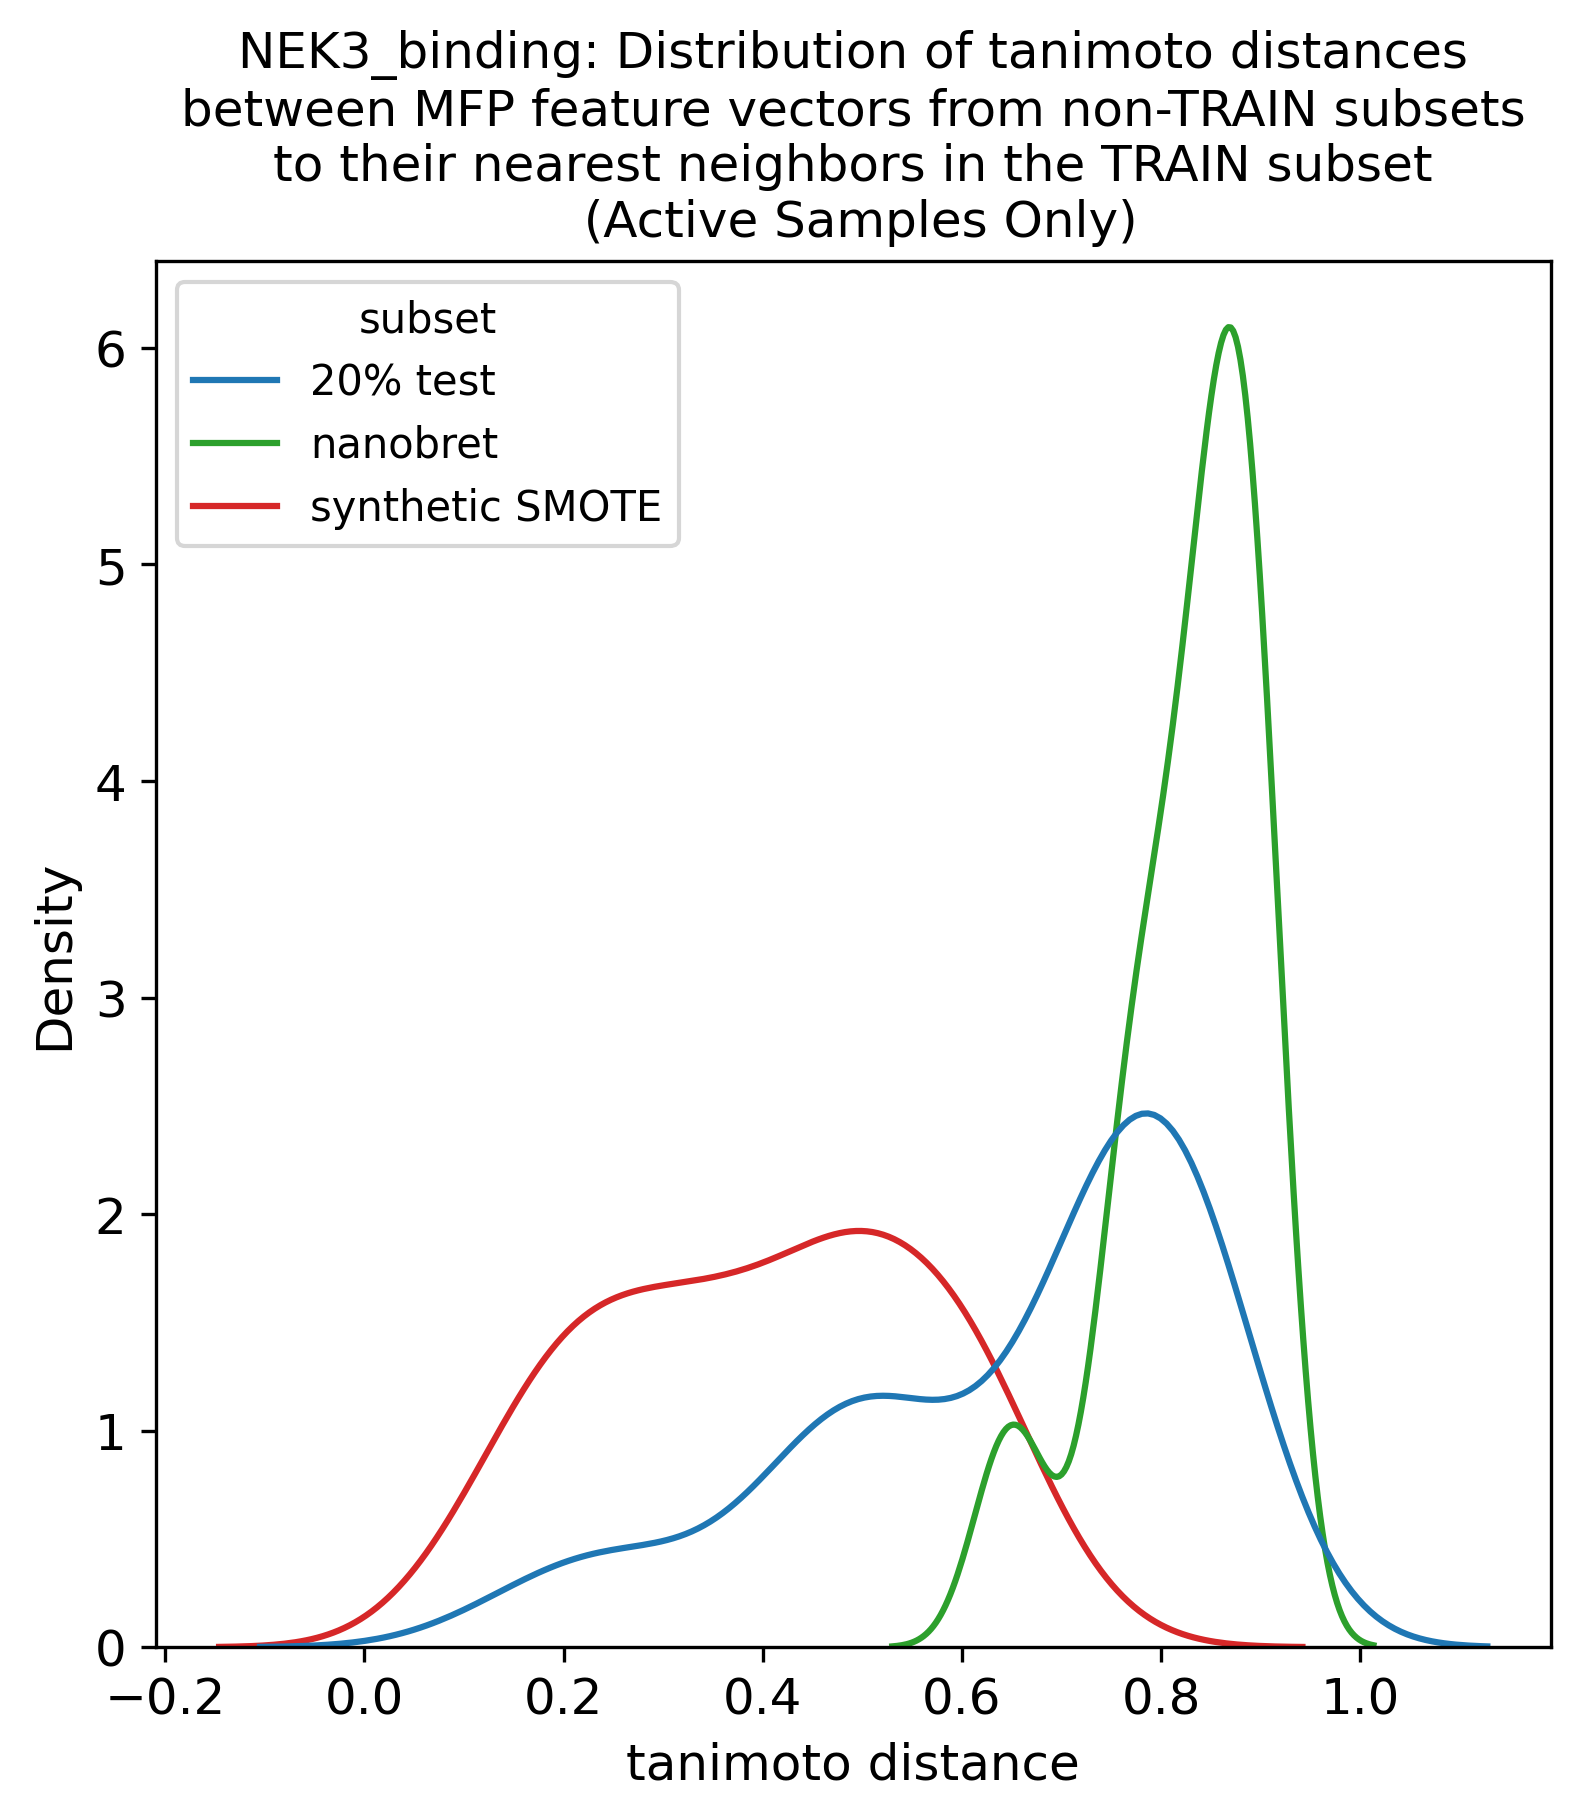

NEK5_binding
subset
synthetic SMOTE    835
nanobret            80
train               77
20% test            20
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


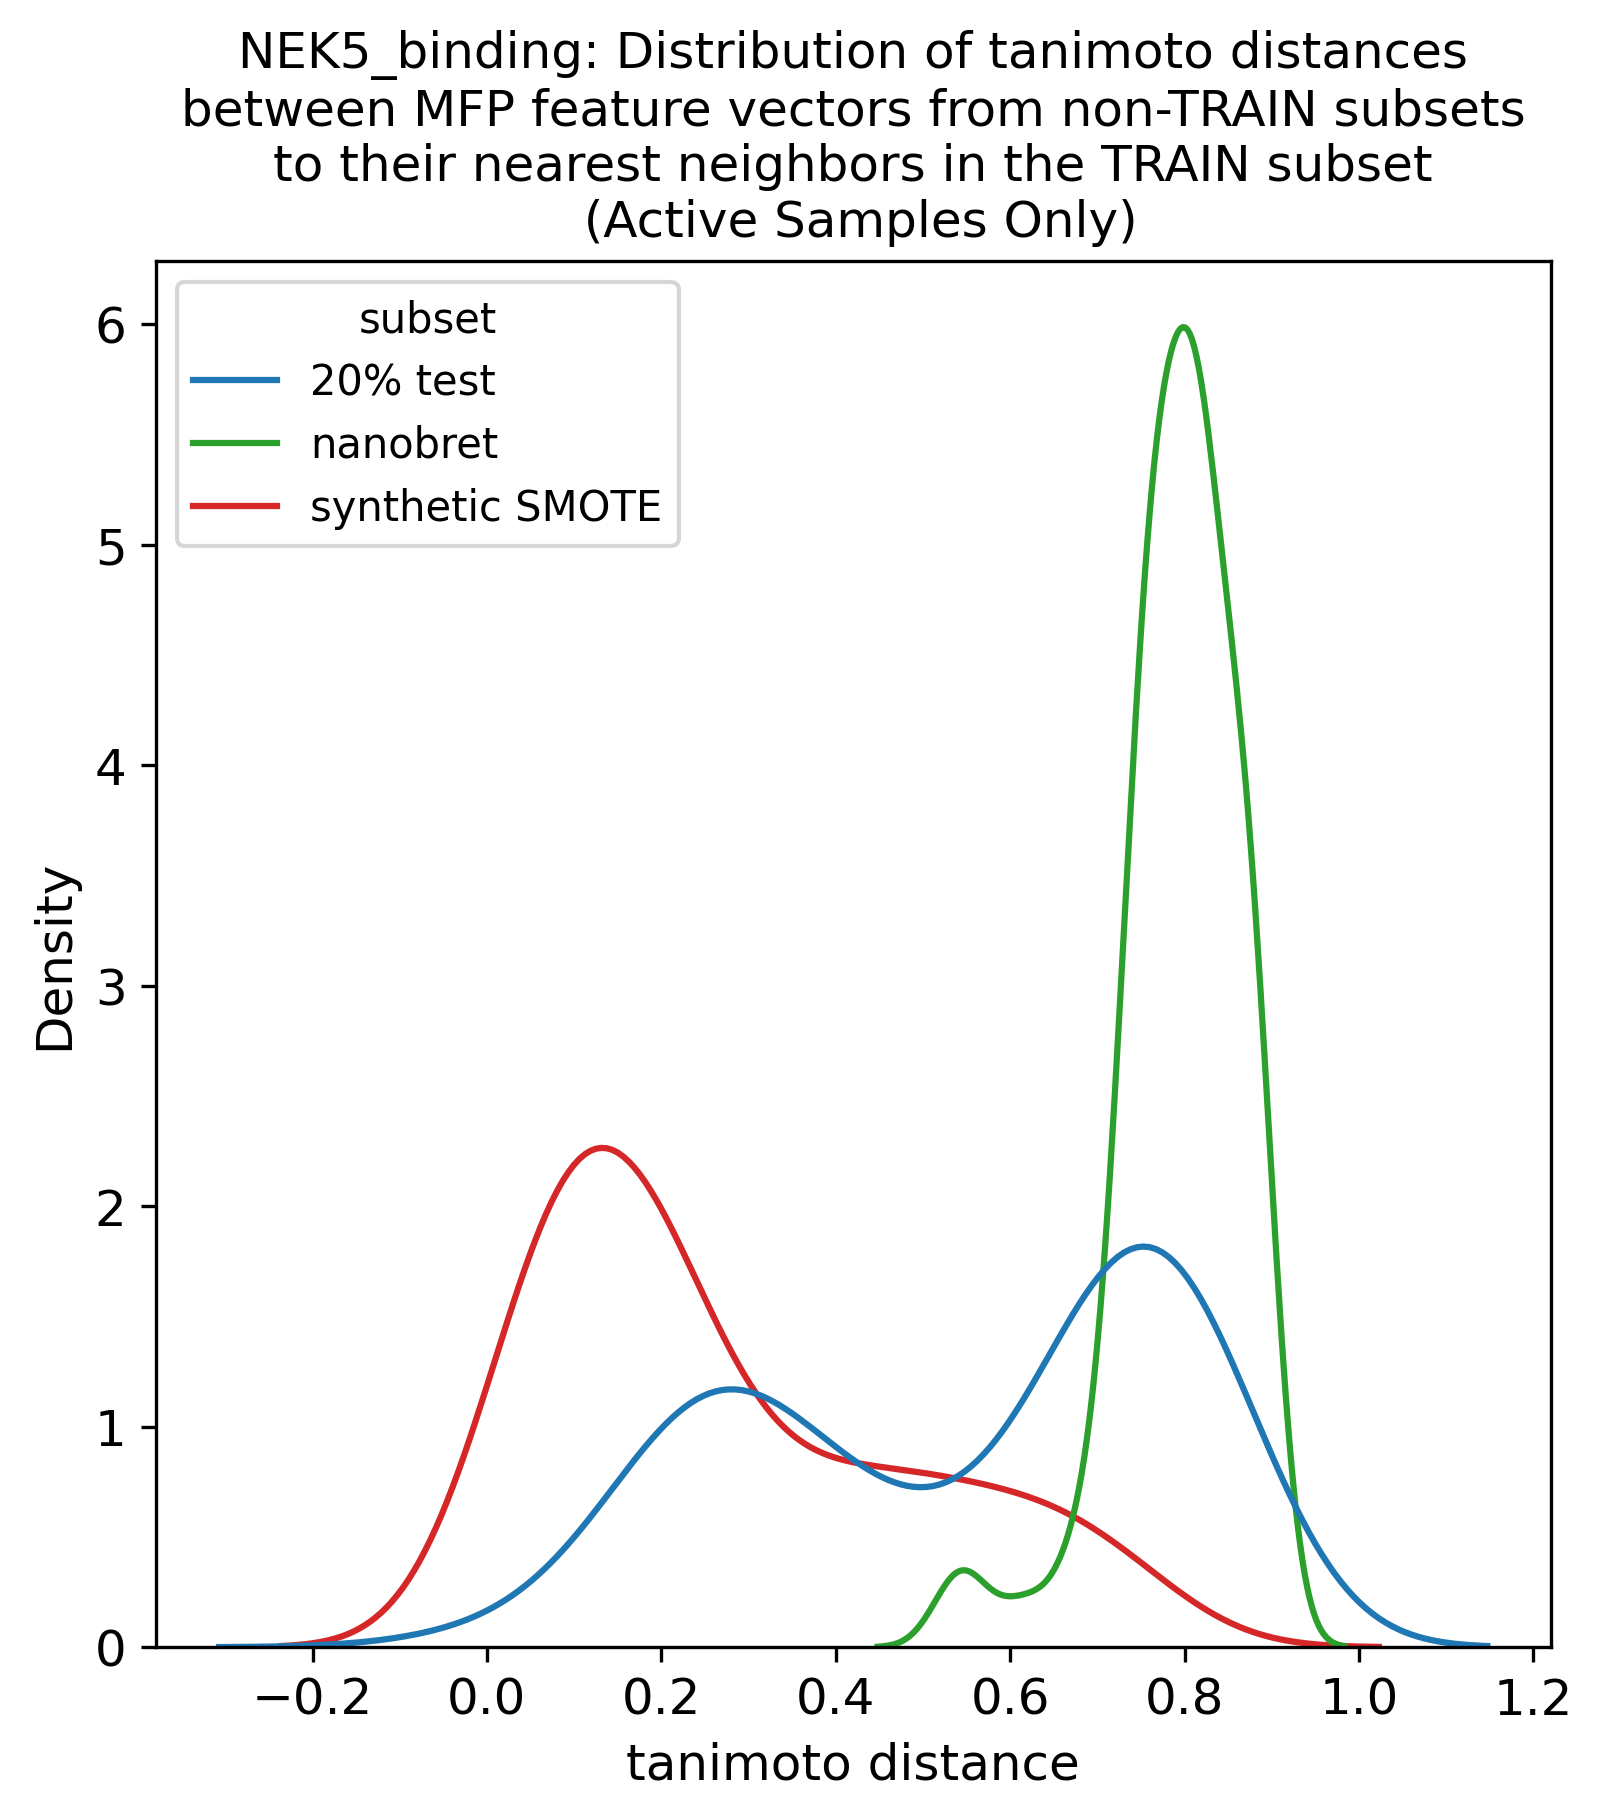

NEK9_binding
subset
synthetic SMOTE    1030
train                48
nanobret             34
20% test             13
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


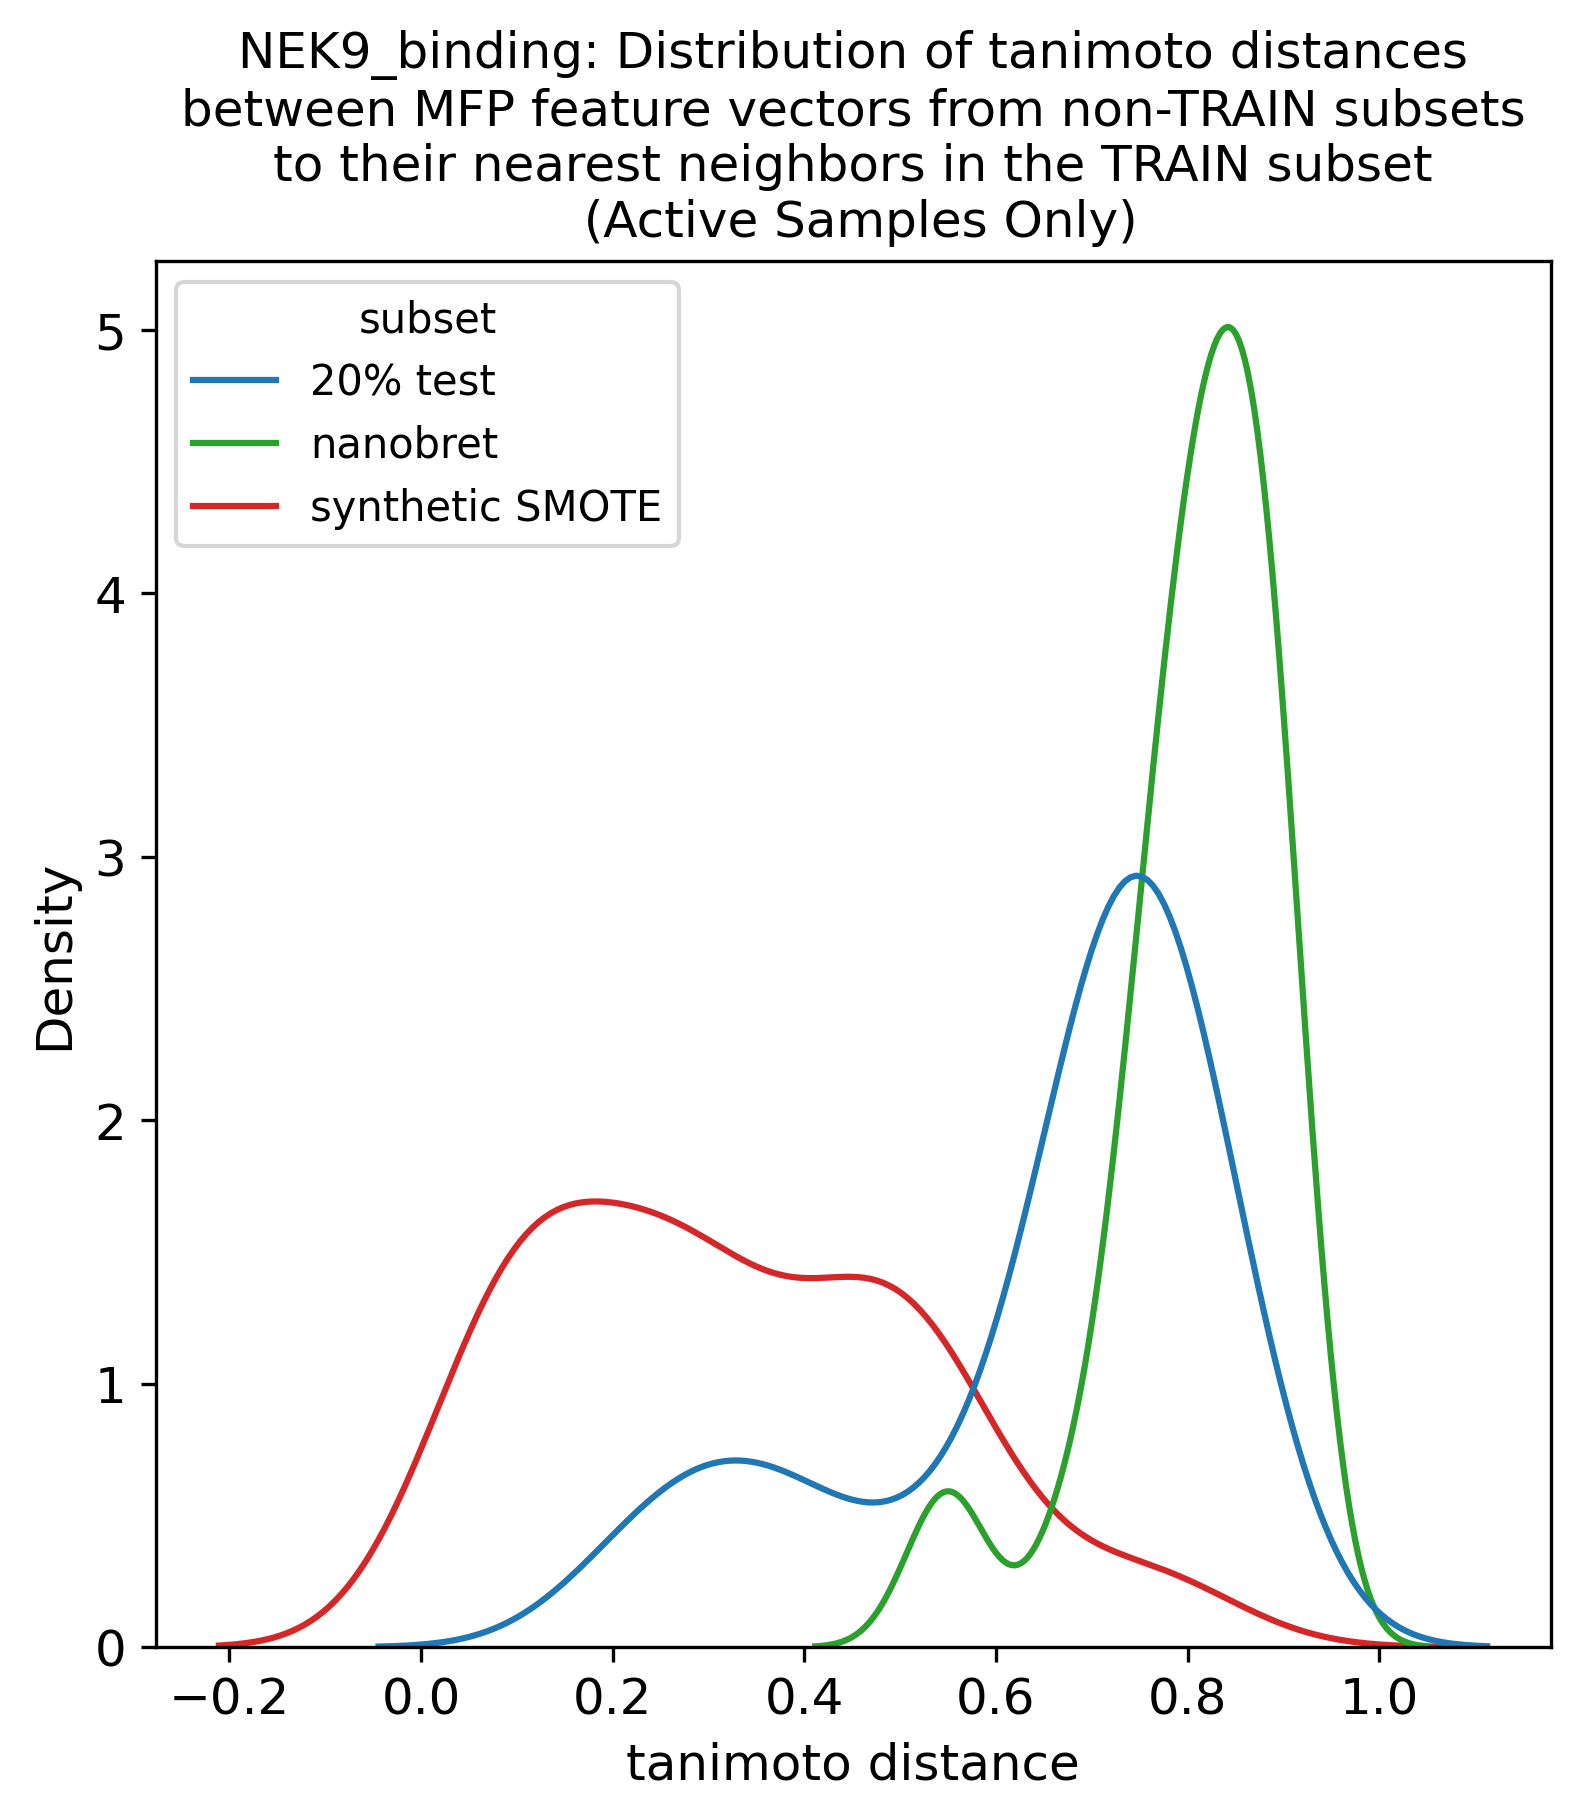

NEK9_inhibition
subset
synthetic SMOTE    247
nanobret            34
train               33
20% test             9
Name: count, dtype: int64
20% test
nanobret
synthetic SMOTE


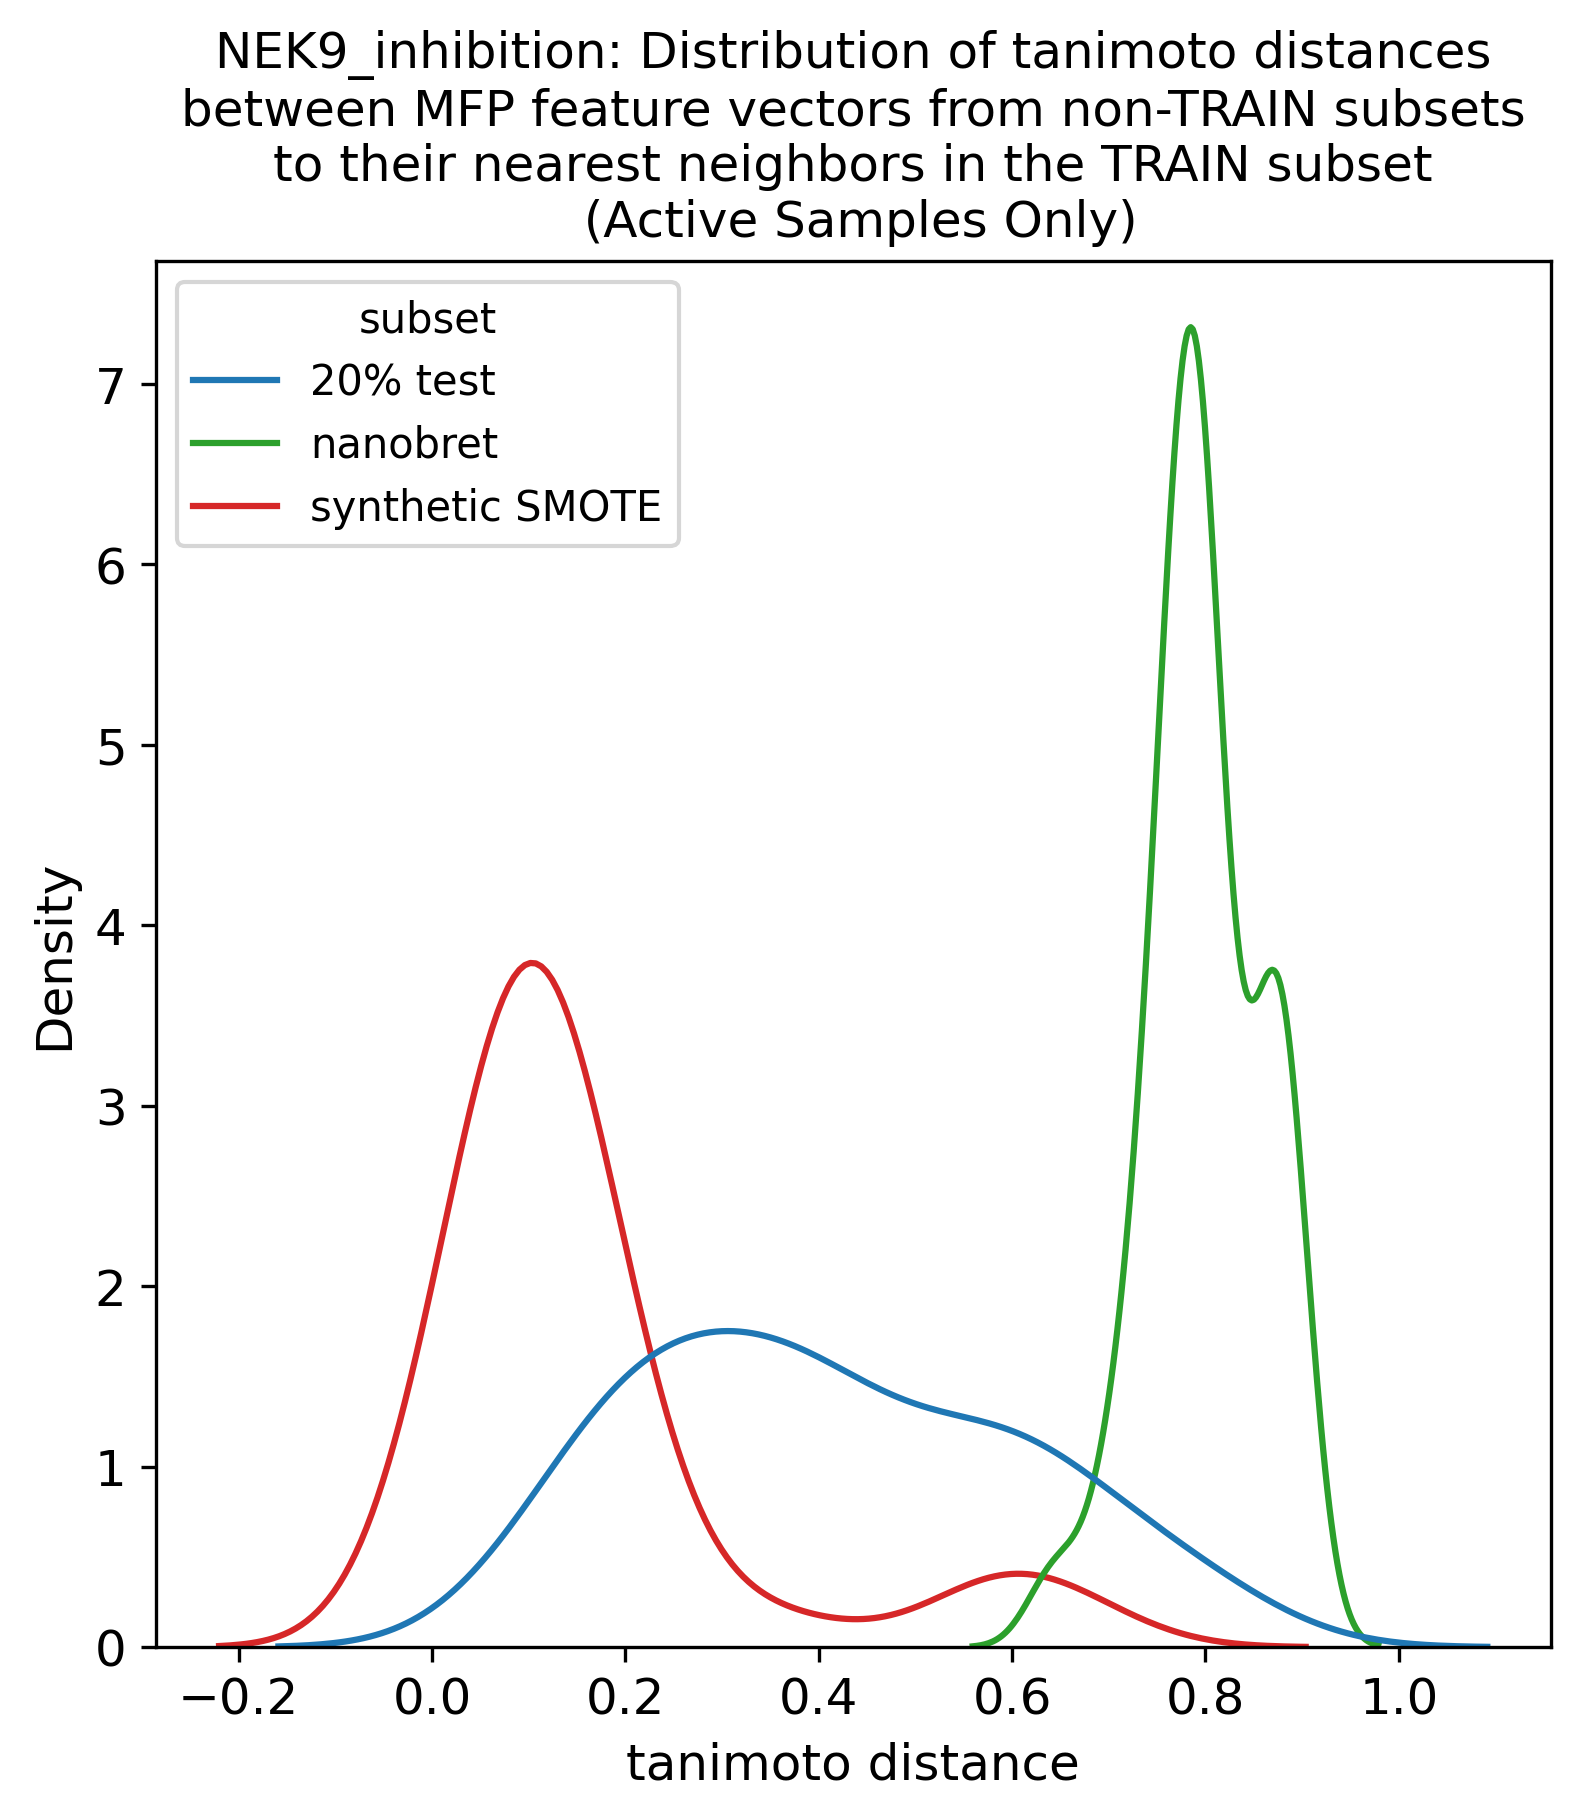

In [39]:
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{og_datapath}{nek}_MFP_none_scaled.csv') # entire train set
    # og_test= mfp_desc[(mfp_desc['subset']=='test') & (mfp_desc['active']==1)]
    og_test_all = mfp_desc[mfp_desc['subset']=='test']
    og_test= mfp_desc[(mfp_desc['subset']=='test') & (mfp_desc['active']==1)] # holdout set 1
    og_test['subset'] ='20% test'
    og_train = mfp_desc[(mfp_desc['subset']=='train') & (mfp_desc['active']==1)] # train set
    og_train_all = mfp_desc[mfp_desc['subset']=='train'] 
    num_train = og_train_all.shape[0]

    for new_nek in new_neks: 
        if nek[:4] == new_nek:
            new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
            holdout_df = new_nek_df[(new_nek_df['subset'] == 'test') & (new_nek_df['active']==1)] # holdout set 2
            holdout_df['subset'] = 'nanobret'
        
            original_compounds = pd.concat([og_test,og_train,holdout_df])
            original_compounds= original_compounds.rename(columns=mfp_dict)
            
        
            mfp_smote = pd.read_csv(f'{og_datapath}{nek}_MFP_SMOTE.csv') 
            mfp_smote= mfp_smote.rename(columns=mfp_dict)
            smote_train =mfp_smote[mfp_smote['subset'] == 'train'].copy()
            new_smote=smote_train.iloc[num_train:].copy()
            new_smote['subset'] = 'synthetic SMOTE'
        
        
            df_all = pd.concat([original_compounds, new_smote])
 
            print(df_all['subset'].value_counts())
            
            dists,fig,ax=plot_tani_dist_distr2(df_all, 'base_rdkit_smiles', this_nek, ref_subset='train',radius=2, subsets=True, featurized=True)
            fig.savefig(f'{nek}_tanimoto_dists_from_train_actives_only.png', bbox_inches='tight',dpi=300)



NEK2_binding
subset
train       1125
nanobret     400
20% test     283
Name: count, dtype: int64
20% test
nanobret


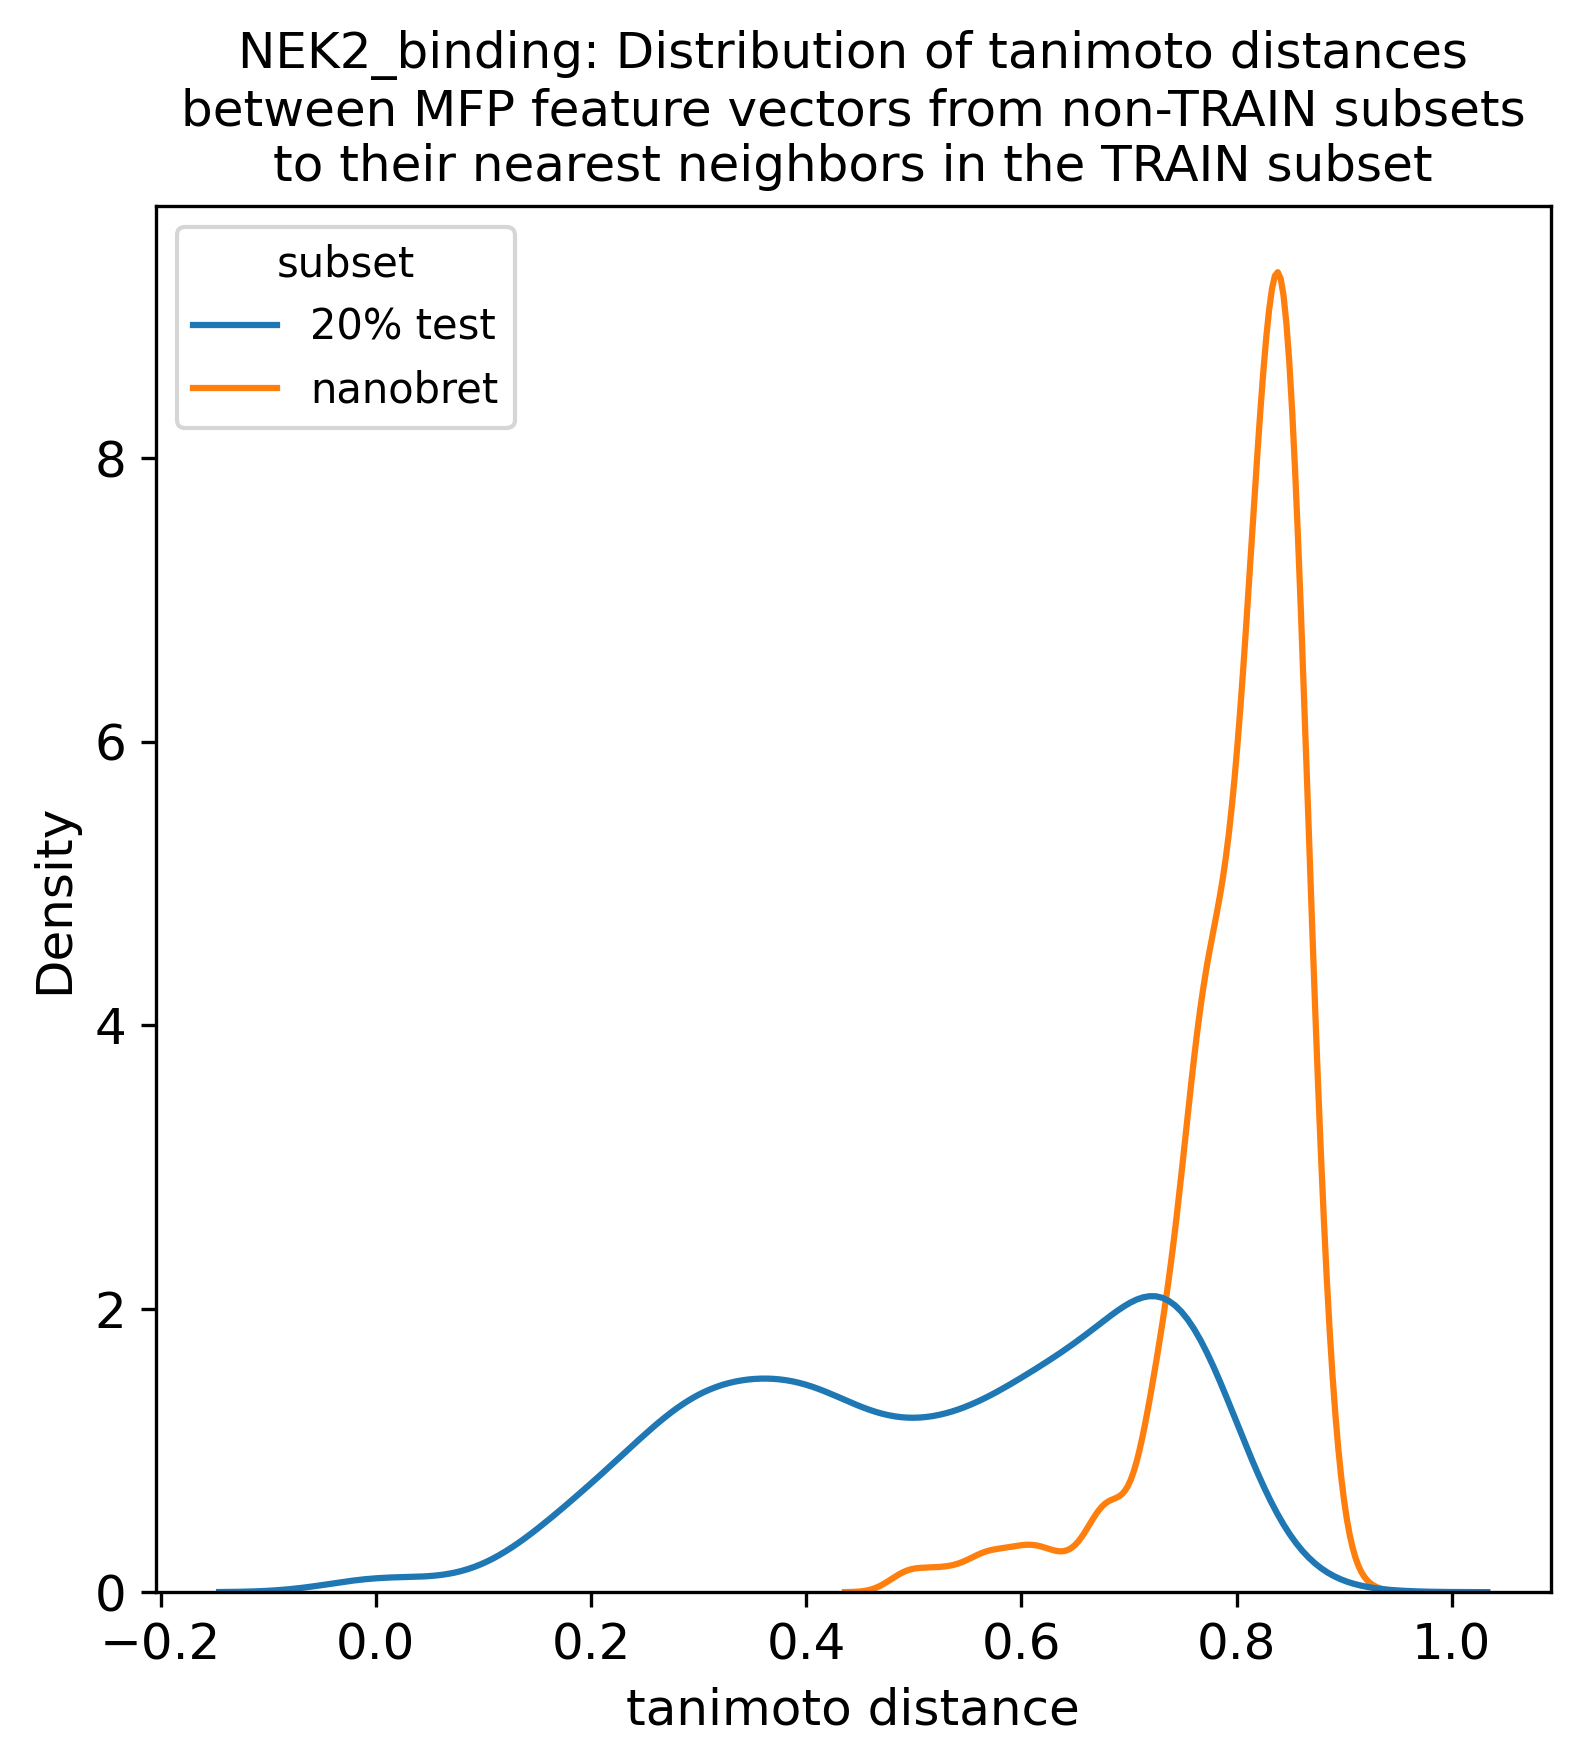

NEK2_inhibition
subset
train       1625
20% test     407
nanobret     400
Name: count, dtype: int64
20% test
nanobret


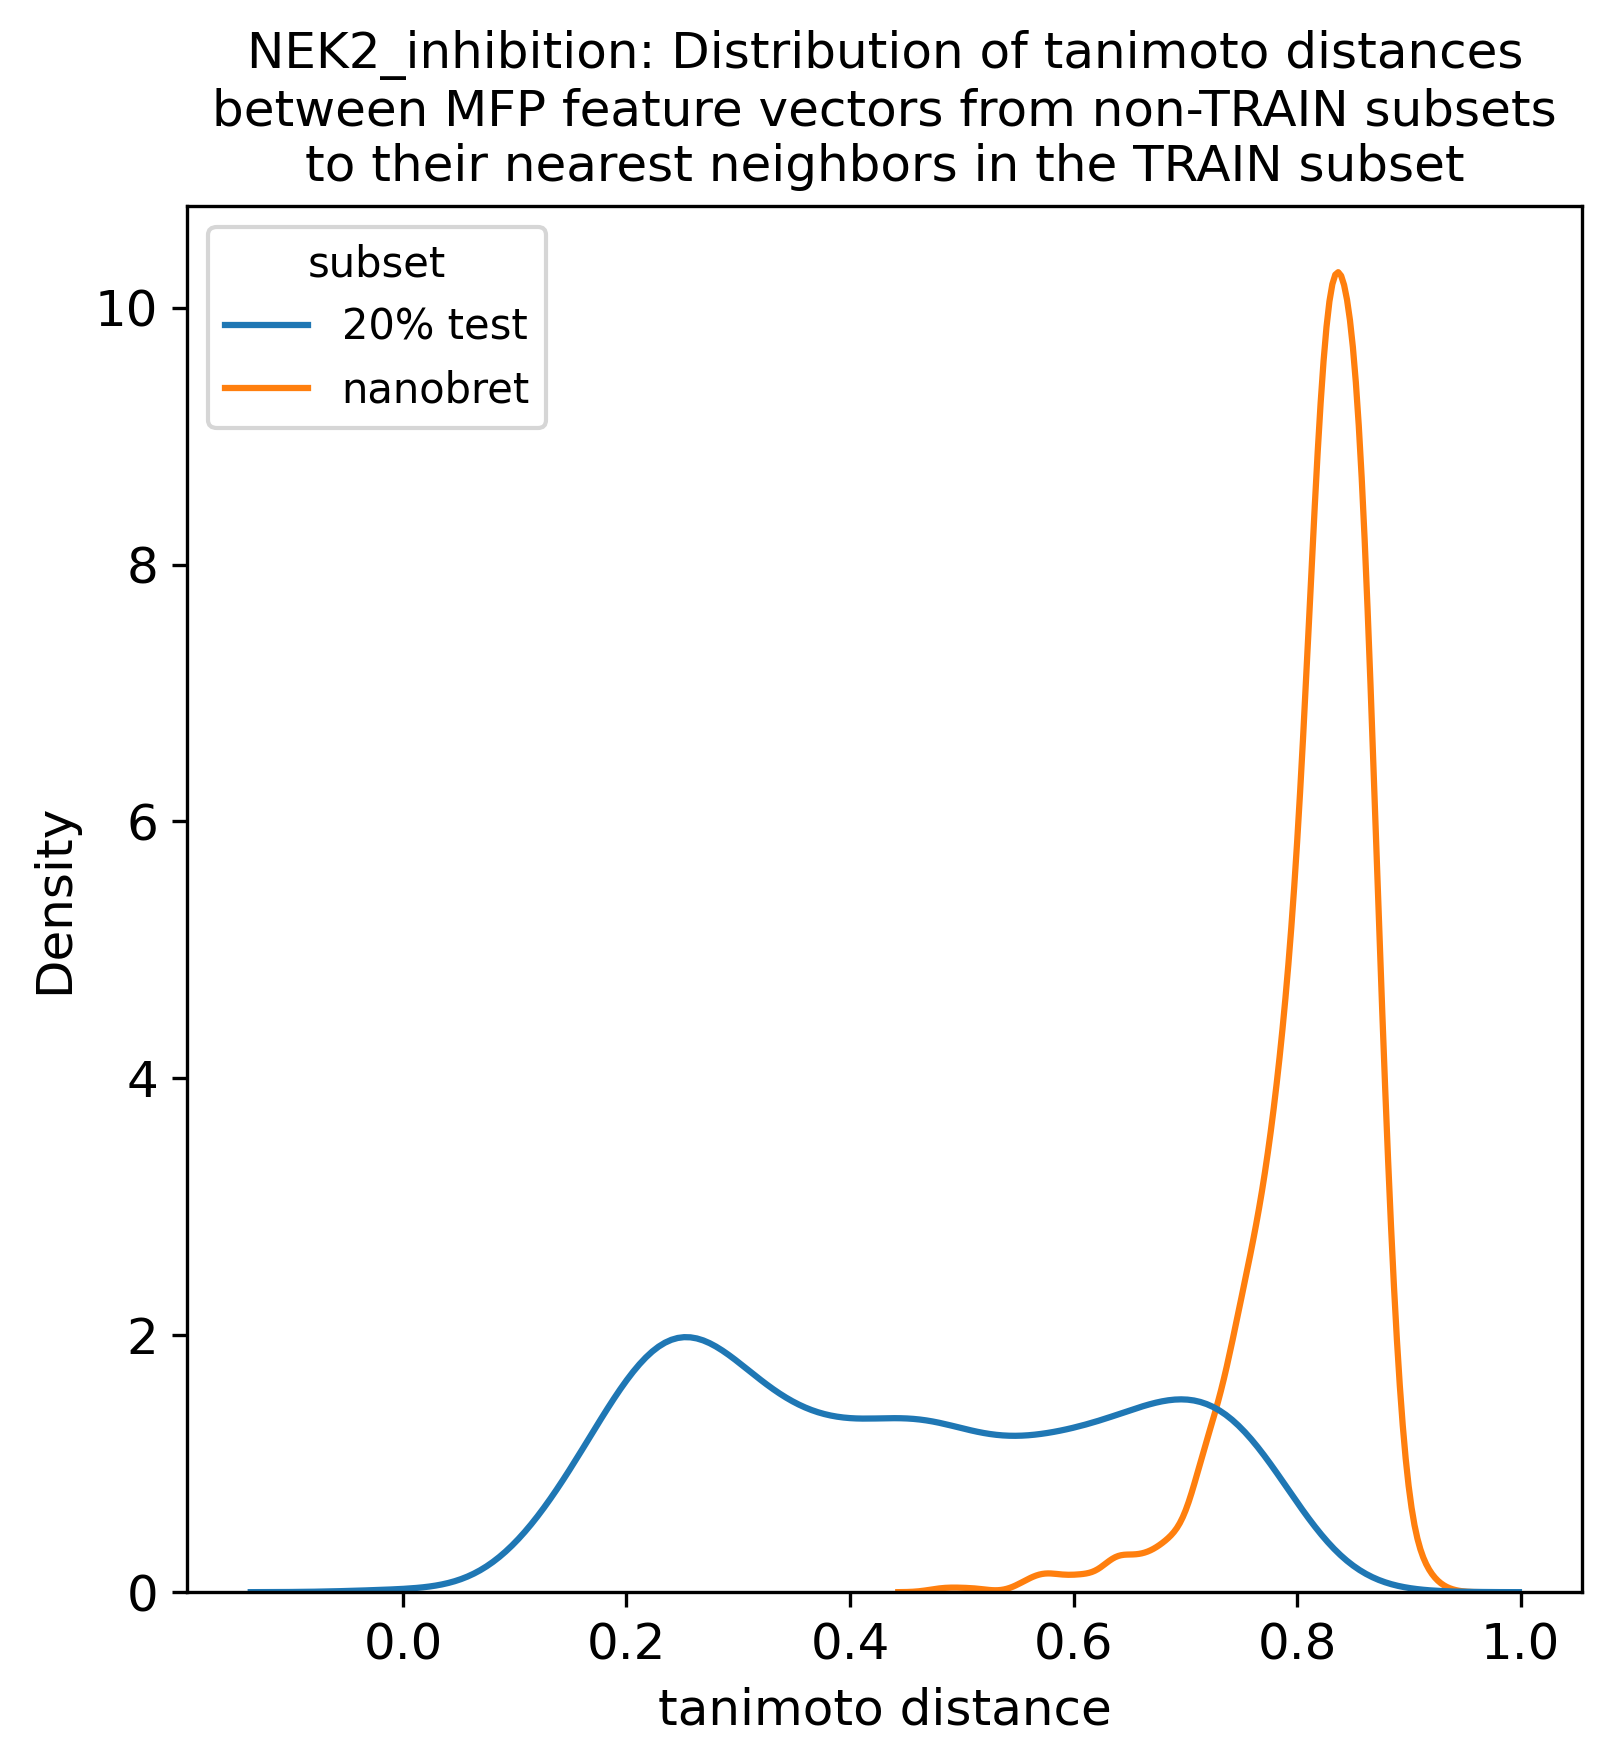

NEK3_binding
subset
train       1122
nanobret     400
20% test     282
Name: count, dtype: int64
20% test
nanobret


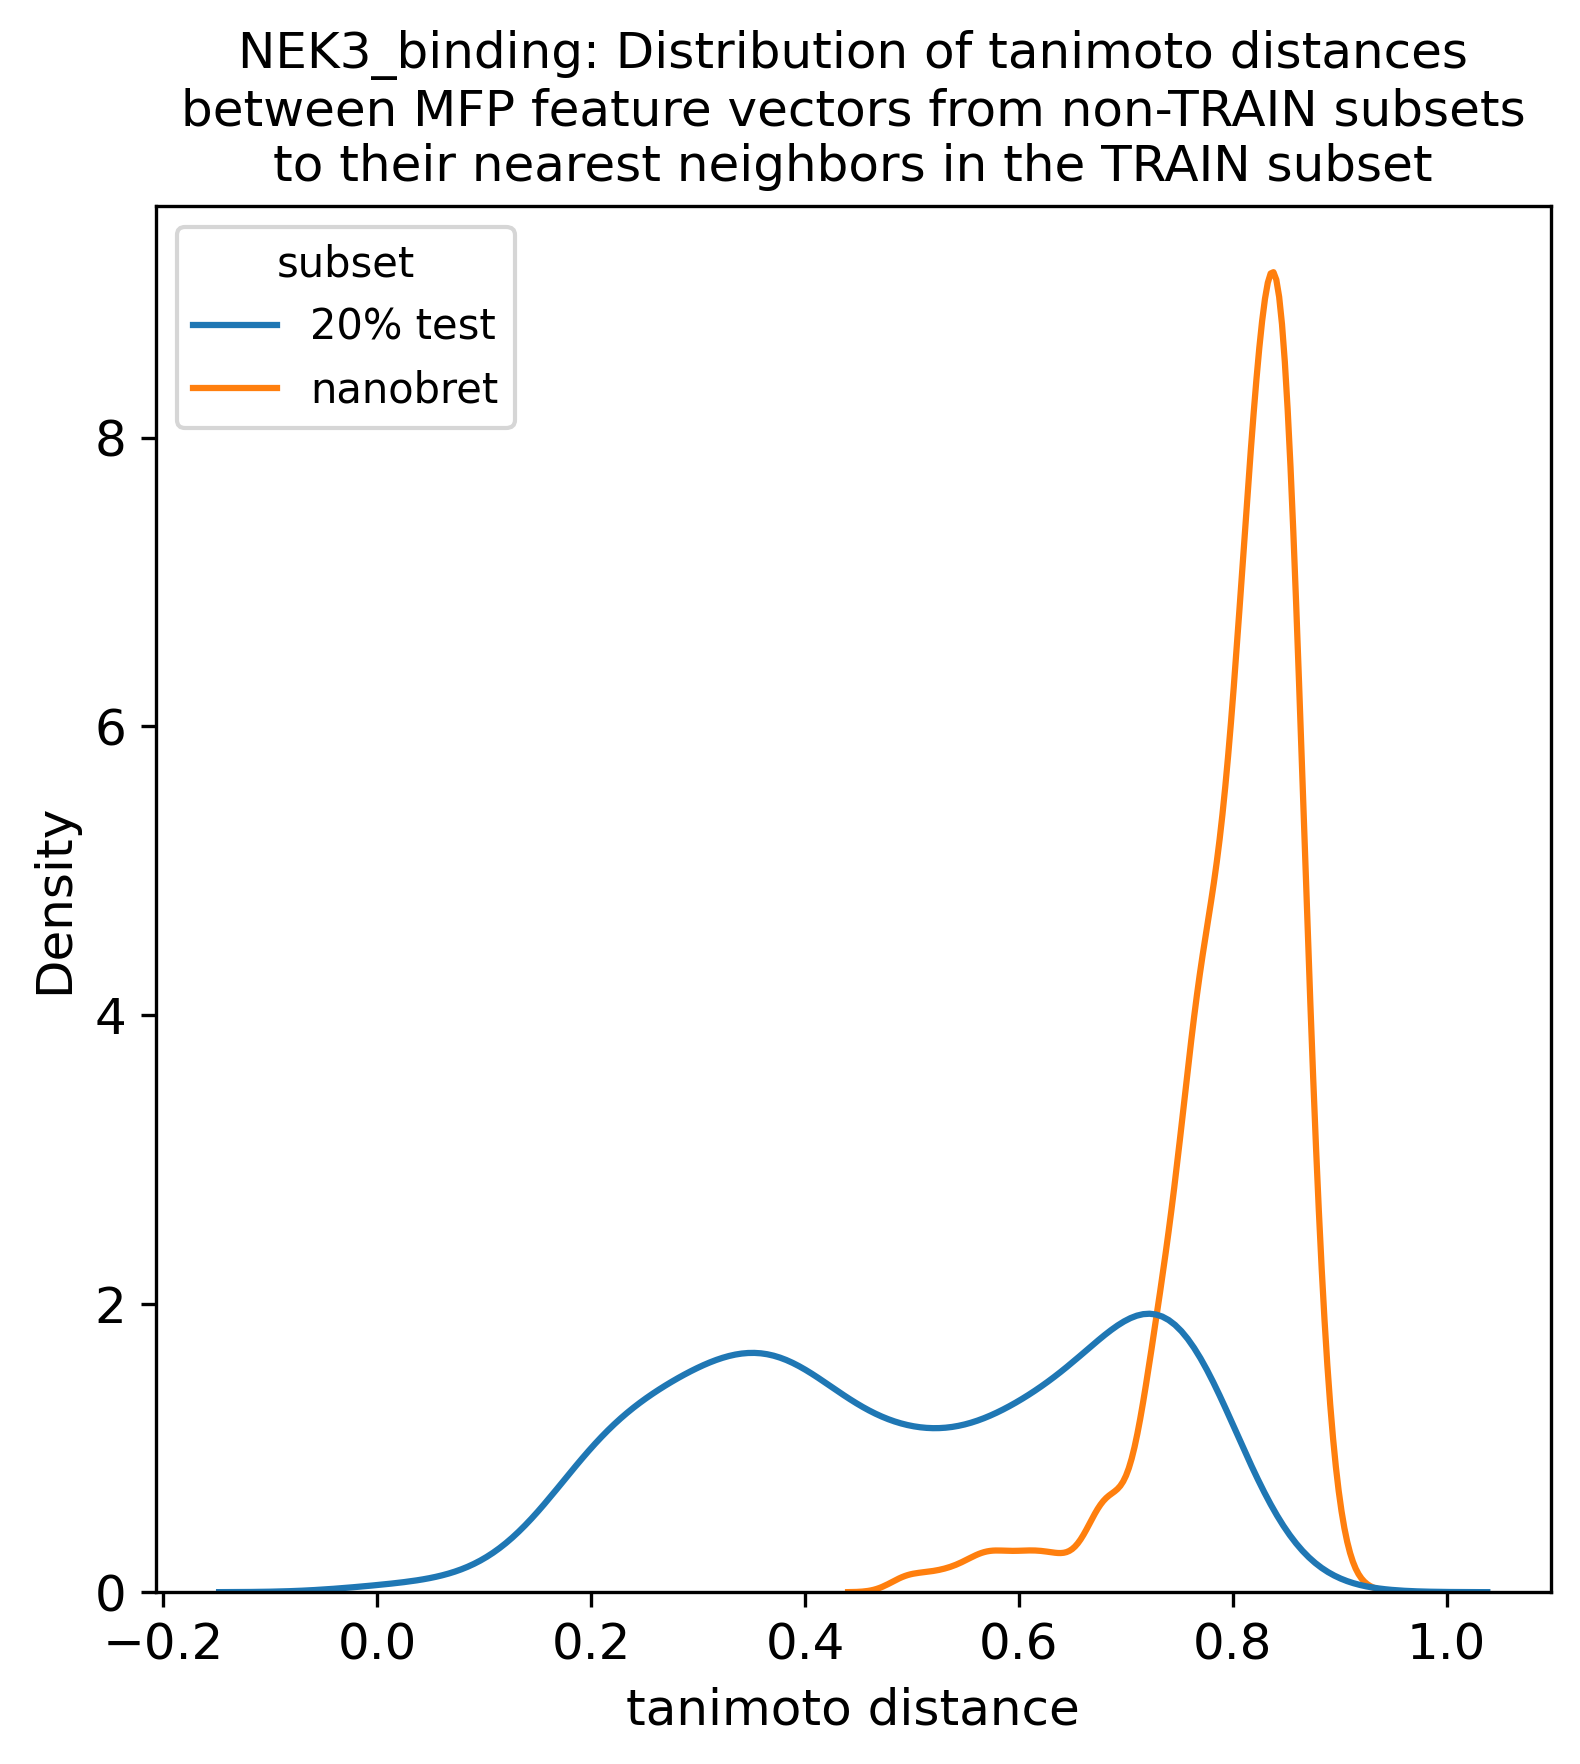

NEK5_binding
subset
train       989
nanobret    400
20% test    248
Name: count, dtype: int64
20% test
nanobret


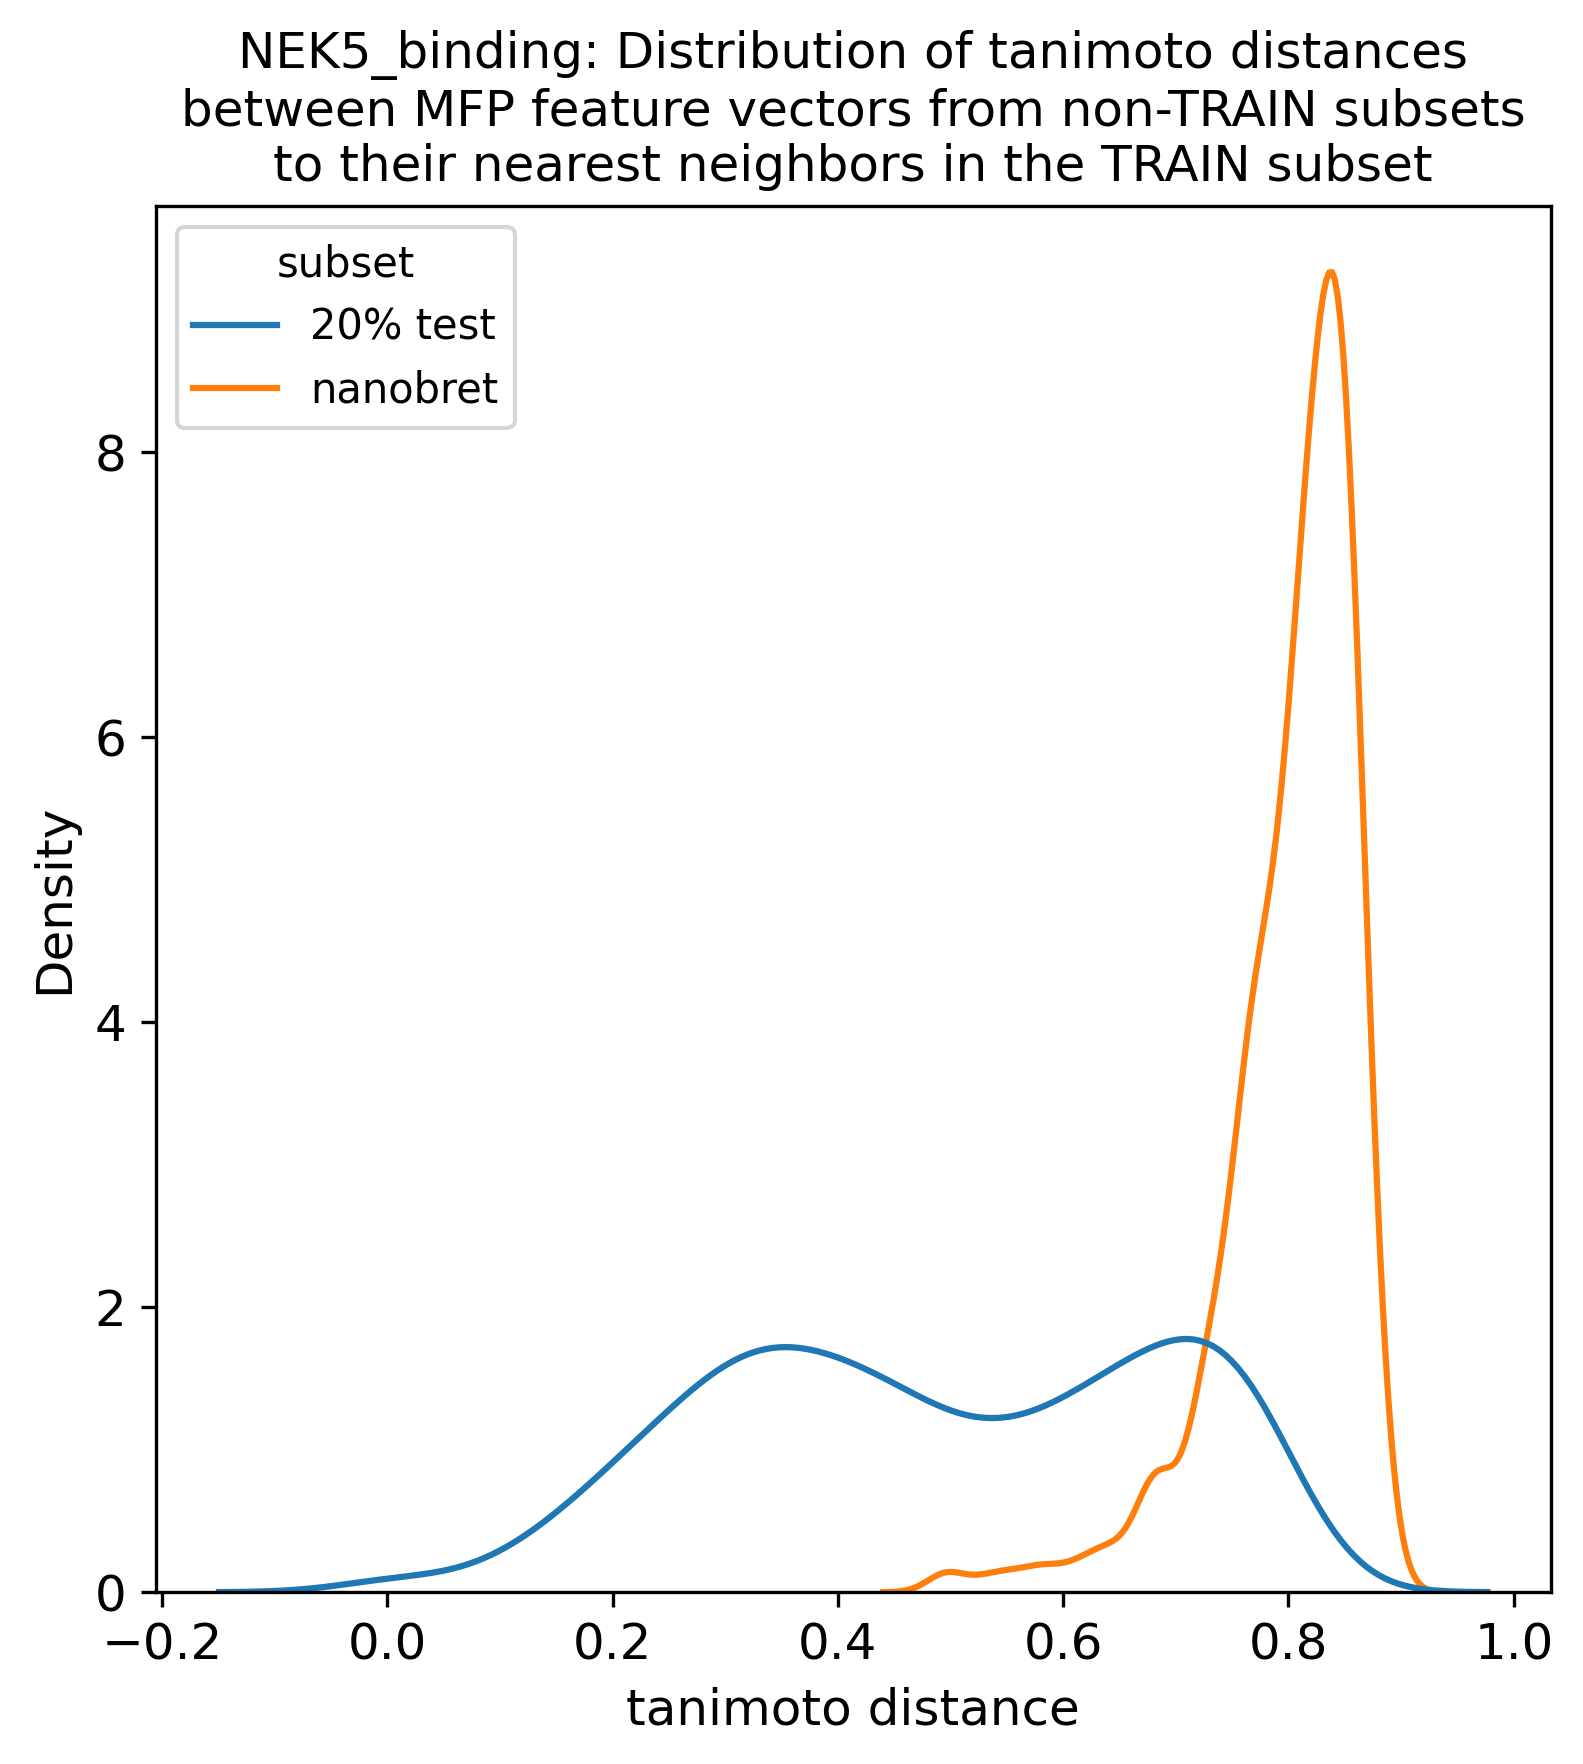

NEK9_binding
subset
train       1126
nanobret     400
20% test     283
Name: count, dtype: int64
20% test
nanobret


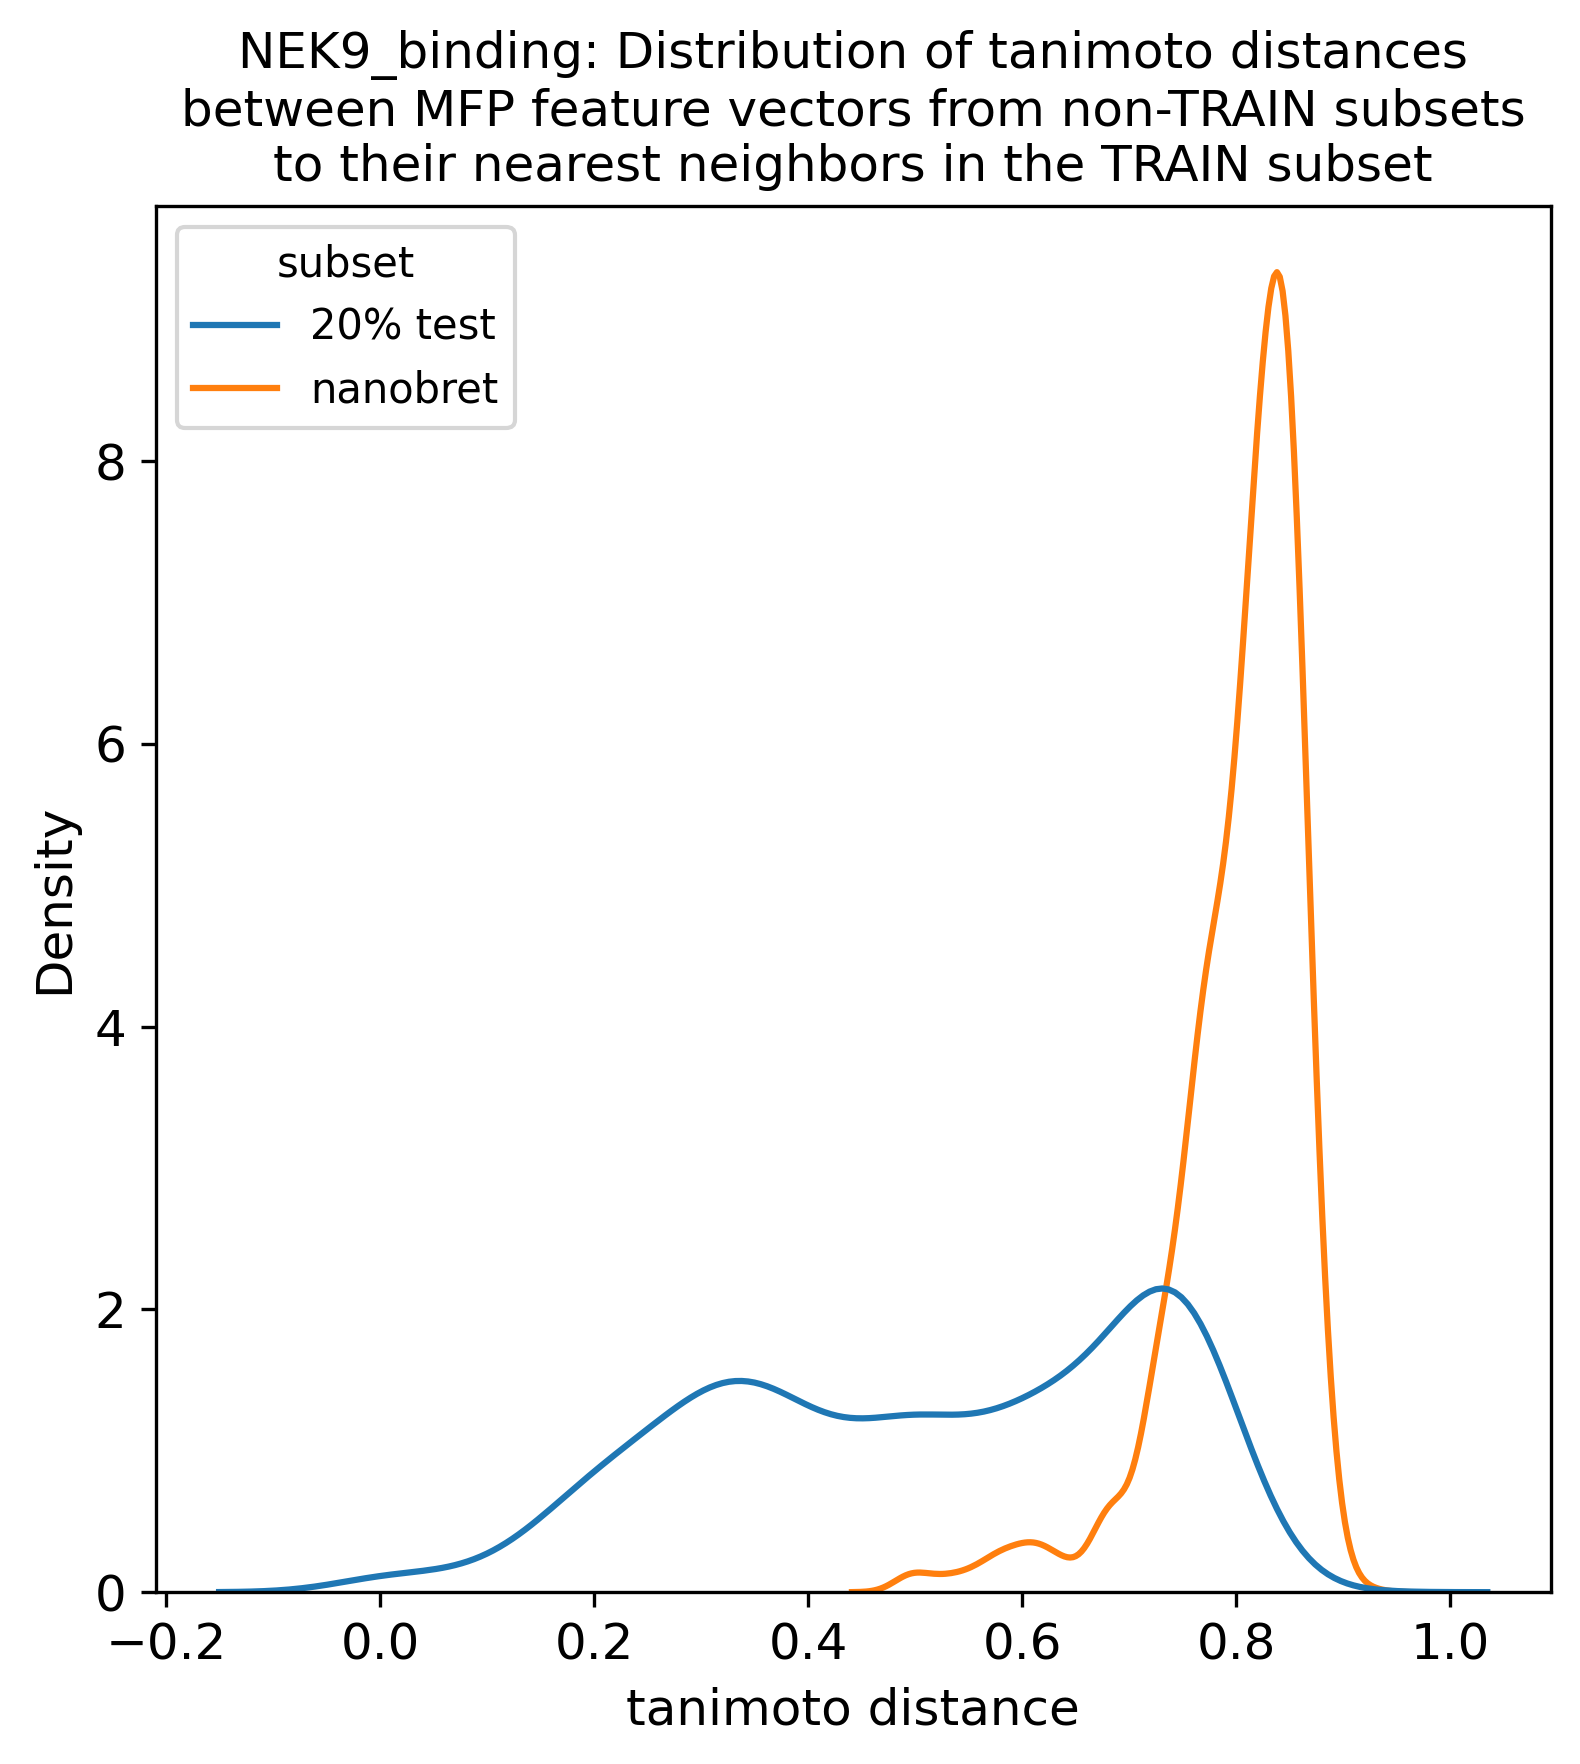

NEK9_inhibition
subset
nanobret    400
train       313
20% test     80
Name: count, dtype: int64
20% test
nanobret


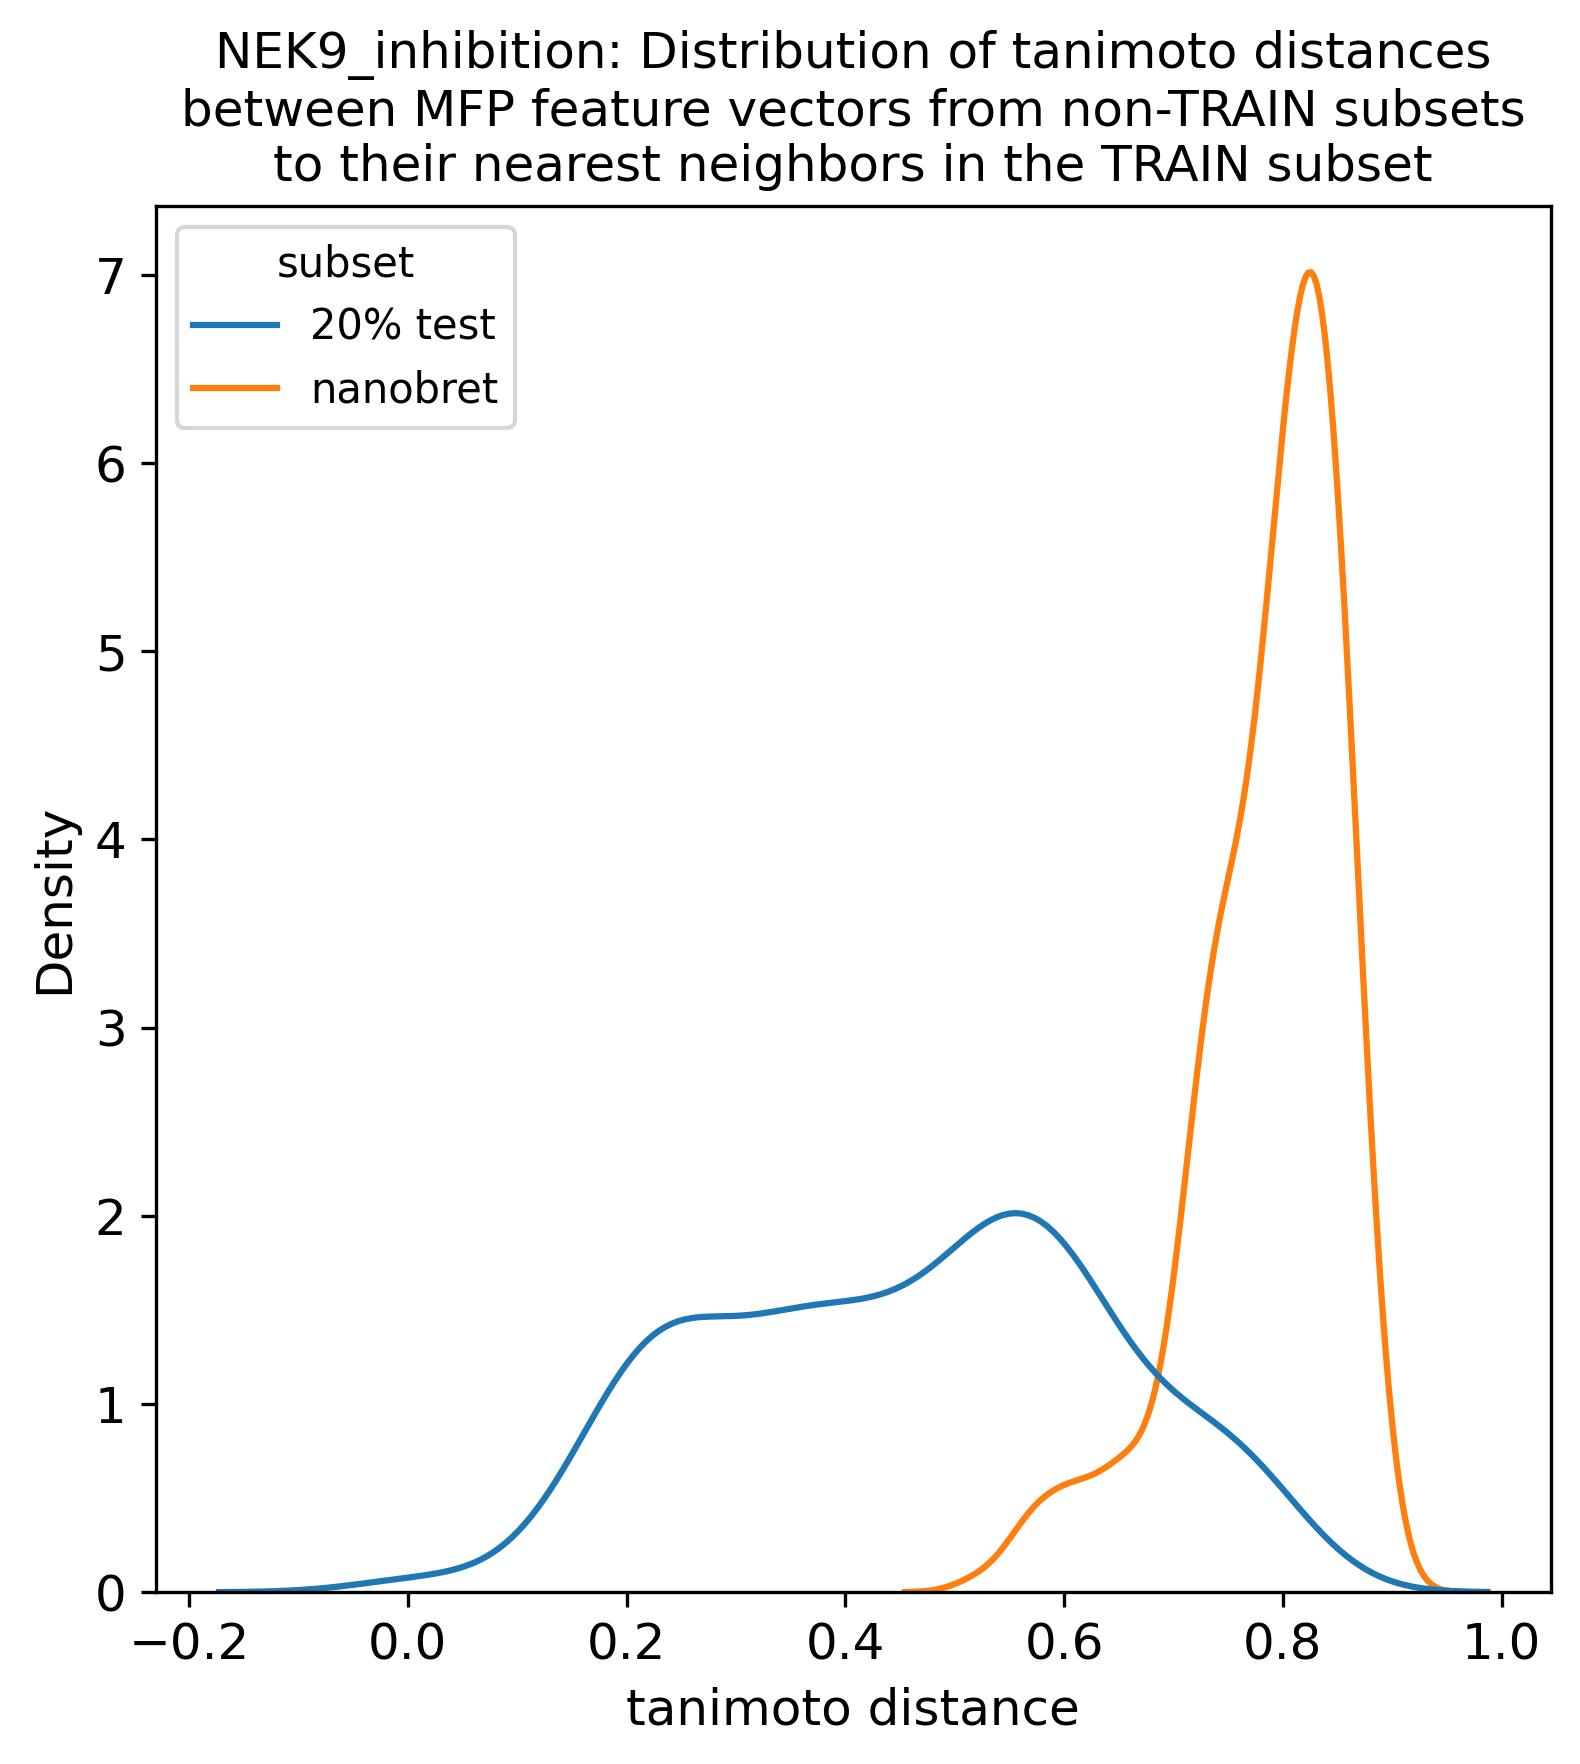

In [48]:
# (1) kde of orig train(80%) vs test20% and  orig train(80%) vs test nanobret [active and in-actives]

for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{og_datapath}{nek}_MFP_none_scaled.csv') # entire train set
    og_test= mfp_desc[mfp_desc['subset']=='test'] # holdout set 1
    og_test['subset'] ='20% test'
    og_train = mfp_desc[mfp_desc['subset']=='train'] # train set
    num_train = og_train.shape[0]
    # display(og_train)
    for new_nek in new_neks: 
        if nek[:4] == new_nek:
            new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
            holdout_df = new_nek_df[new_nek_df['subset'] == 'test'] # holdout set 2
            holdout_df['subset'] = 'nanobret'
        
            original_compounds = pd.concat([og_test,og_train, holdout_df])
            original_compounds= original_compounds.rename(columns=mfp_dict)
            
            print(original_compounds['subset'].value_counts())
            
            dists,fig,ax=plot_tani_dist_distr(original_compounds, 'base_rdkit_smiles', this_nek, ref_subset='train',radius=2, subsets=True, featurized=True)
            fig.savefig(f'/Users/jayceepang/msse/ATOM_CODE/examples/holdout/tanidists_vs_train80/{nek}_vs_train.png', bbox_inches='tight',dpi=300)



NEK2_binding
subset
SMOTE       2443
nanobret     400
20% test     283
Name: count, dtype: int64
20% test
nanobret


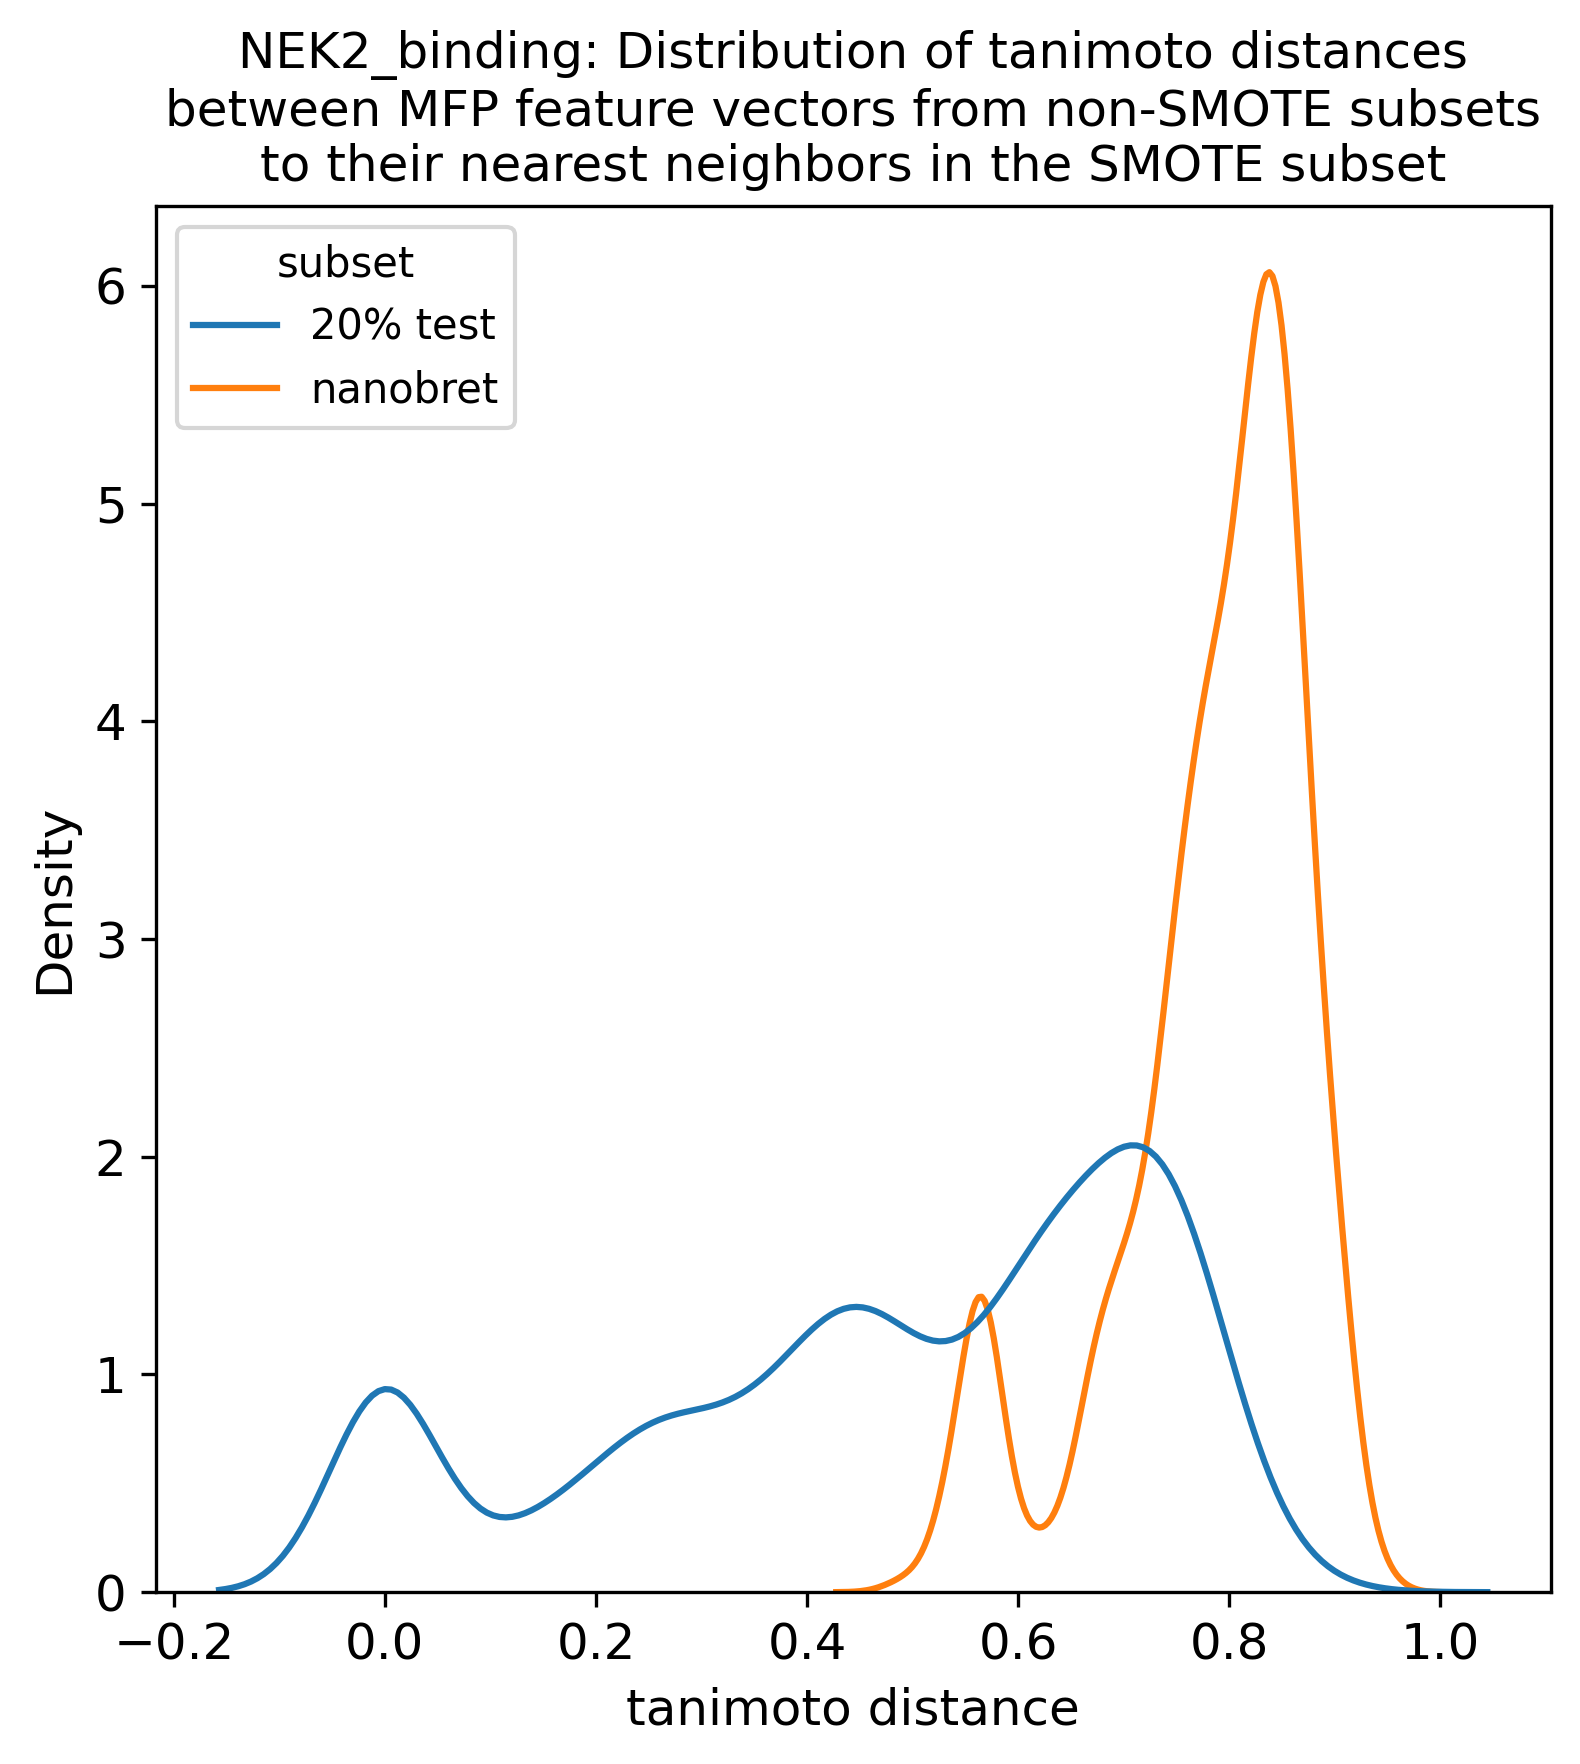

NEK2_inhibition
subset
SMOTE       3433
20% test     407
nanobret     400
Name: count, dtype: int64
20% test
nanobret


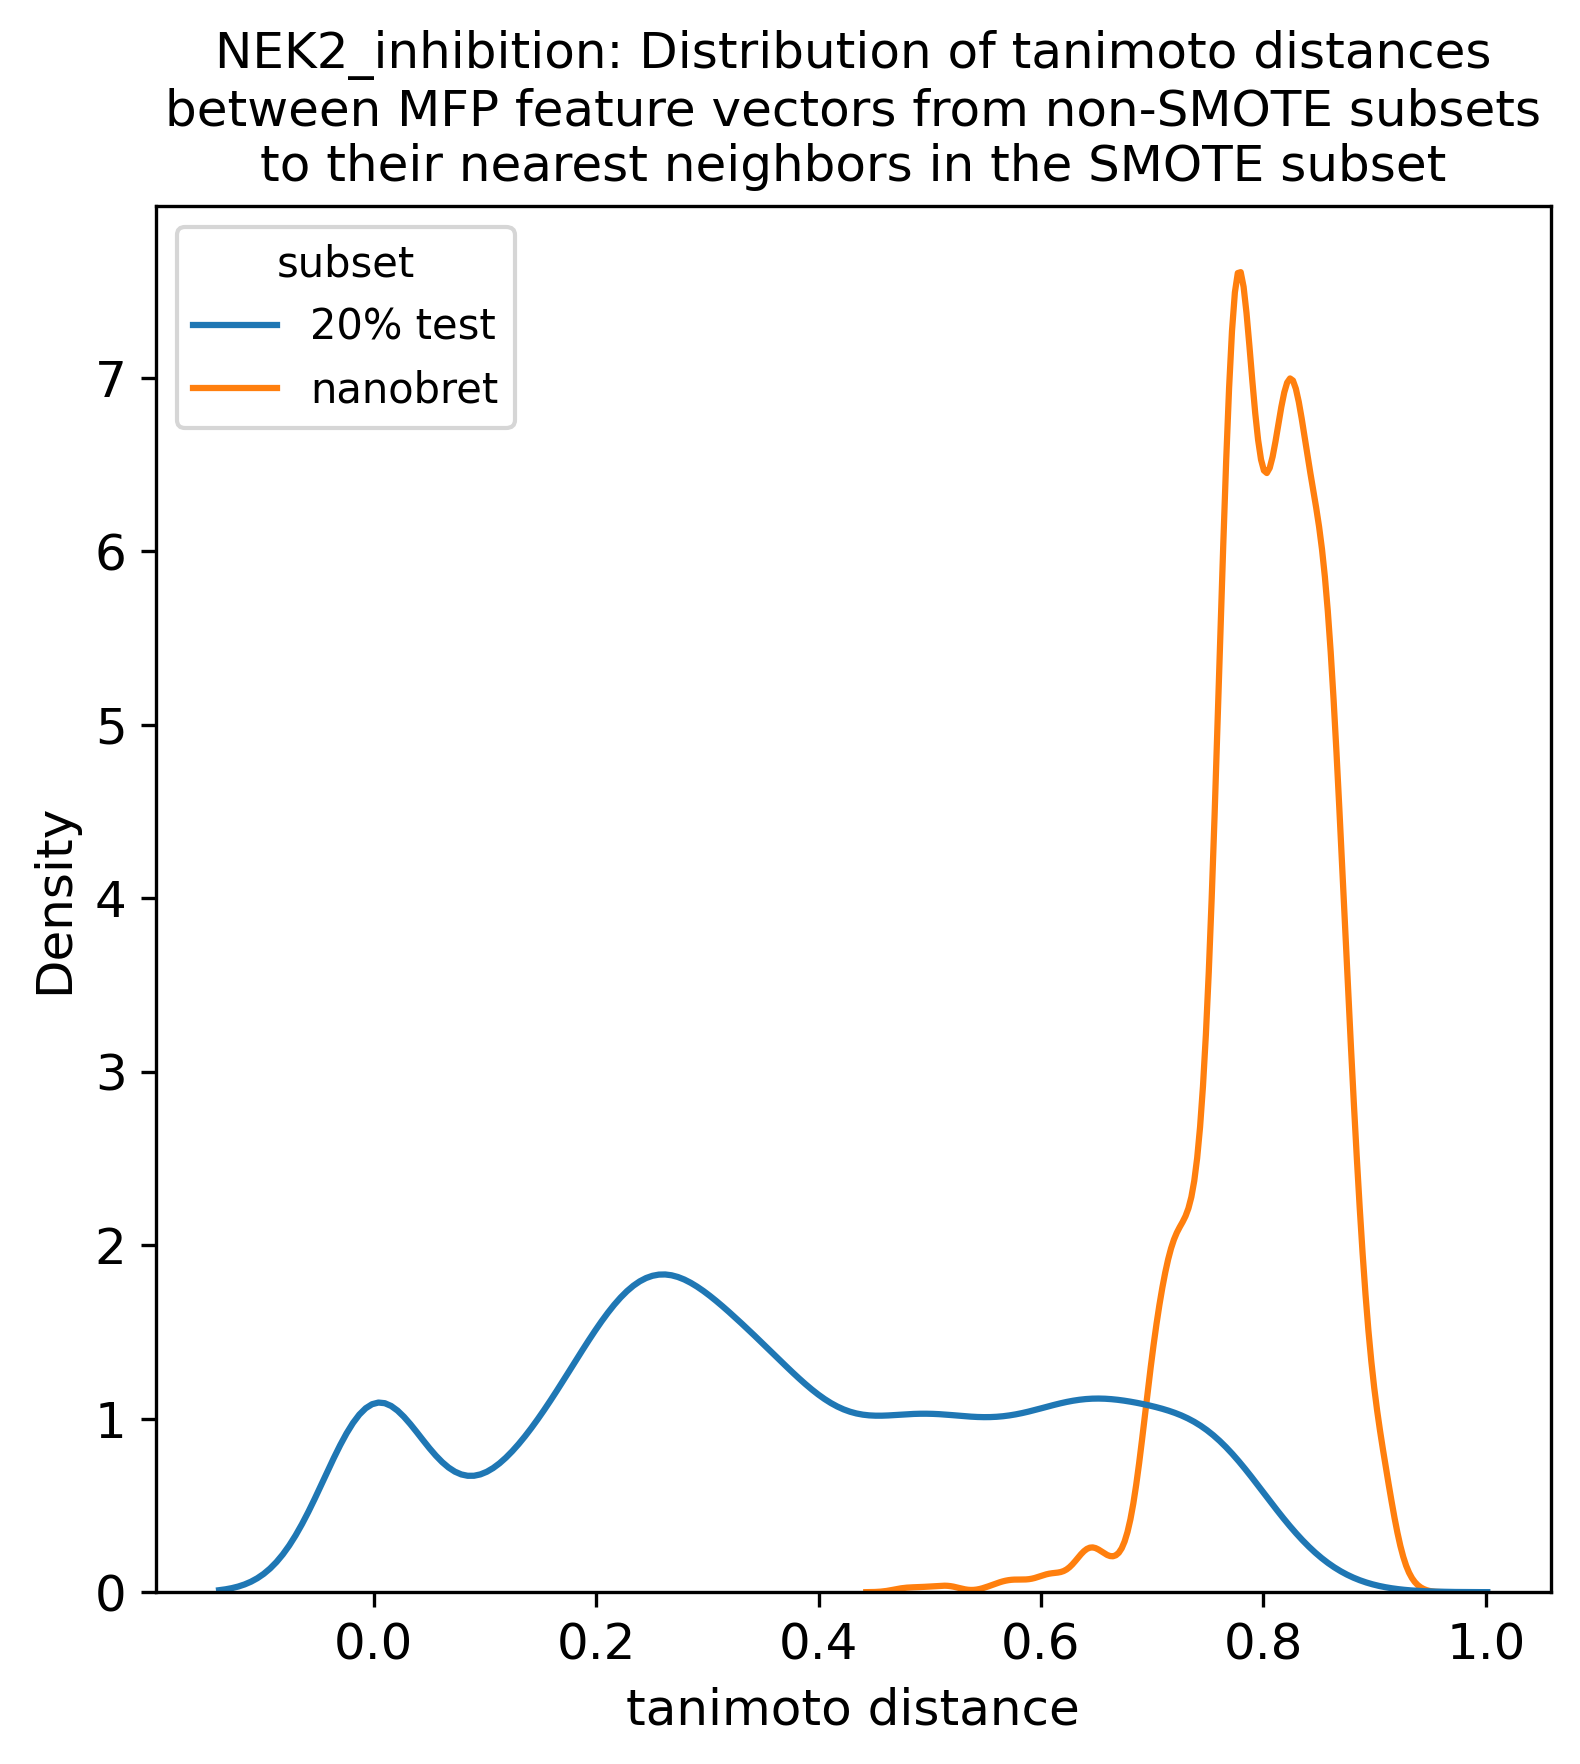

NEK3_binding
subset
SMOTE       2398
nanobret     400
20% test     282
Name: count, dtype: int64
20% test
nanobret


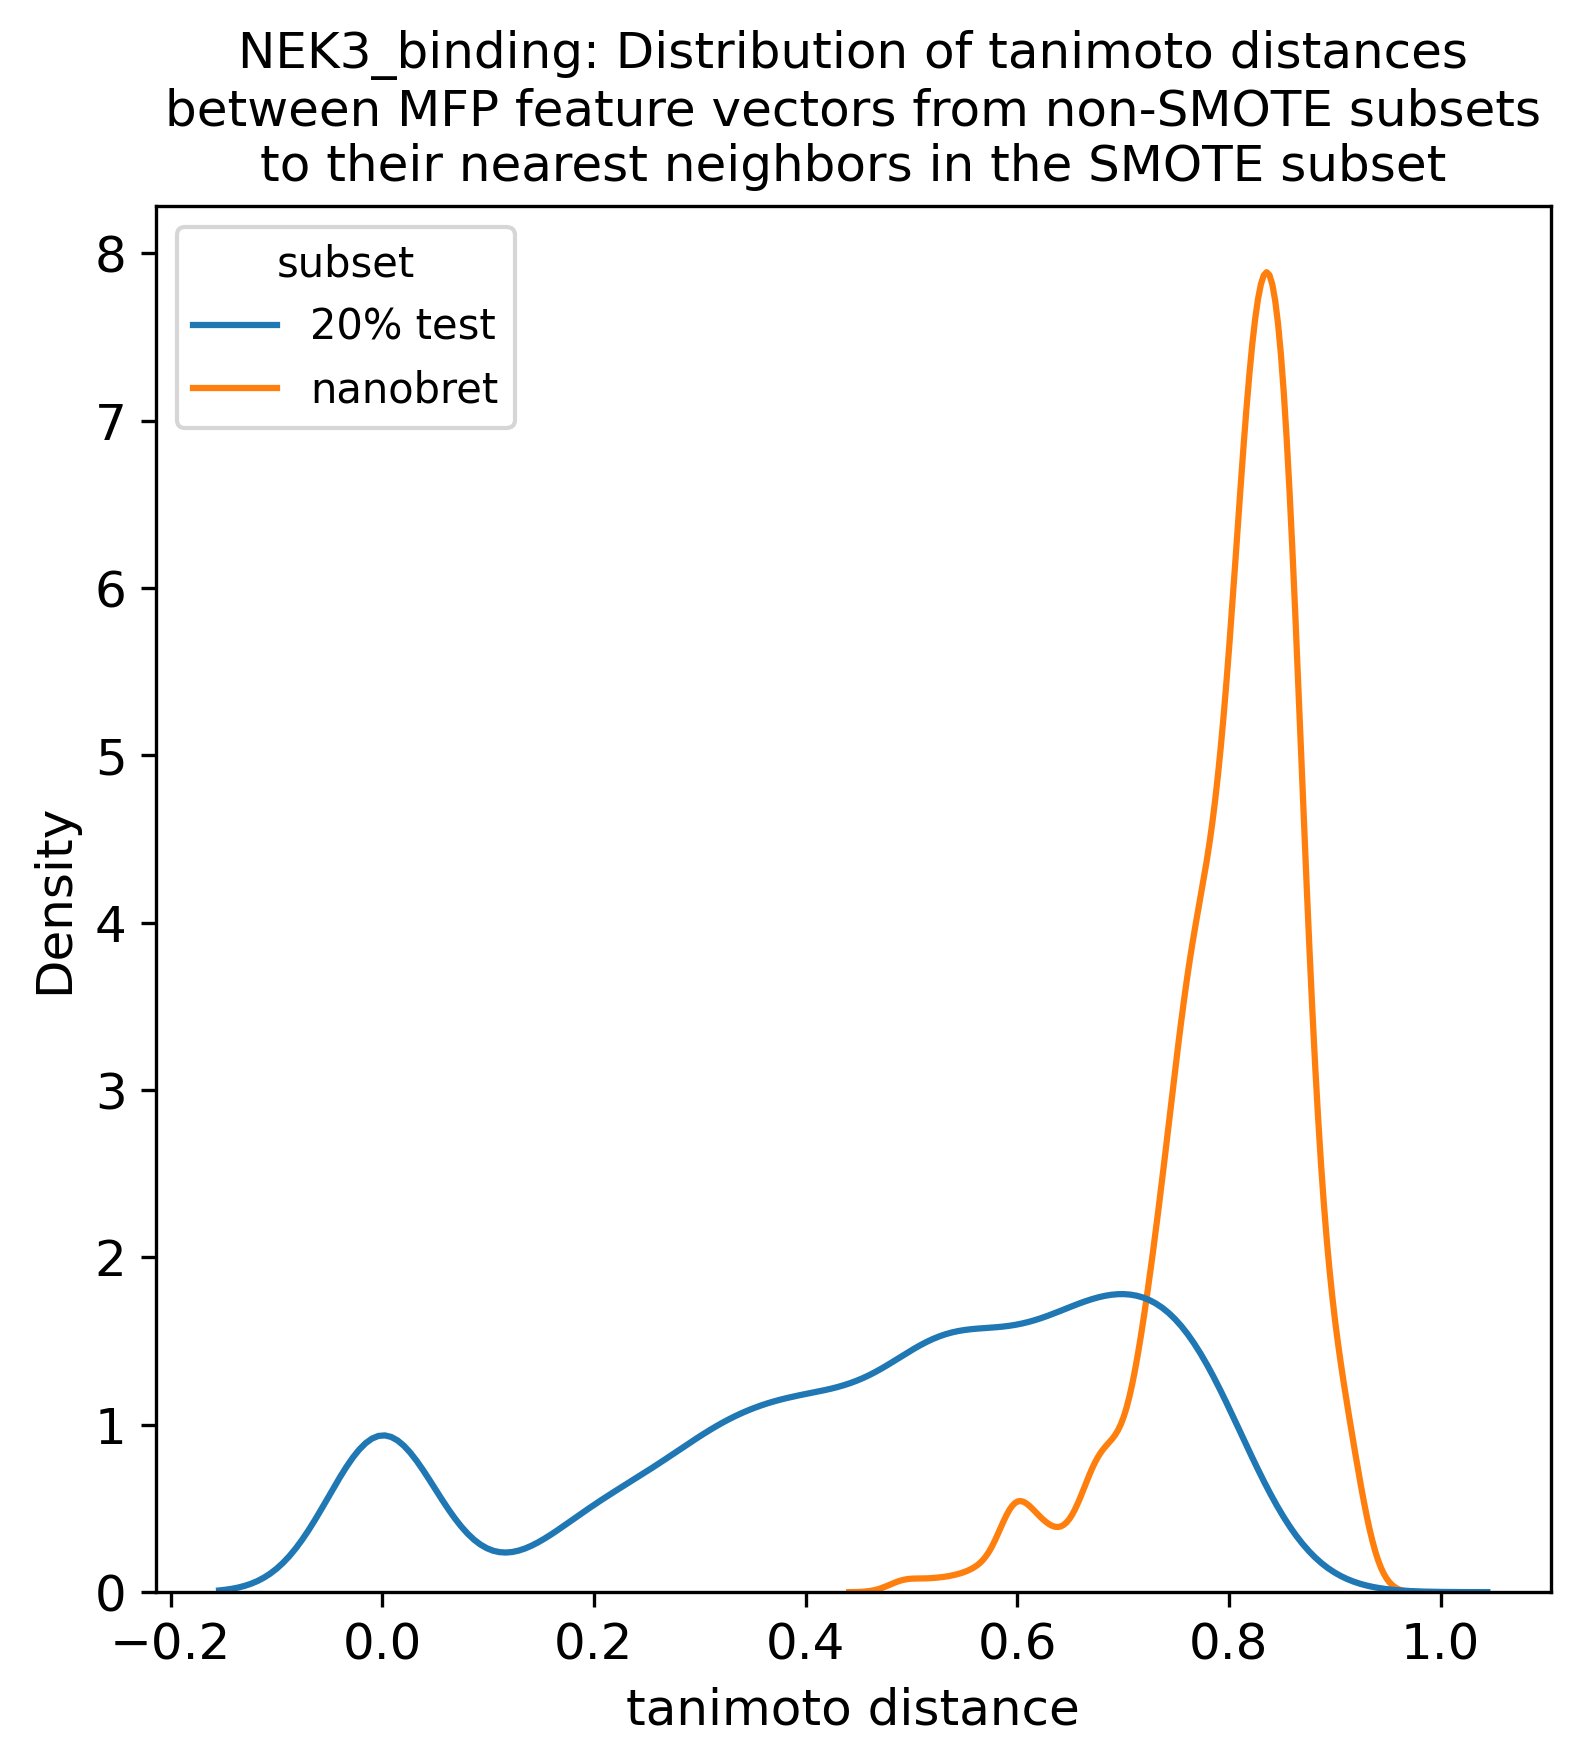

NEK5_binding
subset
SMOTE       2072
nanobret     400
20% test     248
Name: count, dtype: int64
20% test
nanobret


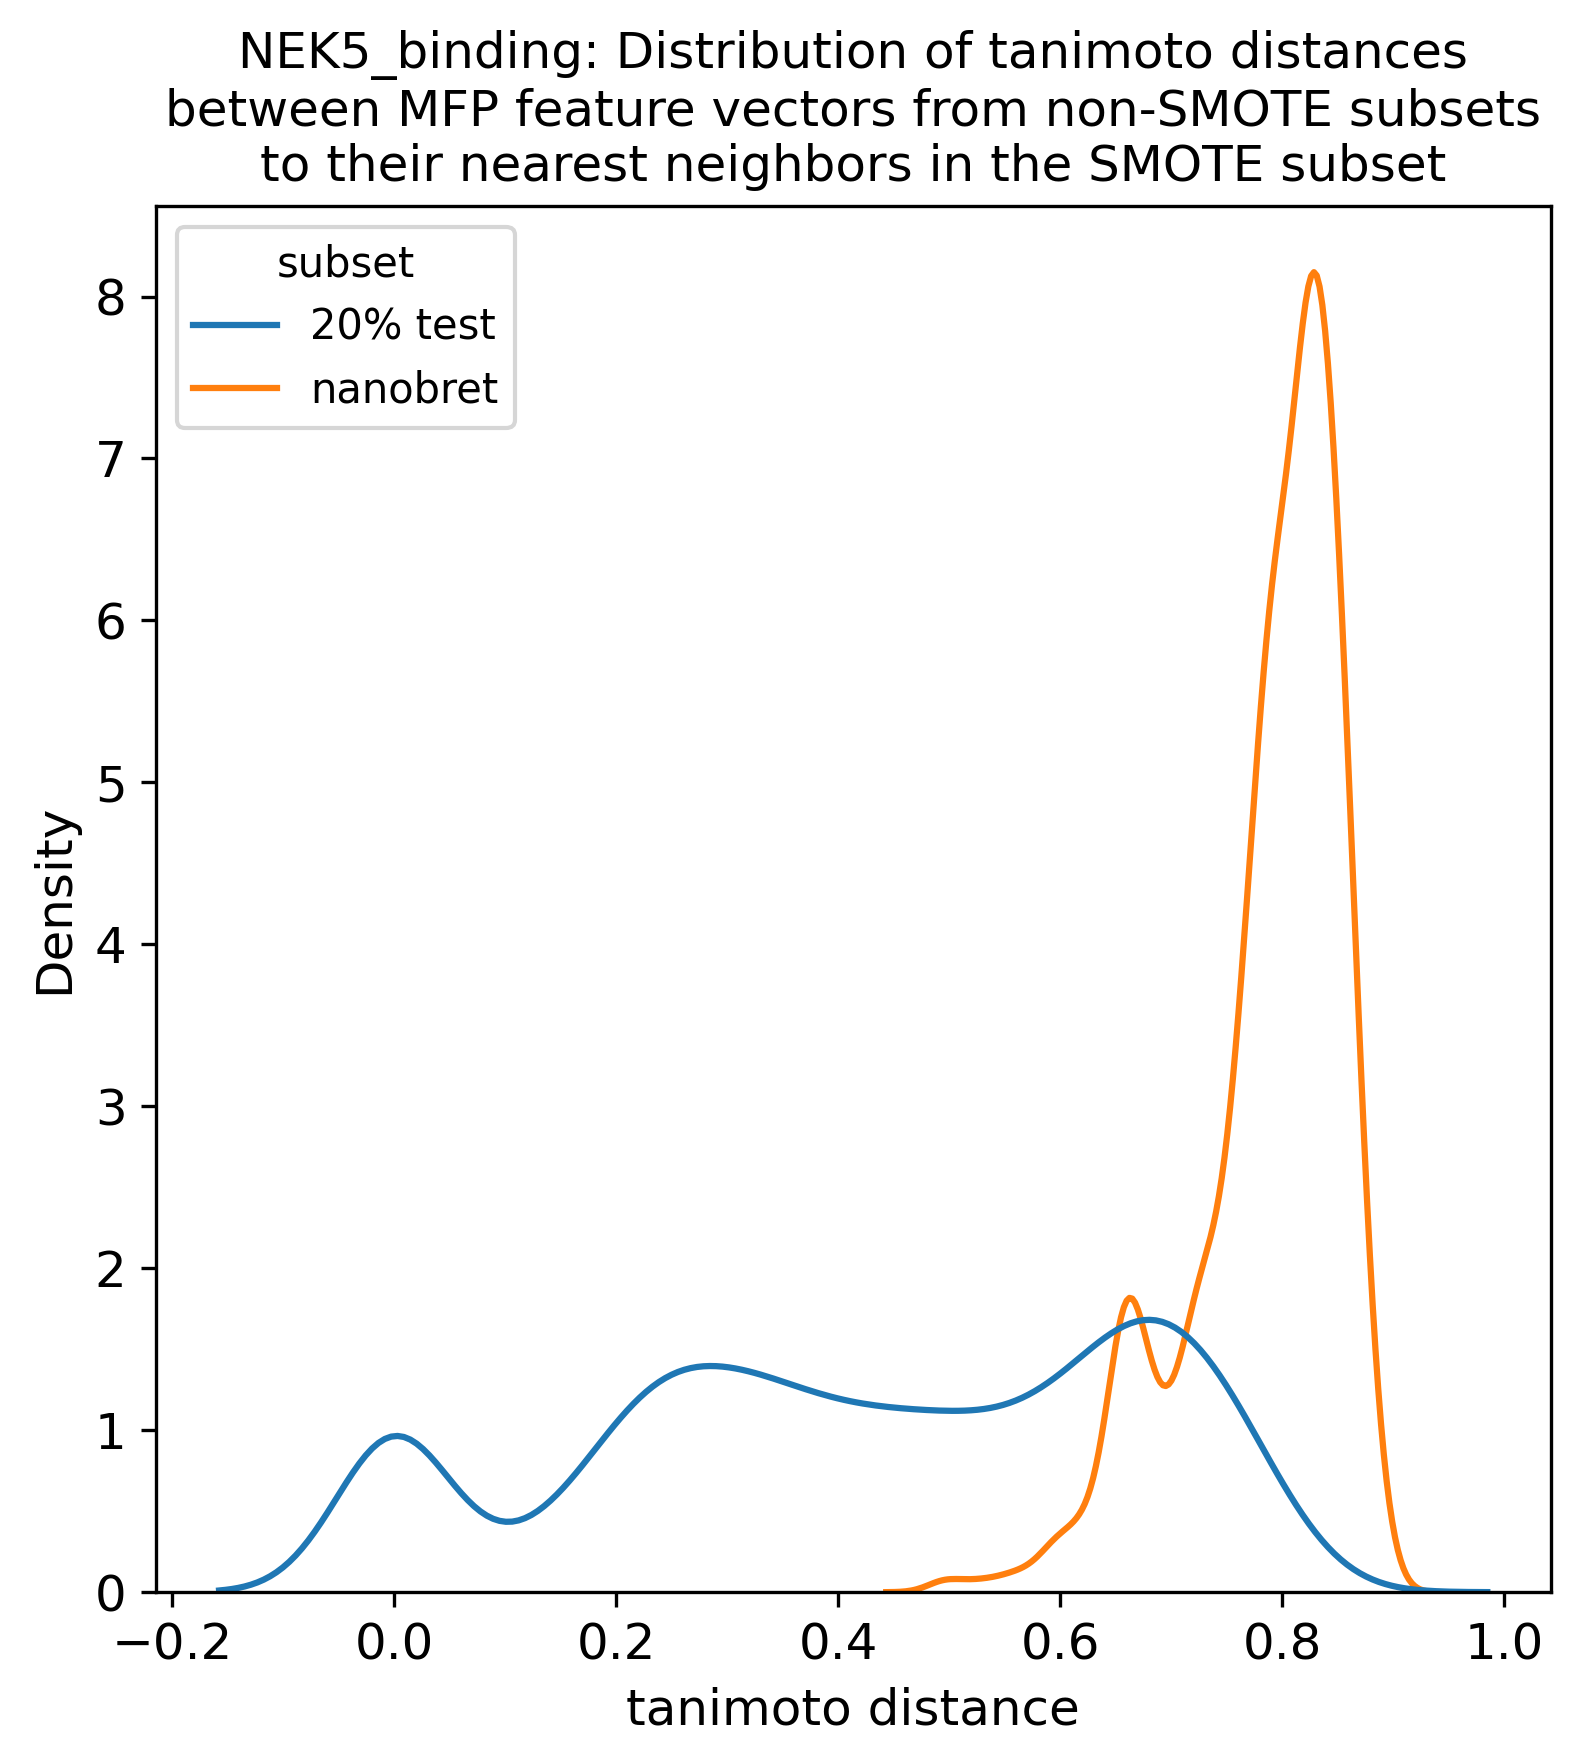

NEK9_binding
subset
SMOTE       2439
nanobret     400
20% test     283
Name: count, dtype: int64
20% test
nanobret


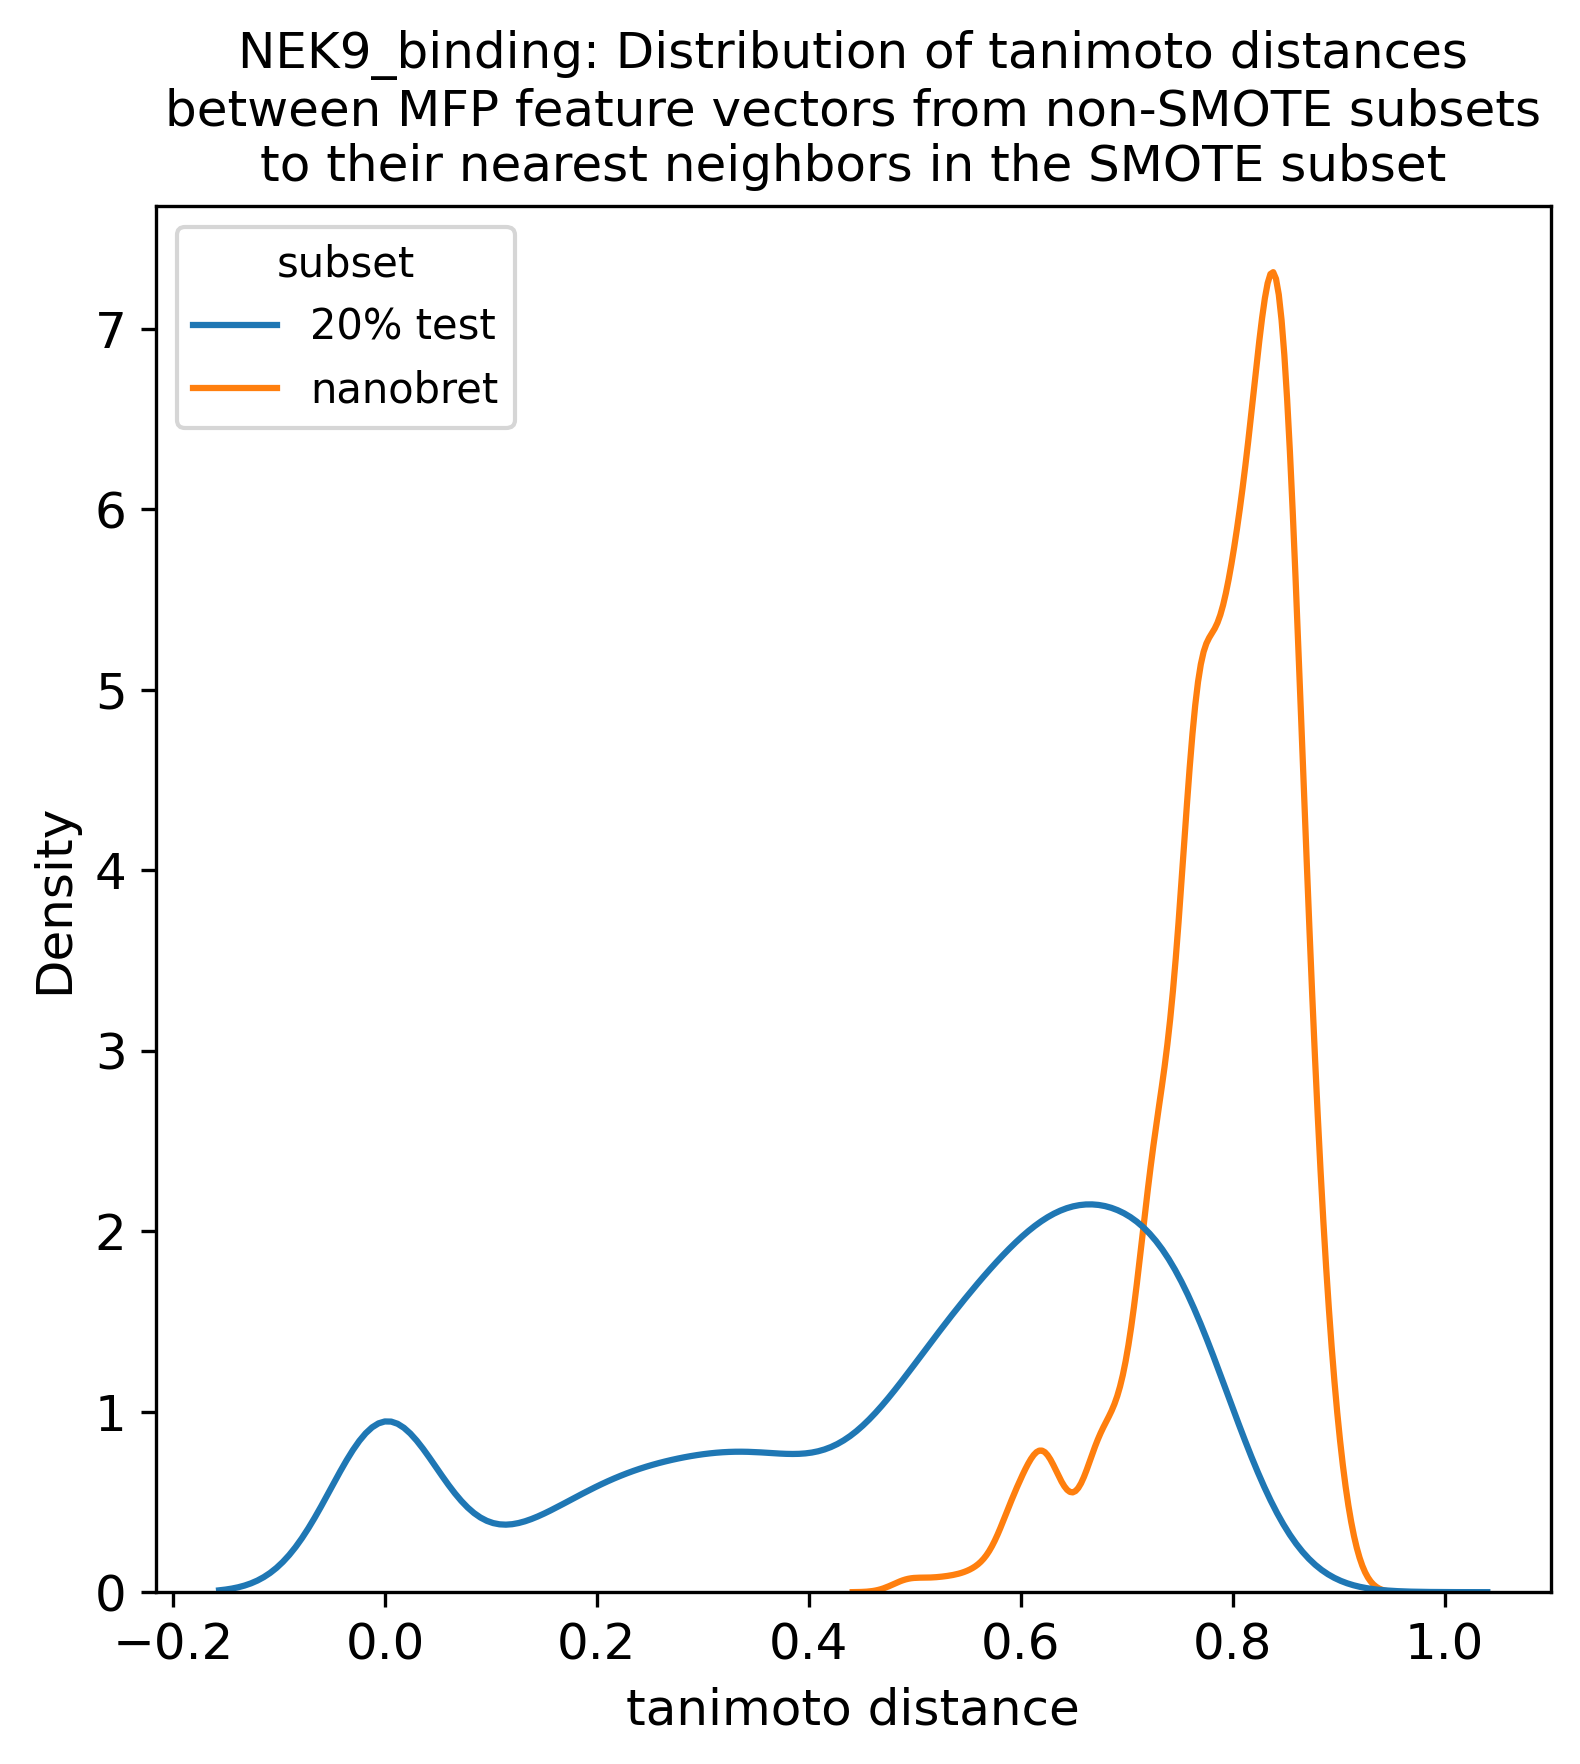

NEK9_inhibition
subset
SMOTE       640
nanobret    400
20% test     80
Name: count, dtype: int64
20% test
nanobret


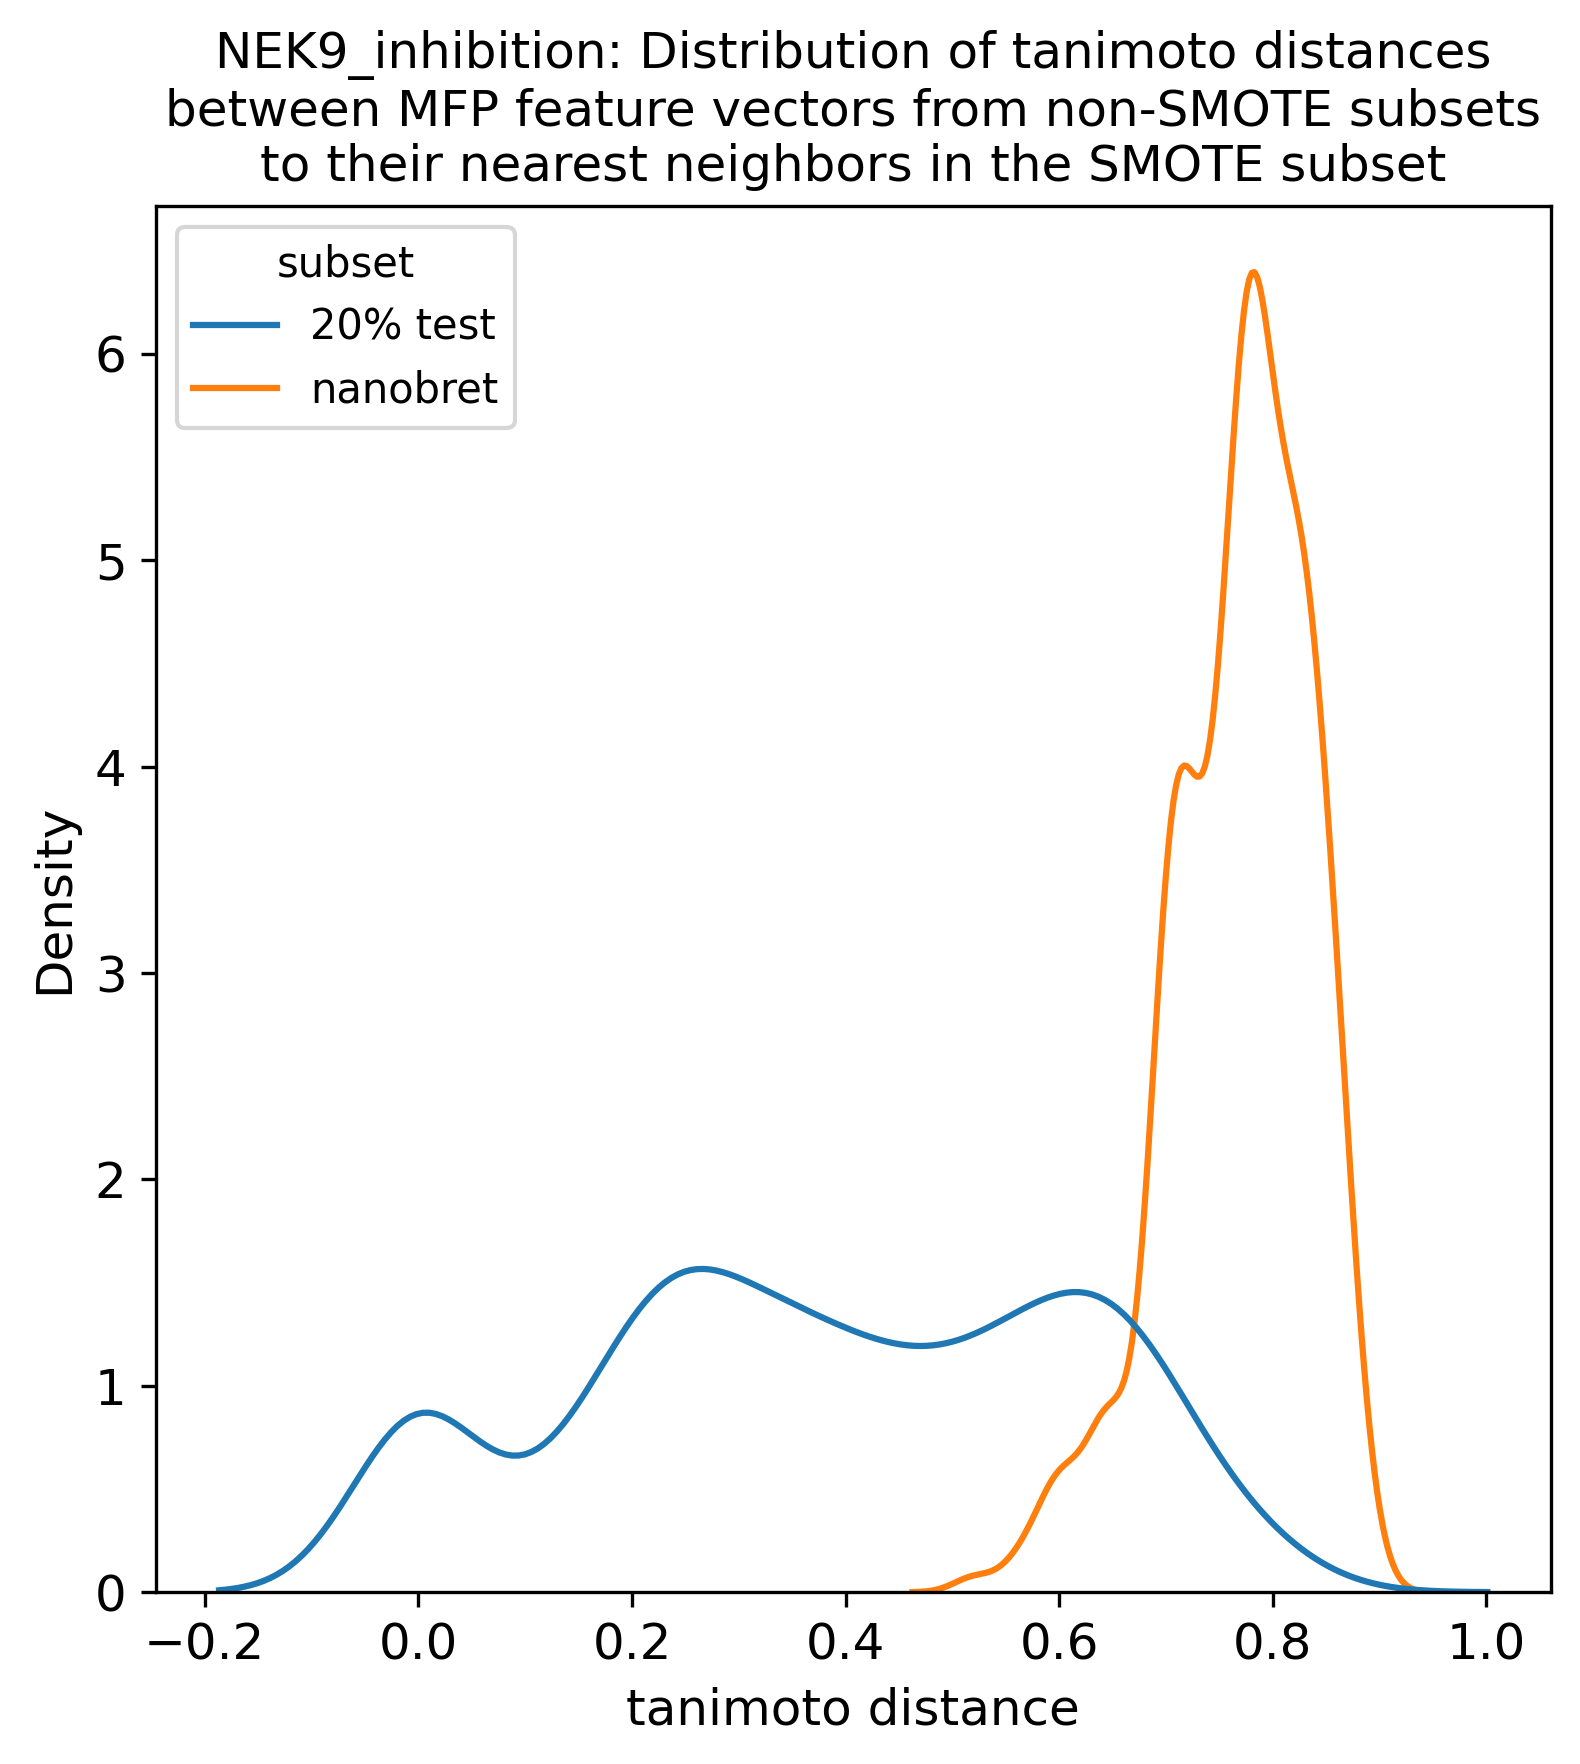

In [45]:
# (2) SMOTE synthetic & original inactive molecules vs test20% and SMOTE synthetic & original inactive molecules vs test nanobret
# (3) UNDER train vs test20% and UNDER train vs test nanobret (edited) 

pth2 = '/Users/jayceepang/msse/ATOM_CODE/examples/holdout/tanidists_vs_smote/'
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{og_datapath}{nek}_MFP_none_scaled.csv') # entire train set
    og_test= mfp_desc[mfp_desc['subset']=='test'] # holdout set 1
    og_test['subset'] ='20% test'
    for new_nek in new_neks: 
        if nek[:4] == new_nek:
            new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
            holdout_df = new_nek_df[new_nek_df['subset'] == 'test'] # holdout set 2
            holdout_df['subset'] = 'nanobret'
            mfp_under = pd.read_csv(f'{og_datapath}{nek}_MFP_UNDER.csv')
            under = mfp_under[mfp_under['subset'] == 'train']
            under['subset'] = 'UNDER' 
        
            original_compounds = pd.concat([og_test,holdout_df])
            original_compounds= original_compounds.rename(columns=mfp_dict)
            
        
            mfp_smote = pd.read_csv(f'{og_datapath}{nek}_MFP_SMOTE.csv') 
            mfp_smote= mfp_smote.rename(columns=mfp_dict)
            mfp_smote['subset'] = 'SMOTE'
            df_all = pd.concat([original_compounds, mfp_smote])
            print(df_all['subset'].value_counts())
            
            dists,fig,ax=plot_tani_dist_distr(df_all, 'base_rdkit_smiles', this_nek, ref_subset='SMOTE',radius=2, subsets=True, featurized=True)
            fig.savefig(f'{pth2}{nek}_vs_SMOTE.png', bbox_inches='tight',dpi=300)





NEK2_binding
subset
nanobret    400
20% test    283
UNDER        90
Name: count, dtype: int64
20% test
nanobret


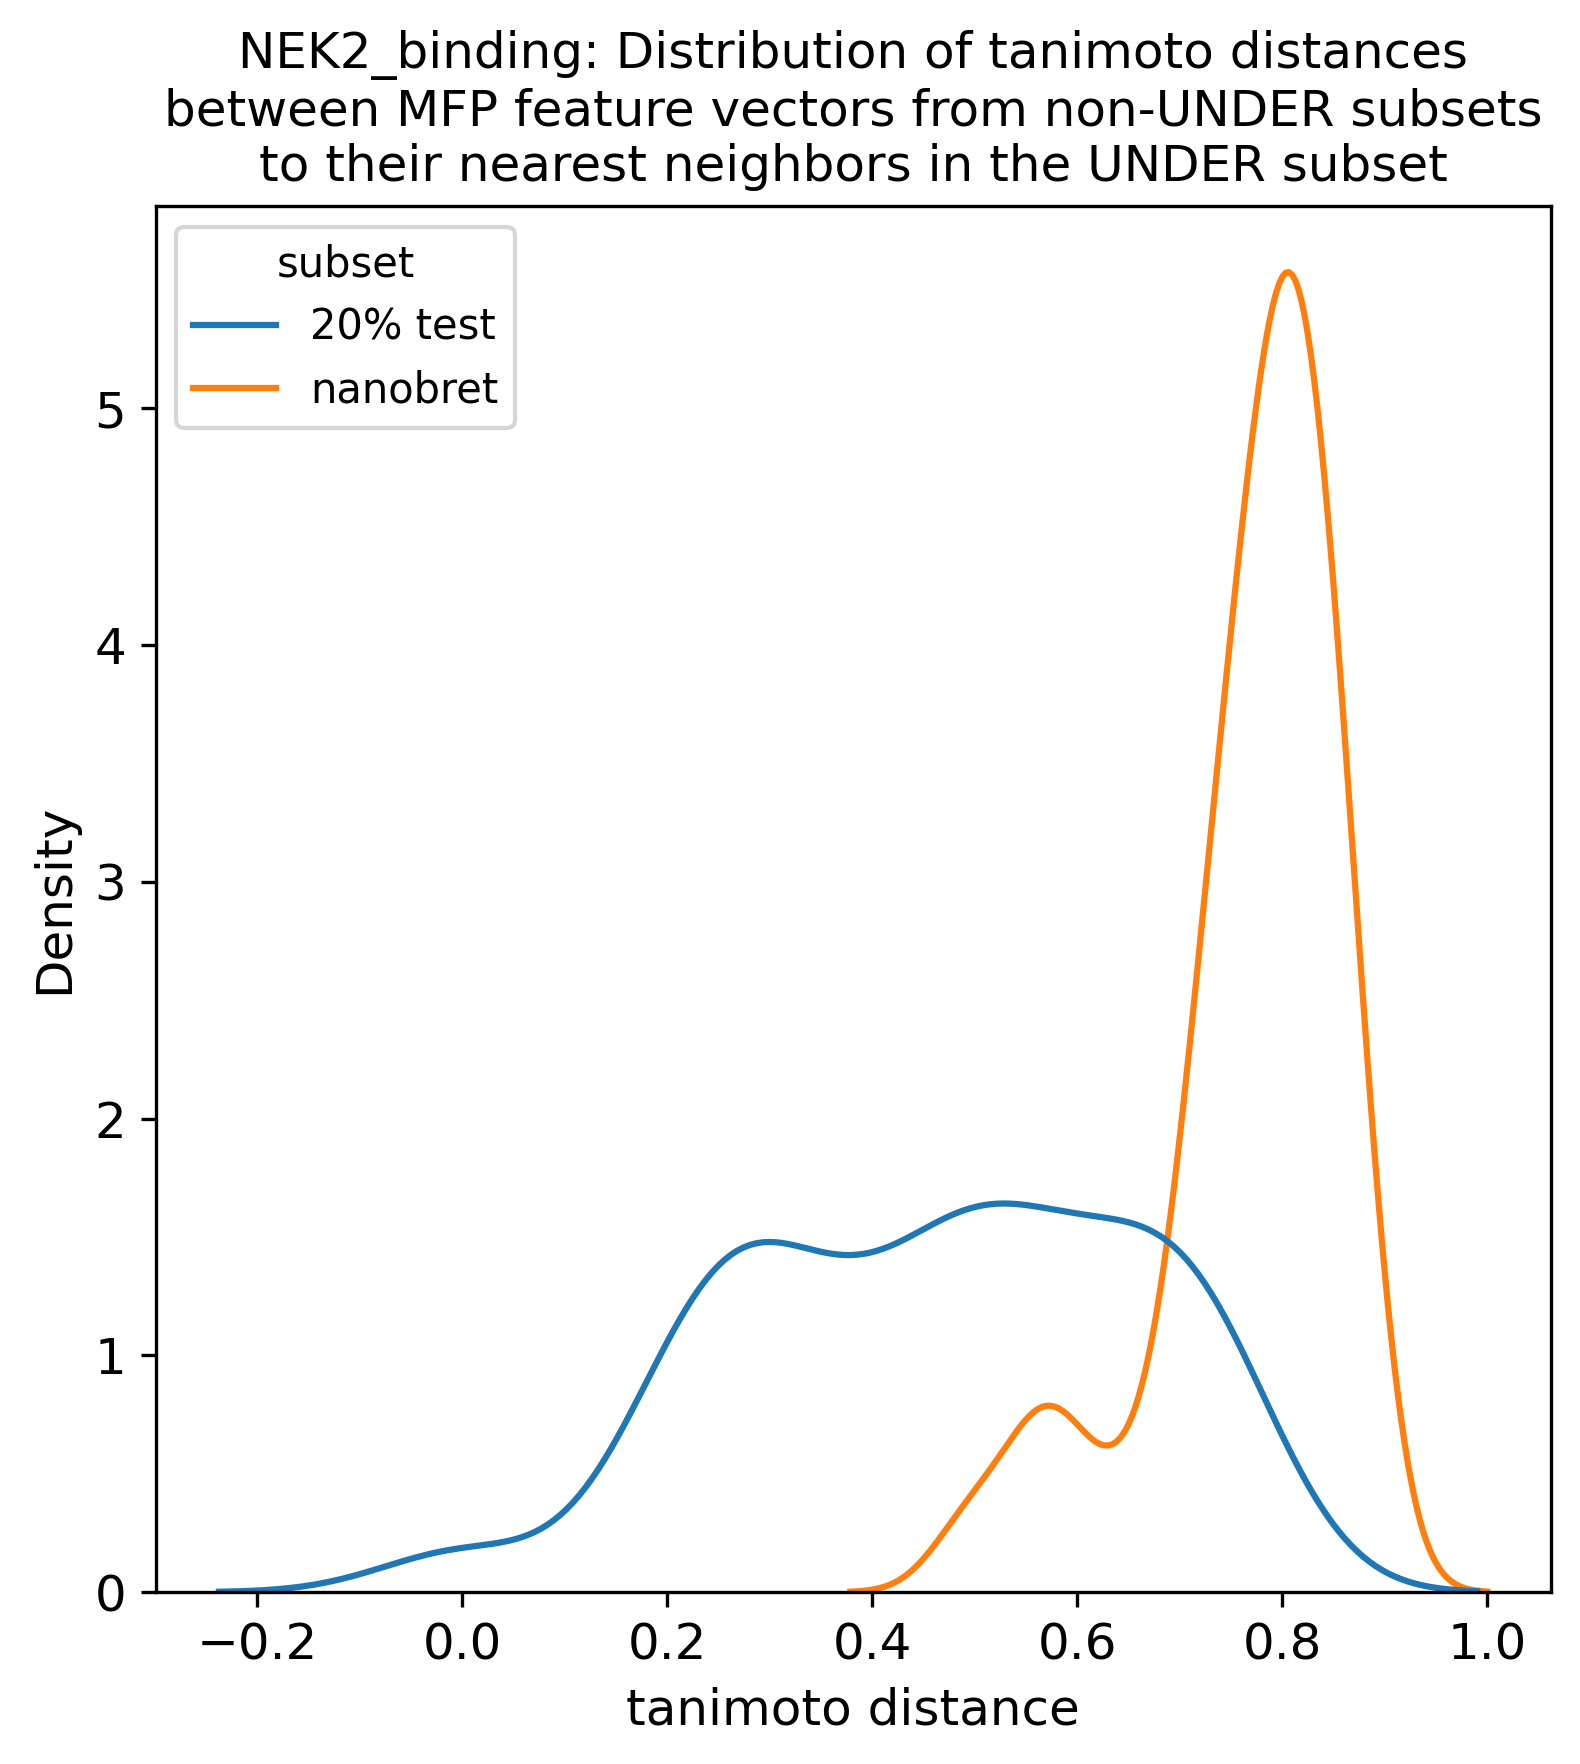

NEK2_inhibition
subset
20% test    407
nanobret    400
UNDER       224
Name: count, dtype: int64
20% test
nanobret


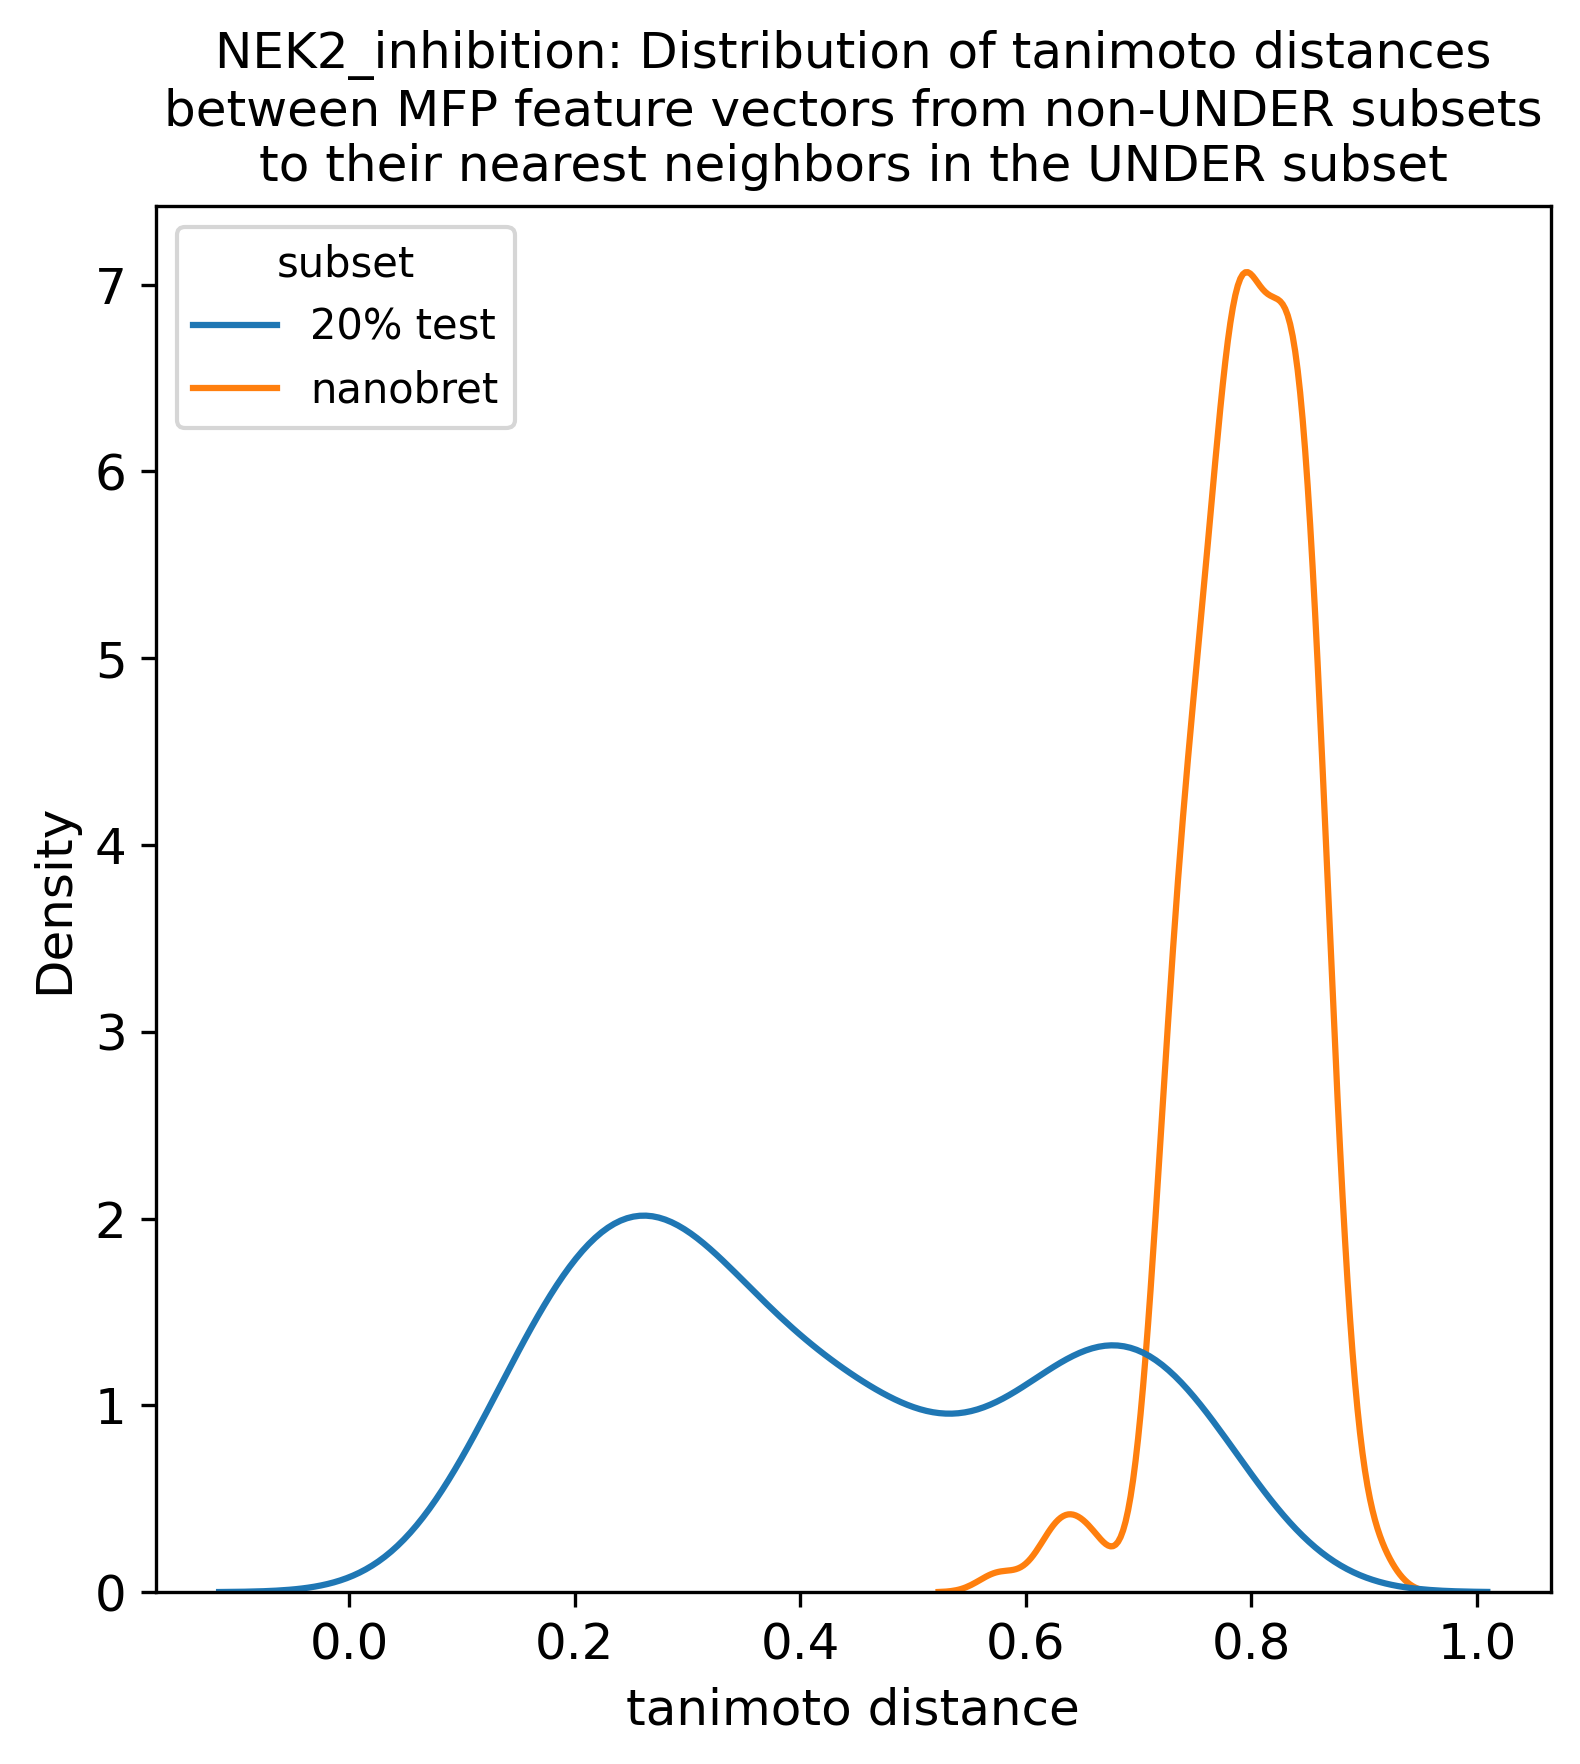

NEK3_binding
subset
nanobret    400
20% test    282
UNDER       128
Name: count, dtype: int64
20% test
nanobret


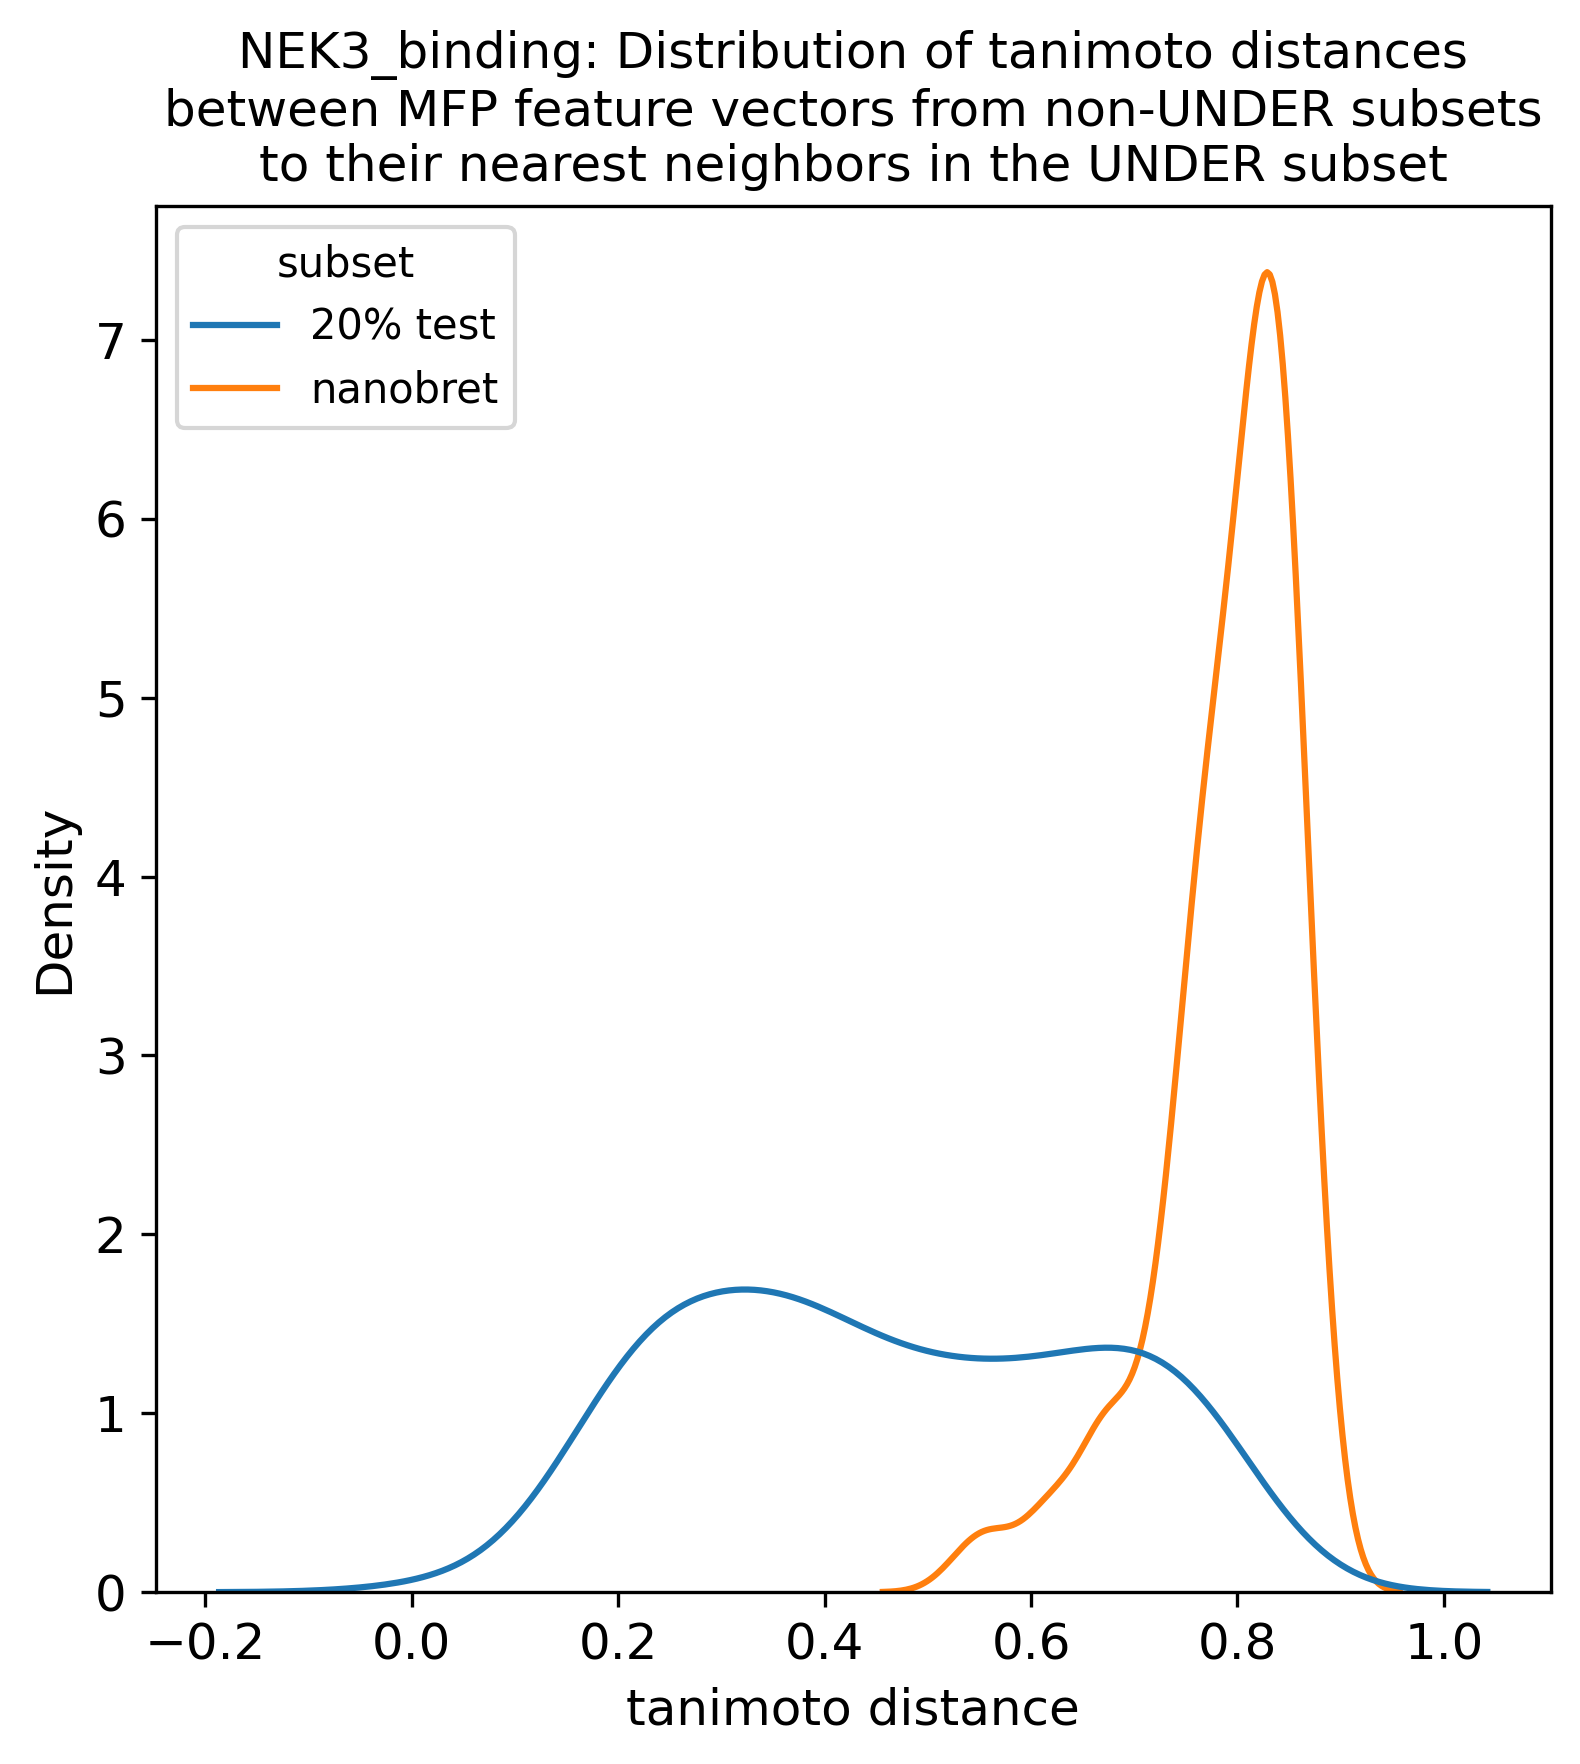

NEK5_binding
subset
nanobret    400
20% test    248
UNDER       154
Name: count, dtype: int64
20% test
nanobret


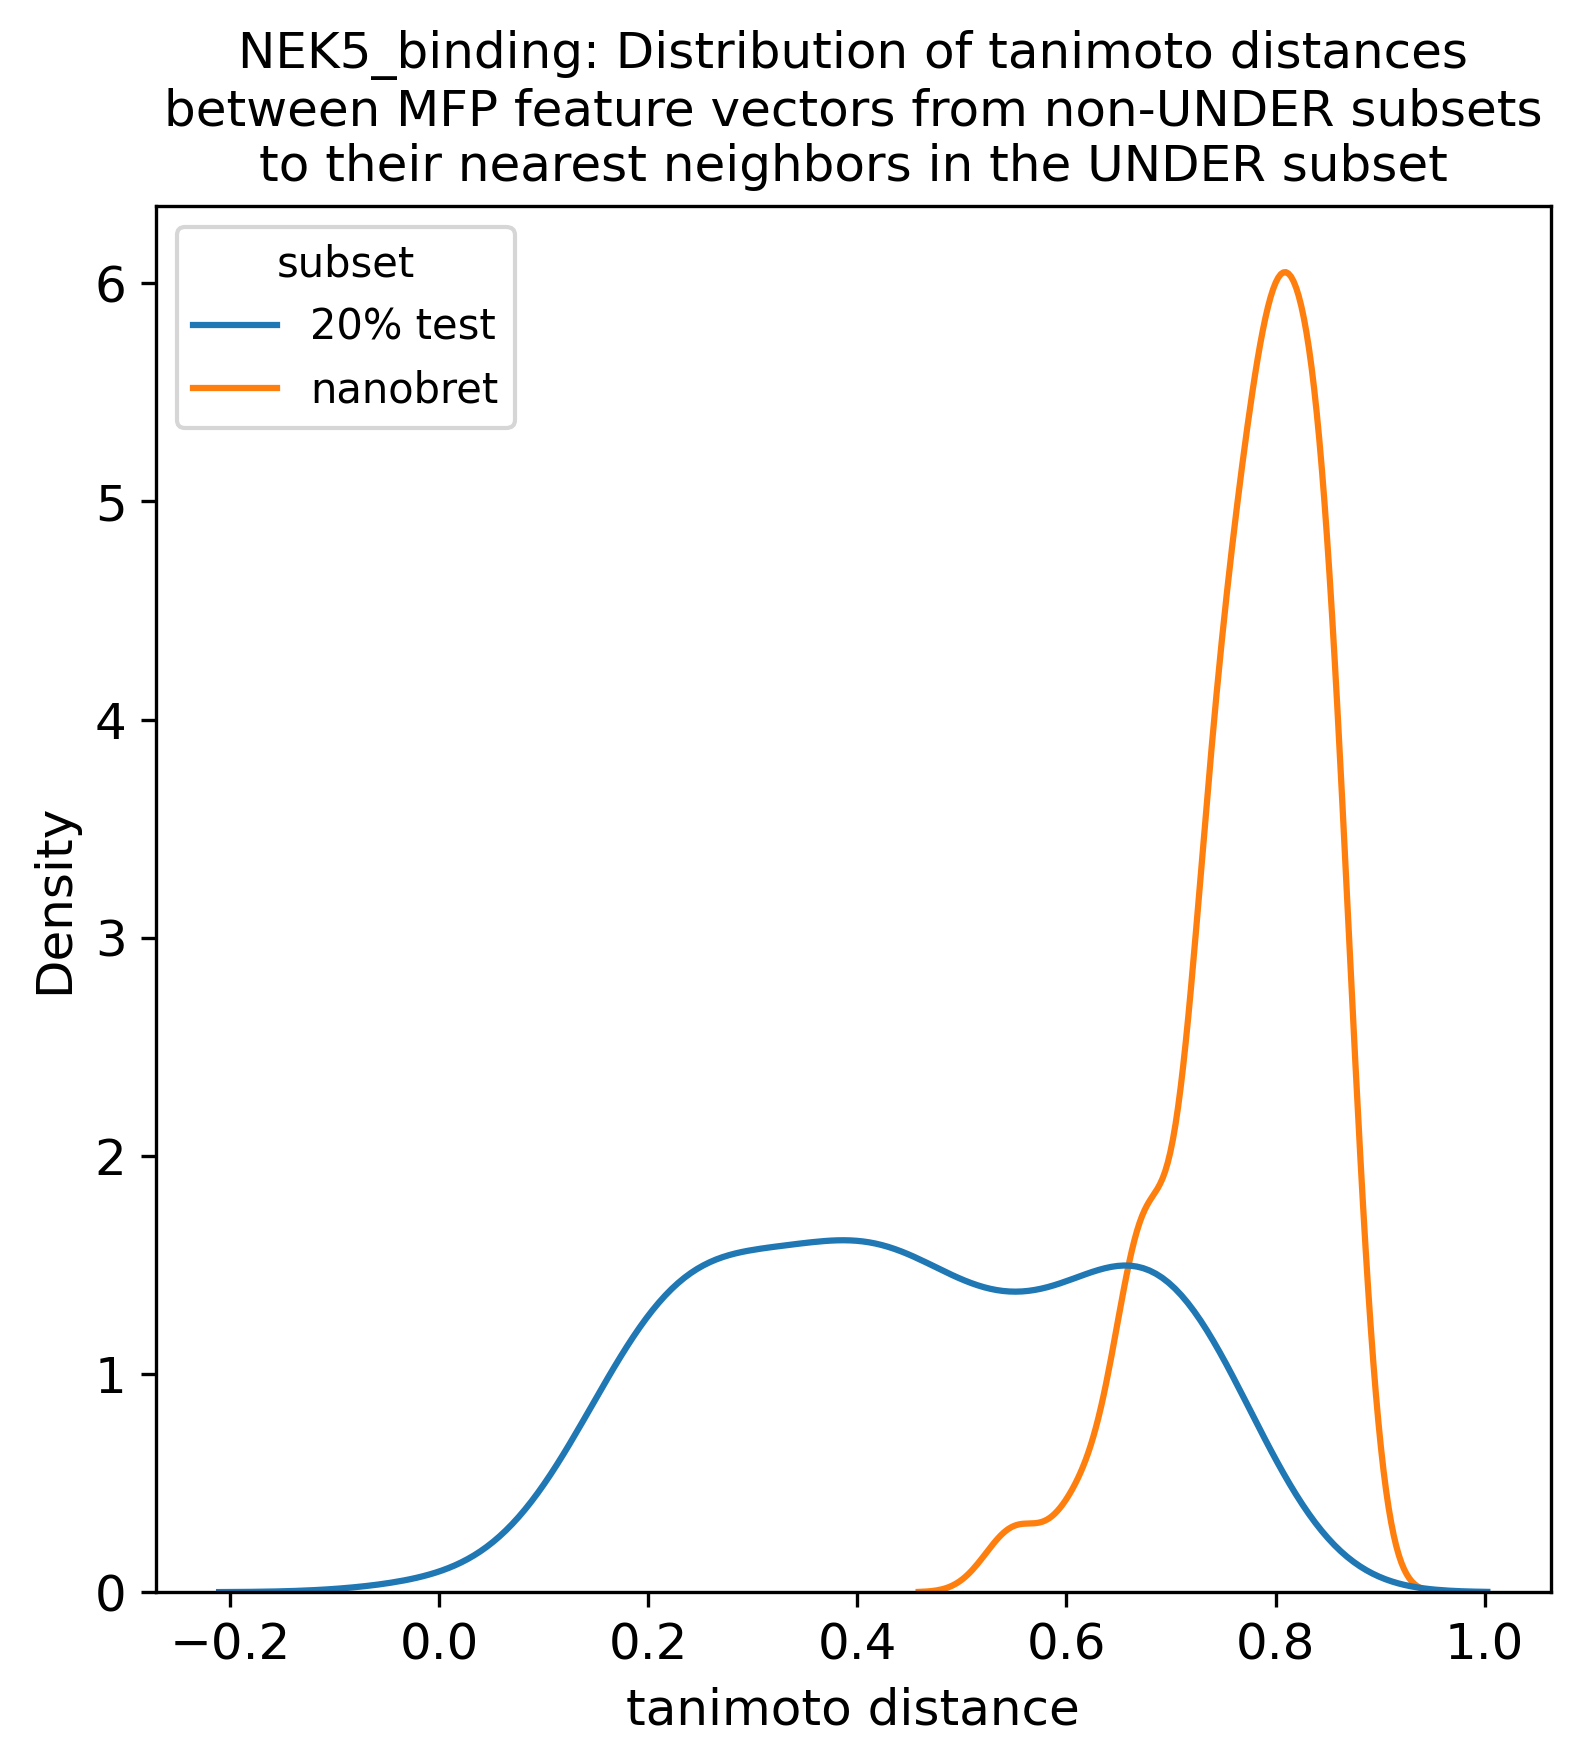

NEK9_binding
subset
nanobret    400
20% test    283
UNDER        96
Name: count, dtype: int64
20% test
nanobret


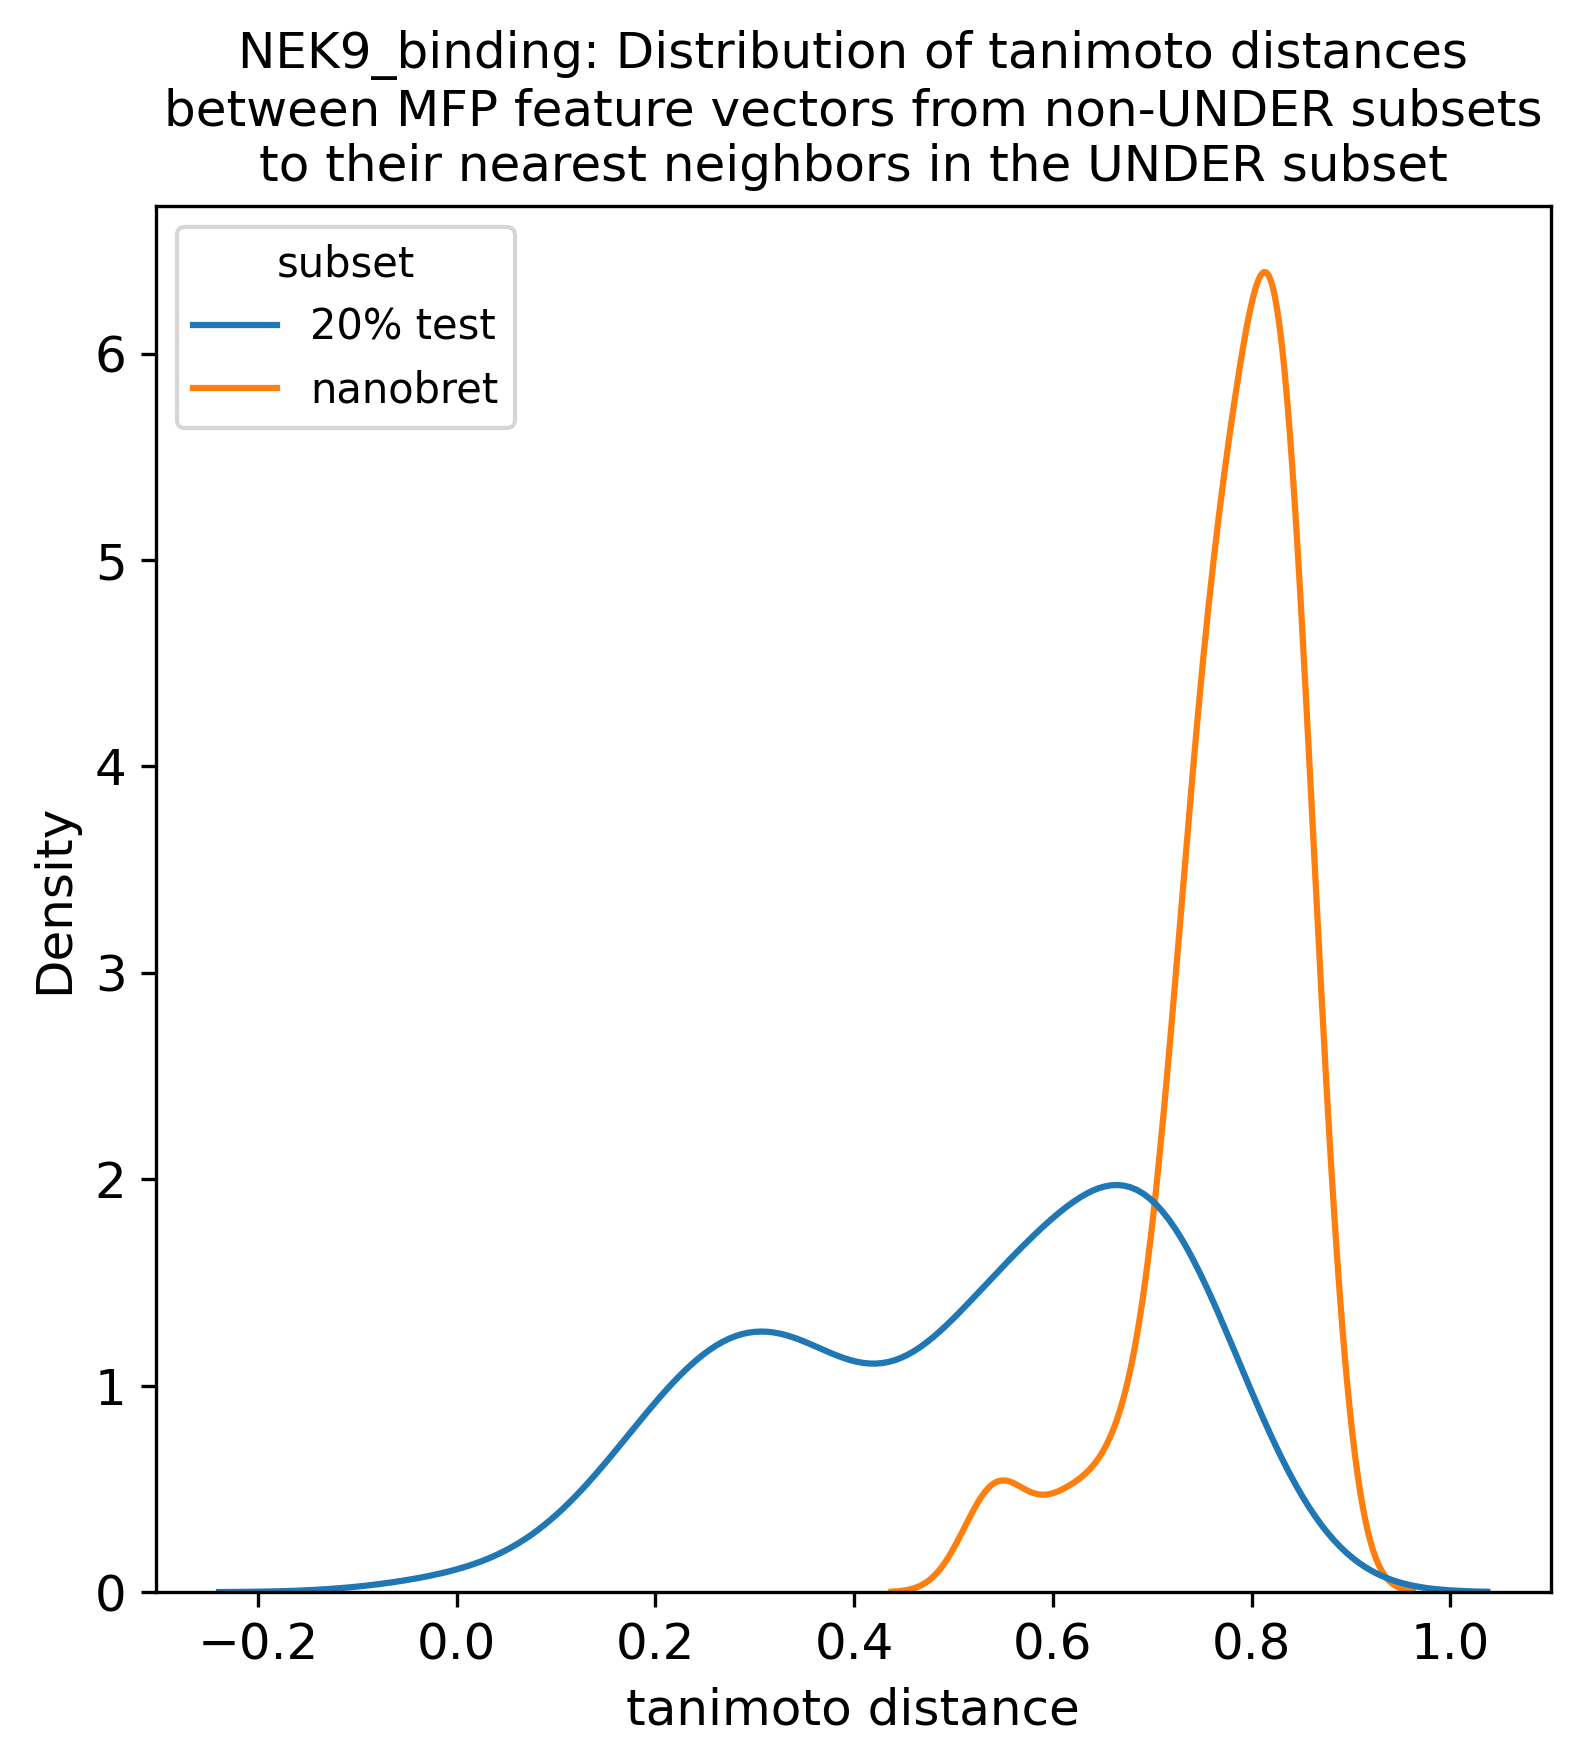

NEK9_inhibition
subset
nanobret    400
20% test     80
UNDER        66
Name: count, dtype: int64
20% test
nanobret


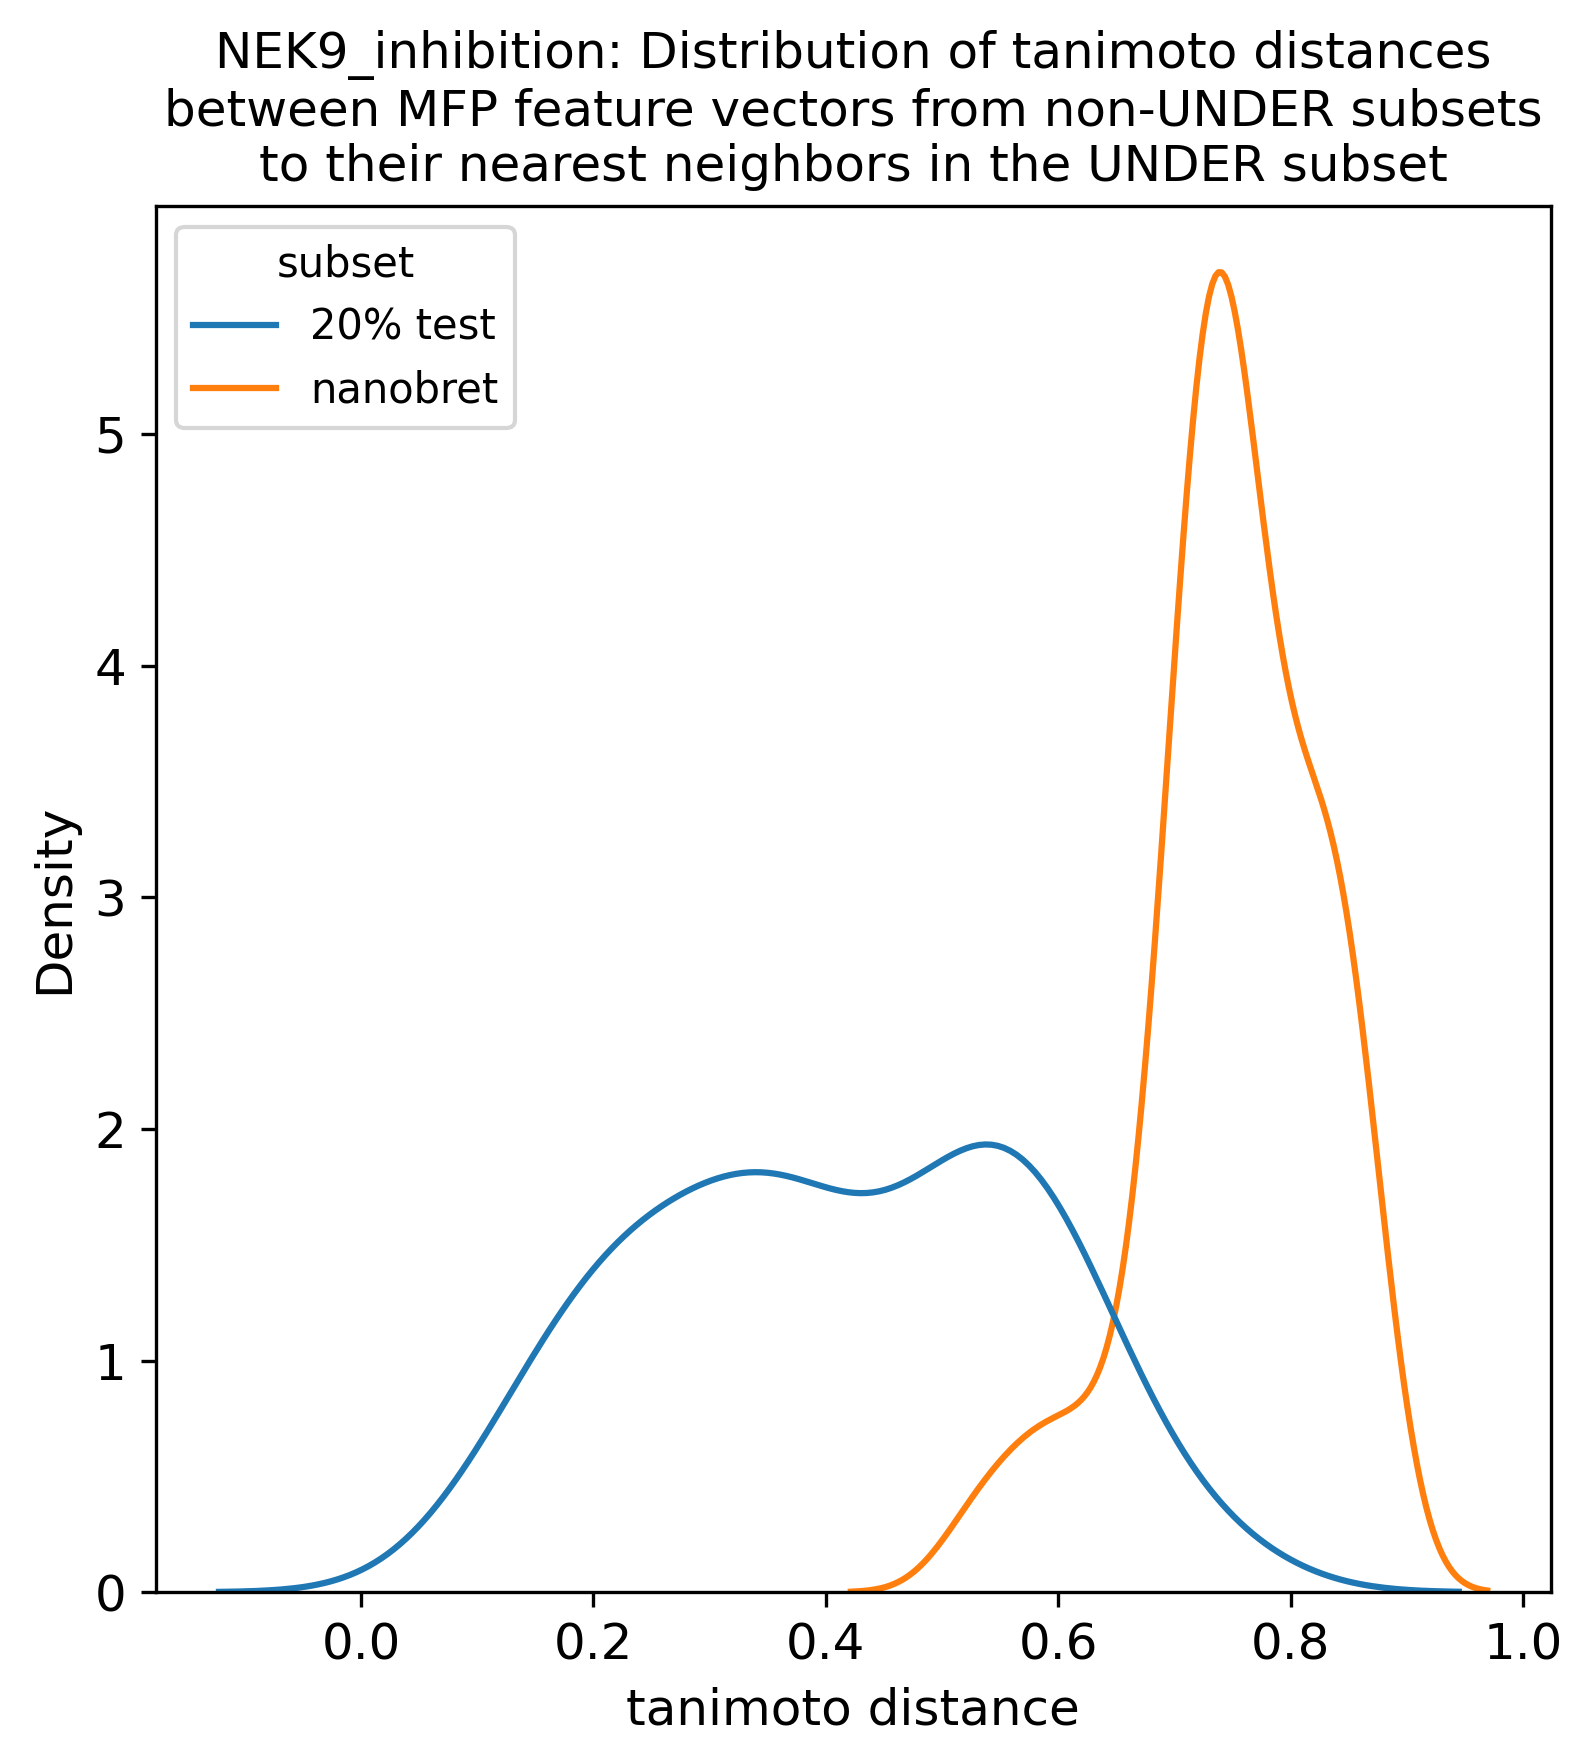

In [47]:
# (3) UNDER train vs test20% and UNDER train vs test nanobret (edited) 

pth3 = '/Users/jayceepang/msse/ATOM_CODE/examples/holdout/tanidists_vs_under/'
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{og_datapath}{nek}_MFP_none_scaled.csv') # entire train set
    og_test= mfp_desc[mfp_desc['subset']=='test'] # holdout set 1
    og_test['subset'] ='20% test'
    og_train = mfp_desc[mfp_desc['subset']=='train'] # train set
    num_train = og_train.shape[0]
    # display(og_train)
    for new_nek in new_neks: 
        if nek[:4] == new_nek:
            new_nek_df = pd.read_csv(f'{holdout_datapath}{new_nek}_MFP_none_unscaled.csv')
            holdout_df = new_nek_df[new_nek_df['subset'] == 'test'] # holdout set 2
            holdout_df['subset'] = 'nanobret'
            mfp_under = pd.read_csv(f'{og_datapath}{nek}_MFP_UNDER.csv')
            under = mfp_under[mfp_under['subset'] == 'train']
            under['subset'] = 'UNDER' 
        
            original_compounds = pd.concat([og_test, under, holdout_df])
            original_compounds= original_compounds.rename(columns=mfp_dict)
        
            print(original_compounds['subset'].value_counts())
            
            dists,fig,ax=plot_tani_dist_distr(original_compounds, 'base_rdkit_smiles', this_nek, ref_subset='UNDER',radius=2, subsets=True, featurized=True)
            fig.savefig(f'{pth3}{nek}vs_under.png', bbox_inches='tight',dpi=300)

